#Bushfire Analysis using Meteorological Data


Developer: Mayana Mohsin Khan

Programming Language: R 3.6.0 in Jupyter Notebook

R Libraries used:
- tidyverse
- repr
- gridExtra
- reshape2
- scatterpie
- car
- psych
- bestNormalize
- glmnet
- leaps
- caret
- randomForest
- e1071


## Table of Contents

* [Introduction](#sec_1)
* [Data Exploration](#sec_2)
* [Model Development](#sec_3)
* [Model Comparison](#sec_4)
* [Variable Identification and Explanation](#sec_5)
* [Conclusion](#sec_6)
* [References](#sec_7)

## 1. Introduction <a class="anchor" id="sec_1"></a>

In [1]:
# install.packages('tidyverse')
# install.packages('bestNormalize')
# install.packages('car')
# install.packages('caret')
# install.packages('glmnet')
# install.packages('leaps')
# install.packages("e1071")
# install.packages('scatterpie')

#Load Library
#EDA library
library(tidyverse)
library(repr)
library(gridExtra)
library(reshape2)
library(scatterpie)
library(car) #scatterPlotMatrix
library(psych)
library(bestNormalize)

# ML library
library(caret) # hyperparameter tuning
library(leaps) # regsubset
library(glmnet) # lasso regression
library(randomForest)
library(e1071)

# hide warning
options(warn=-1)

# Set default Plot Size and make a function for changing the plot size
options(repr.plot.width=10,repr.plot.height=10)
setPlotSize<- function(w=10,h=10){
    options(repr.plot.width=w,repr.plot.height=h)
}

Warning message:
"package 'tidyverse' was built under R version 3.6.3"
-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.0     v purrr   0.3.3
v tibble  2.1.3     v dplyr   0.8.5
v tidyr   1.0.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

Warning message:
"package 'ggplot2' was built under R version 3.6.3"
Warning message:
"package 'tibble' was built under R version 3.6.1"
Warning message:
"package 'tidyr' was built under R version 3.6.3"
Warning message:
"package 'readr' was built under R version 3.6.3"
Warning message:
"package 'purrr' was built under R version 3.6.3"
Warning message:
"package 'dplyr' was built under R version 3.6.3"
Warning message:
"package 'stringr' was built under R version 3.6.1"
Warning message:
"package 'forcats' was built under R version 3.6.3"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



## 2. Data Exploration<a class="anchor" id="sec_2"></a>
### Overview of the Training Dataset

In [2]:
# read the datafile from web
datafile <- read.csv('http://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv', header = TRUE, sep = ',')


# read the datafile from local csv file, uncomment if you have the file
# datafile <- read.csv('forestfires.csv', header = TRUE, sep = ',') 

In [3]:
# rename datafile for EDA
raw <- datafile

# Display the dimensions
cat("The dataset has", dim(raw)[1], "records, each with", dim(raw)[2],
    "attributes. The structure is:\n\n")

# Display the structure
str(raw)

cat("\nThe first few and last few records in the dataset are:")
# Inspect the first few records
head(raw)

cat("\nBasic statistics for each attribute are:")
# Statistical summary 
summary(raw)

cat("The numbers of unique values for each attribute are:")
apply(raw, 2, function(x) length(unique(x)))

The dataset has 517 records, each with 13 attributes. The structure is:

'data.frame':	517 obs. of  13 variables:
 $ X    : int  7 7 7 8 8 8 8 8 8 7 ...
 $ Y    : int  5 4 4 6 6 6 6 6 6 5 ...
 $ month: Factor w/ 12 levels "apr","aug","dec",..: 8 11 11 8 8 2 2 2 12 12 ...
 $ day  : Factor w/ 7 levels "fri","mon","sat",..: 1 6 3 1 4 4 2 2 6 3 ...
 $ FFMC : num  86.2 90.6 90.6 91.7 89.3 92.3 92.3 91.5 91 92.5 ...
 $ DMC  : num  26.2 35.4 43.7 33.3 51.3 ...
 $ DC   : num  94.3 669.1 686.9 77.5 102.2 ...
 $ ISI  : num  5.1 6.7 6.7 9 9.6 14.7 8.5 10.7 7 7.1 ...
 $ temp : num  8.2 18 14.6 8.3 11.4 22.2 24.1 8 13.1 22.8 ...
 $ RH   : int  51 33 33 97 99 29 27 86 63 40 ...
 $ wind : num  6.7 0.9 1.3 4 1.8 5.4 3.1 2.2 5.4 4 ...
 $ rain : num  0 0 0 0.2 0 0 0 0 0 0 ...
 $ area : num  0 0 0 0 0 0 0 0 0 0 ...

The first few and last few records in the dataset are:

X Y month day FFMC DMC  DC    ISI  temp RH wind rain area
1 7 5 mar   fri 86.2 26.2  94.3  5.1  8.2 51 6.7  0.0  0   
2 7 4 oct   tue 90.6 35.4 669.1  6.7 18.0 33 0.9  0.0  0   
3 7 4 oct   sat 90.6 43.7 686.9  6.7 14.6 33 1.3  0.0  0   
4 8 6 mar   fri 91.7 33.3  77.5  9.0  8.3 97 4.0  0.2  0   
5 8 6 mar   sun 89.3 51.3 102.2  9.6 11.4 99 1.8  0.0  0   
6 8 6 aug   sun 92.3 85.3 488.0 14.7 22.2 29 5.4  0.0  0


Basic statistics for each attribute are:

       X               Y           month      day          FFMC      
 Min.   :1.000   Min.   :2.0   aug    :184   fri:85   Min.   :18.70  
 1st Qu.:3.000   1st Qu.:4.0   sep    :172   mon:74   1st Qu.:90.20  
 Median :4.000   Median :4.0   mar    : 54   sat:84   Median :91.60  
 Mean   :4.669   Mean   :4.3   jul    : 32   sun:95   Mean   :90.64  
 3rd Qu.:7.000   3rd Qu.:5.0   feb    : 20   thu:61   3rd Qu.:92.90  
 Max.   :9.000   Max.   :9.0   jun    : 17   tue:64   Max.   :96.20  
                               (Other): 38   wed:54                  
      DMC              DC             ISI              temp      
 Min.   :  1.1   Min.   :  7.9   Min.   : 0.000   Min.   : 2.20  
 1st Qu.: 68.6   1st Qu.:437.7   1st Qu.: 6.500   1st Qu.:15.50  
 Median :108.3   Median :664.2   Median : 8.400   Median :19.30  
 Mean   :110.9   Mean   :547.9   Mean   : 9.022   Mean   :18.89  
 3rd Qu.:142.4   3rd Qu.:713.9   3rd Qu.:10.800   3rd Qu.:22.80  
 Max.   :291.3   Max.   :860.6   Max.   :56.

The numbers of unique values for each attribute are:

X     Y month   day  FFMC   DMC    DC   ISI  temp    RH  wind  rain  area 
    9     7    12     7   106   215   219   119   192    75    21     7   251

#### Summary of Attributes
The table below identifies every column type and subtype of the dataset, which column is Categorical and which one is Numerical. For categorical columns, they can be a Ordinal or Nominal variable. Whereas each numerical column can be Continous or Discrete variable.

|Attribute  |Type       |Sub-type  |Info From names file|Comments|
|-----------|-----------|----------|--------------------|--------------------------------|
|X|Categorical|Ordinal|x-axis spatial coordinate within the Montesinho park map|Has 9 unique values ranged between 1 to 9, most are around 4|
|Y|Categorical|Ordinal|y-axis spatial coordinate within the Montesinho park map|Has 7 unique values ranged between 2 to 9, most are around 4| 
|month|Categorical|Ordinal|Contains abbreviated month names|the majority are august and september - has circular order|
|day|Categorical|Ordinal|Contains abbreviated day names|majorty of forest burnt occurs on Sunday - has circular order|
|FFMC|Numerical|Continuous|Fine Fuel Moisture Code|Ranges from 18.7 to 96.2 - could have extreme outliers and left skewed|
|DMC|Numerical|Continuous|Duff Moisture Code|Ranges from 1.1 to 291.3 - could have extreme outliers and left skewed|
|DC|Numerical|Continuous|Drought Code|Ranges from 7.9 to 860.6 - could have extreme outliers and left skewed|
|ISI|Numerical|Continuous|Initial Spread Index|Ranges from 0 to 56.1 - could have outliers on higher values - contains 0|
|temp|Numerical|Continuous|temperature in Celsius degrees|Ranges from 2.2 to 33.3 - could have outliers on lower values|
|RH|Numerical|Continuous|relative humidity in %|Ranges from 15 to 100 - may skewed to right|
|wind|Numerical|Continuous|wind speed in km/h|Ranges from 0.4 to 9.4|
|rain|Numerical|Continuous|outside rain in mm/m2|Ranges from 0 to 6.4 - extremely skewed to left, contains 0|
|area|Numerical|Continuous|the burned area of the forest (in ha)|Ranges from 0 to 1090.84 - top value maybe is an outlier|

X and Y are categorical ordial data that contains coordinate of bustfires in Montesinho Park. However, they are stored as integer in the dataset. Thus, it is better to convert them as factor.

### Investigate Column Distributions (Univariate Analysis)

In [4]:
# factorized categorical columns
raw$month <- factor(raw$month, levels = c("jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"))
raw$day <- factor(raw$day, levels = c("mon", "tue", "wed", "thu", "fri", "sat", "sun"))
raw$X <- as.factor(raw$X)
raw$Y <- as.factor(raw$Y)

# attach the datase so we can directly call its columns
attach(raw)

# specify categorical columns
cat.cols <- c("X", "Y", "month", "day")

#### Check Distribution of Categorical Columns

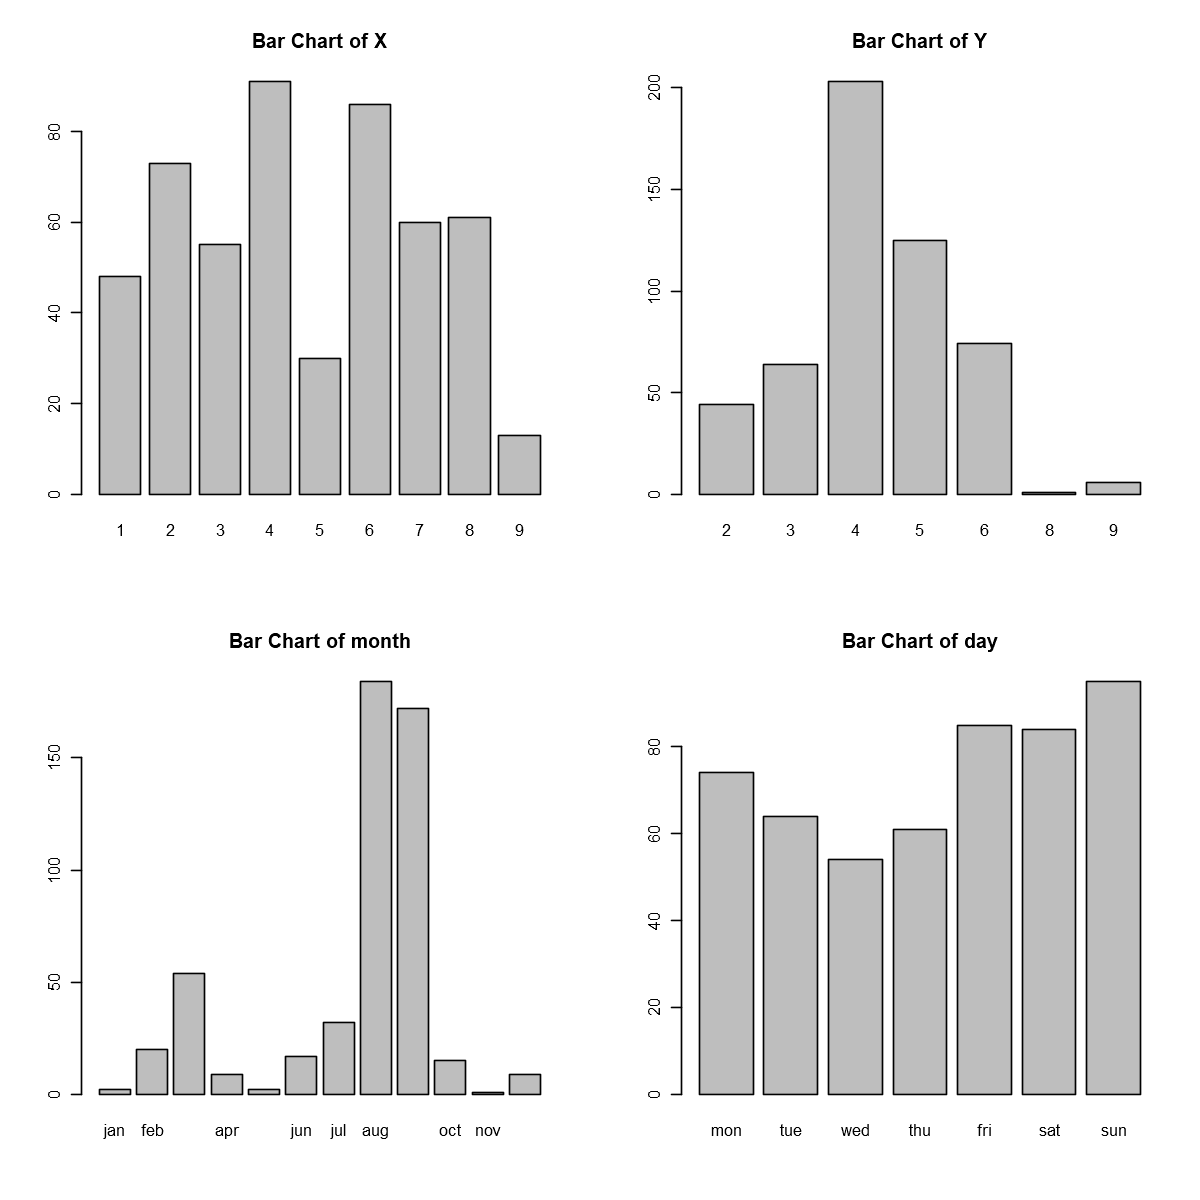

In [5]:
par(mfrow = c(2,2))
plot(X,main="Bar Chart of X")
plot(Y,main="Bar Chart of Y")
plot(month,main="Bar Chart of month")
plot(day,main="Bar Chart of day")

These graphs show that:
* most bustfires occurs in 4 and 6 of X-coordinate and 4 of Y-coordinate
* there is no bustfire recorded at 7 of Y-coordinate
* most bustfires occirs in august and september which should be a summer in Montesinho park (Portugal) 
* number of busfires are the at its peak on sunday
* Both month and day bustfires distribution graph show some circular pattern of bustfire numbers.
* In month column, there was an increase of bustfire number in January to March then it was decreasing to May. Then, it began to increase again to August then started to drop again until December
* So does in the day column, the bustfire number was decreasing from Monday to Wednesday then it started to rise until Sunday.

I can transform month and day with a **circular sine and cosine transformations**, so that the circular pattern can be observed.

In [6]:
# circular transformation function
cirTransform <- function(series){
    n <- length(unique(series))
    result <- as.matrix(cbind(round(sin(2*pi*(series-1)/n),3),round(cos(2*pi*(series-1)/n),3)), nrow=n,ncol=2)
    colnames(result) <- c('sin','cos')
    return(result)
}

Transform Month

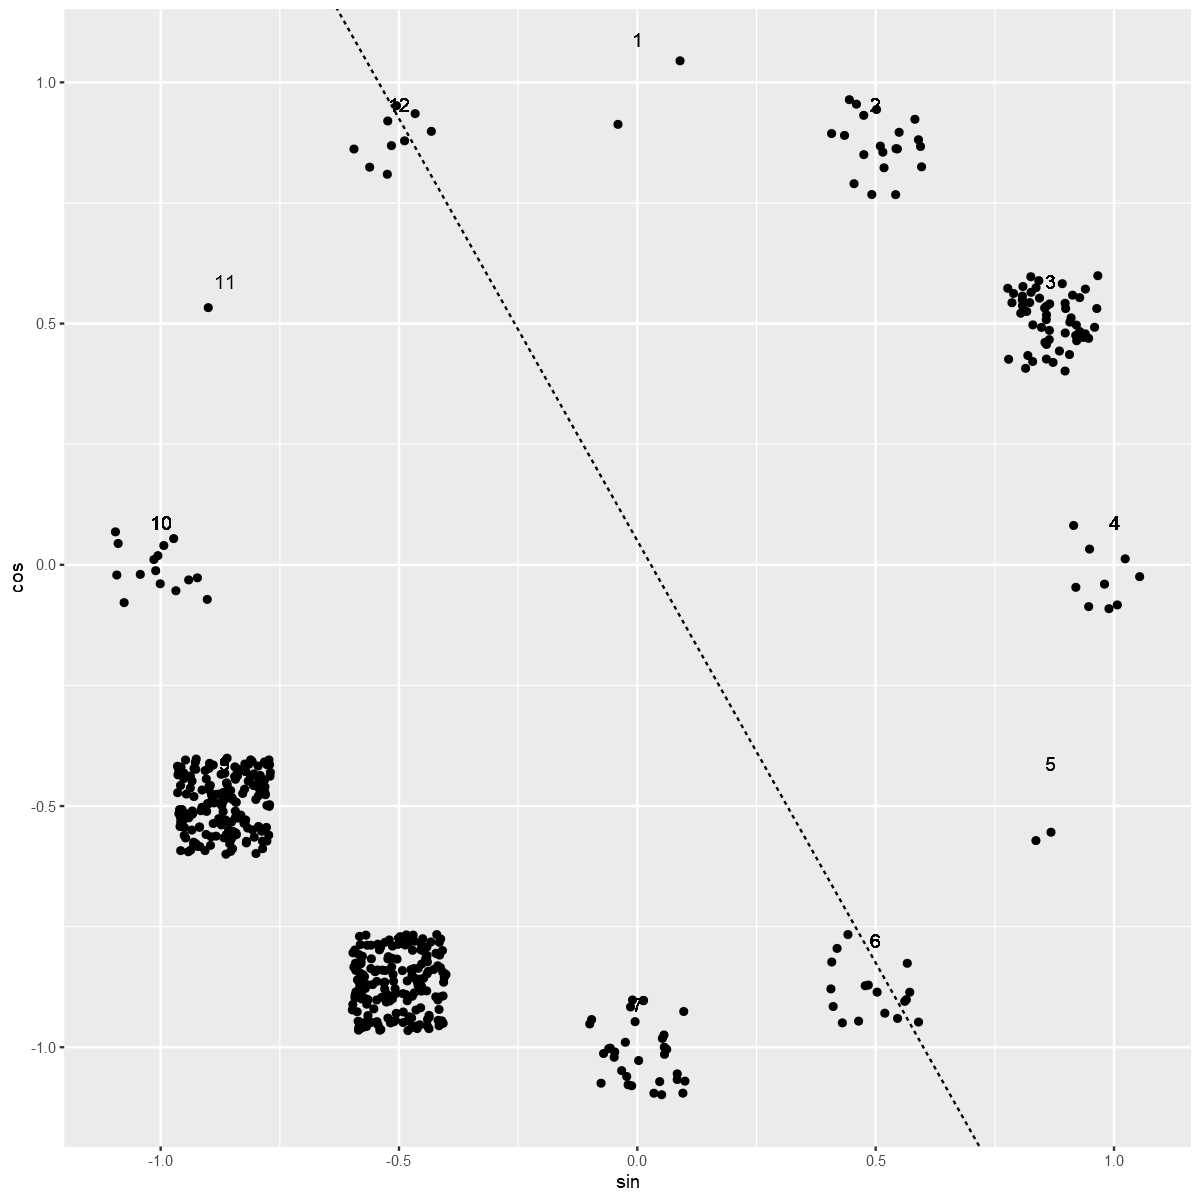

In [7]:
circle <- cirTransform(as.integer(month))
data.frame(cbind(month,circle)) %>%
    ggplot(aes(sin,cos,label=month)) +
    geom_jitter(width = .1,height = .1) +
    geom_text(vjust=-2.5) +
    geom_abline(intercept = .05, slope = -1.75, linetype='dashed')

# store the transformations
raw$month.sin <- circle[,'sin']
raw$month.cos <- circle[,'cos']

The result of transformation makes the variable linearly separable. If I draw a straight line that goes through December and June, the dataset can be separated to two distribution, the left side with September as its peak and the right side with march as its peak.

Transform day

In [8]:
circle <- cirTransform(as.integer(day))

# store the transformations
raw$day.sin <- circle[,'sin']
raw$day.cos <- circle[,'cos']

#### Check Numerical Columns' Distribution
Using boxplots

No id variables; using all as measure variables



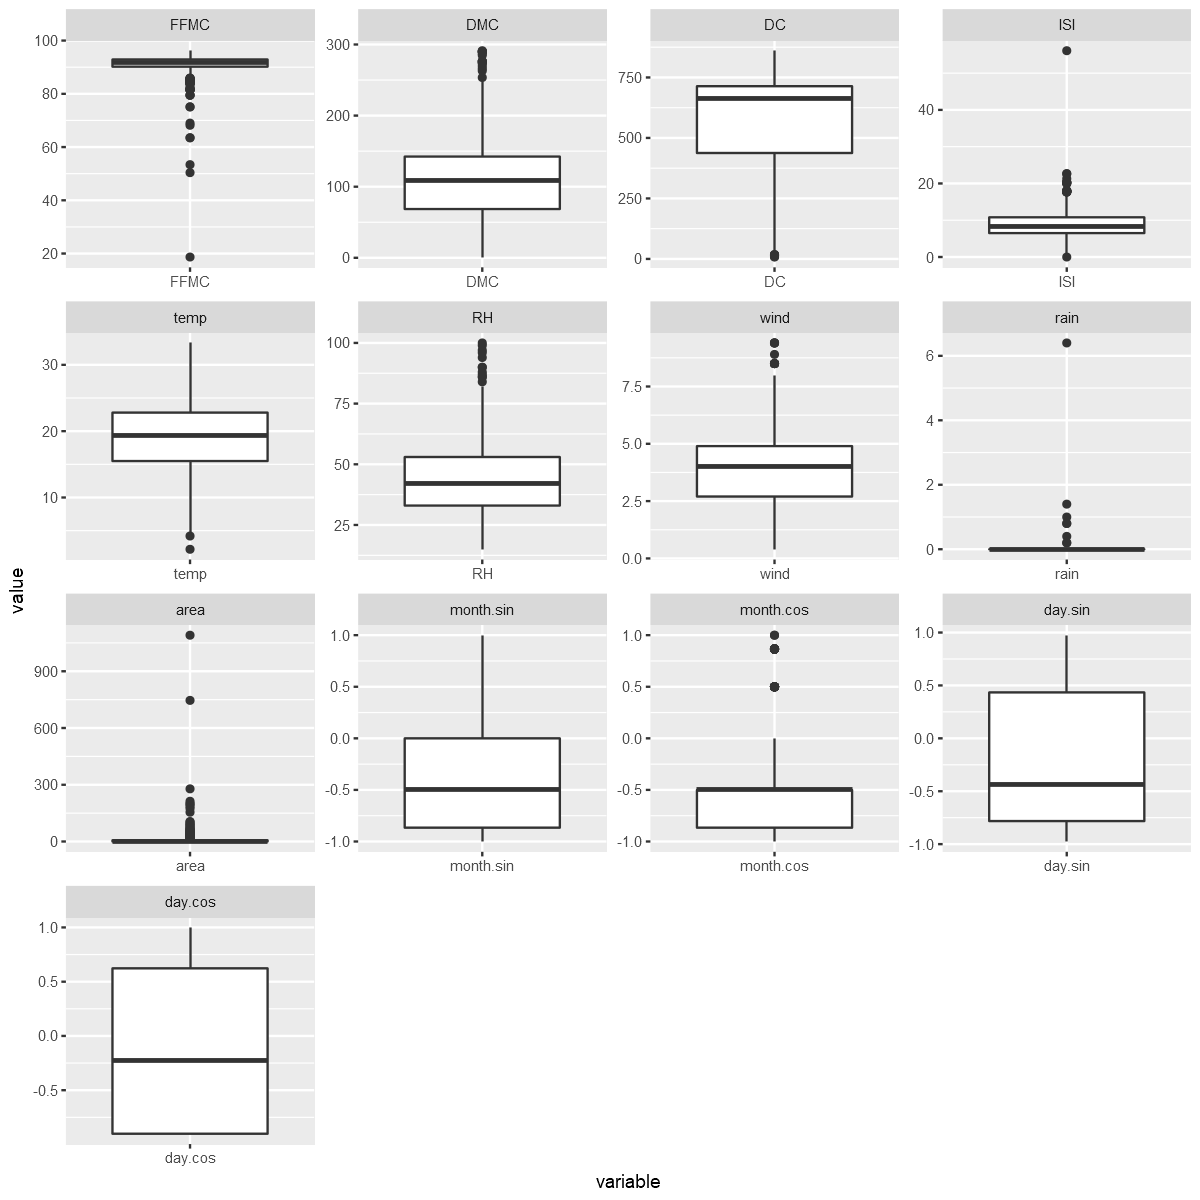

In [9]:
# Generate box plots of all variables except the two categorical/nomimal ones
m1 <- melt(as.data.frame(raw[,which(!names(raw)%in%cat.cols)]))
ggplot(m1,aes(x = variable,y = value)) +
facet_wrap(~variable, scales="free") +
geom_boxplot() +
scale_y_continuous(labels=function (n) {format(n, scientific=FALSE)})

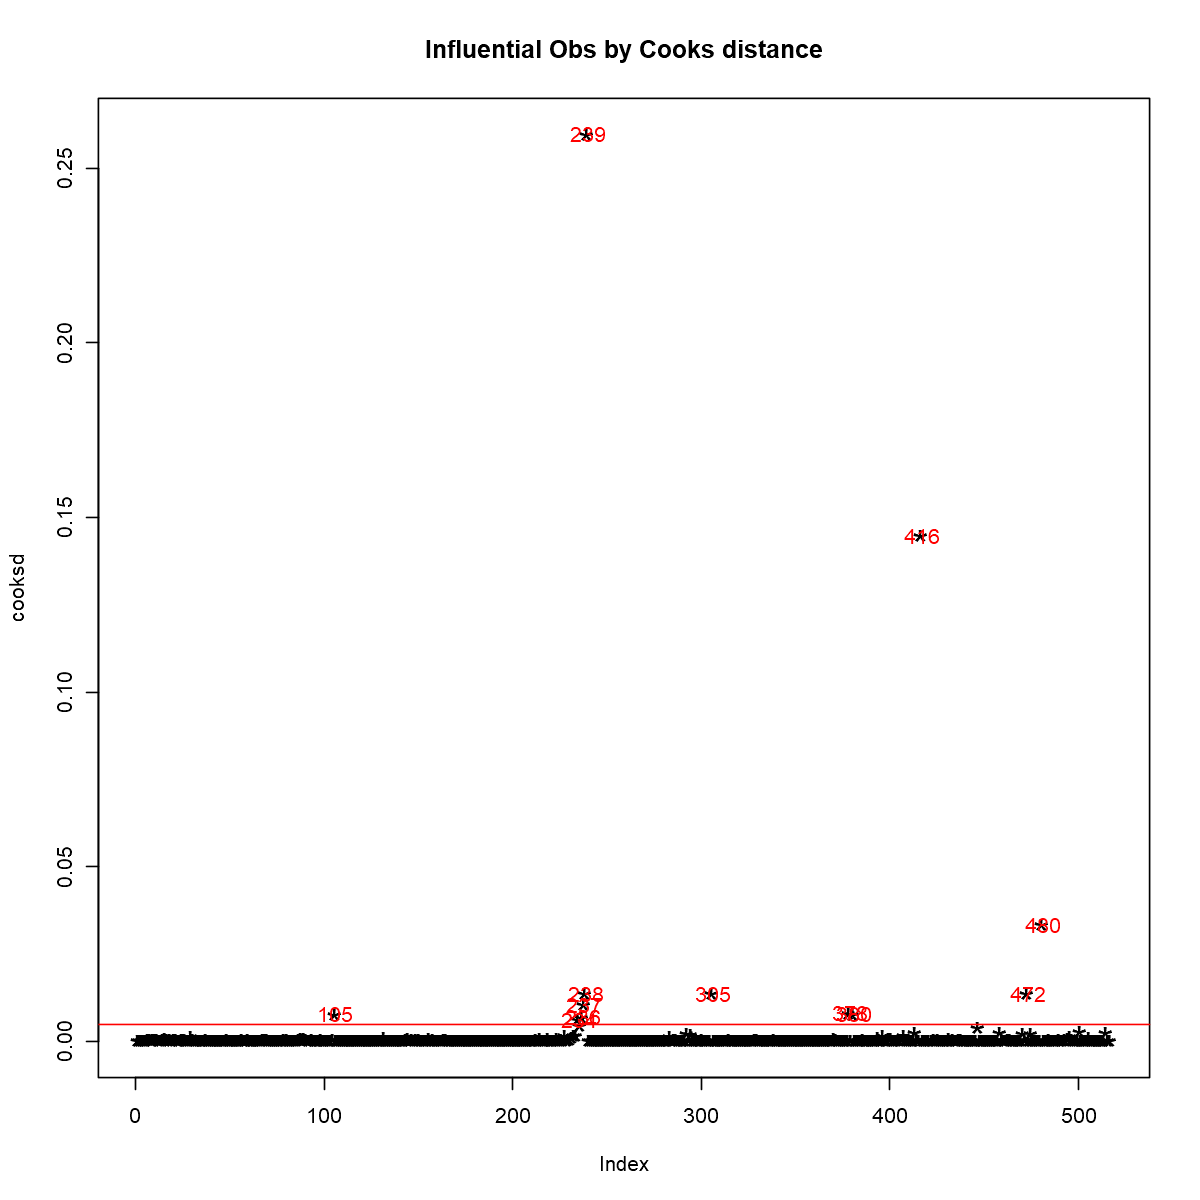

In [10]:
setPlotSize(10,10)

# Find Influential Outliers using Cook's Distance
m <- lm(area~.,data=raw)
cooksd <- cooks.distance(m)
plot(cooksd, pch="*", cex=2, main="Influential Obs by Cooks distance")  # plot cook's distance
abline(h = 4*mean(cooksd, na.rm=T), col="red")  # add cutoff line
text(x=1:length(cooksd)+1, y=cooksd, labels=ifelse(cooksd>4*mean(cooksd, na.rm=T),names(cooksd),""), col="red")  # add labels

In [11]:
# Store the influential datapoints' index
influential <- as.numeric(names(cooksd)[(cooksd > 4*mean(cooksd, na.rm=T))])

#print row index of influential outliers
influential[!is.na(influential)]

# remove them
raw <- raw[!rownames(raw) %in% influential,]
dim(raw)

[1] 105 234 236 237 238 239 305 378 380 416 472 480

[1] 505  17

Using Histogram

vars n   mean    sd      median  trimmed mad     min    max    
FFMC       1   505  90.809   4.532  91.600  91.496   1.927 50.400  96.200
DMC        2   505 111.125  63.761 108.300 106.763  51.743  2.400 291.300
DC         3   505 550.013 247.087 664.200 581.223 118.905  7.900 860.600
ISI        4   505   9.080   4.563   8.400   8.779   3.113  0.400  56.100
temp       5   505  18.907   5.774  19.300  19.091   5.337  2.200  33.300
RH         6   505  44.097  16.047  42.000  42.612  14.826 15.000  99.000
wind       7   505   4.030   1.797   4.000   3.910   1.927  0.400   9.400
rain       8   505   0.022   0.299   0.000   0.000   0.000  0.000   6.400
area       9   505   7.123  17.744   0.430   2.793   0.638  0.000 185.760
month.sin 10   505  -0.361   0.601  -0.500  -0.448   0.543 -1.000   1.000
month.cos 11   505  -0.463   0.543  -0.500  -0.548   0.543 -1.000   0.866
day.sin   12   505  -0.117   0.692  -0.434  -0.146   0.802 -0.975   0.975
day.cos   13   505   0.020   0.713  -0.223   0.013   1.005 -0.901   1.000
          range   skew   kurtosis se    
FFMC       45.800 -4.260  27.594   0.202
DMC       288.900  0.558   0.215   2.837
DC        852.700 -1.108  -0.221  10.995
ISI        55.700  2.564  21.465   0.203
temp       31.100 -0.307   0.118   0.257
RH         84.000  0.803   0.254   0.714
wind        9.000  0.571   0.019   0.080
rain        6.400 19.469 405.814   0.013
area      185.760  5.032  34.411   0.790
month.sin   2.000  1.102  -0.163   0.027
month.cos   1.866  1.258   0.337   0.024
day.sin     1.950  0.272  -1.407   0.031
day.cos     1.901 -0.064  -1.532   0.032

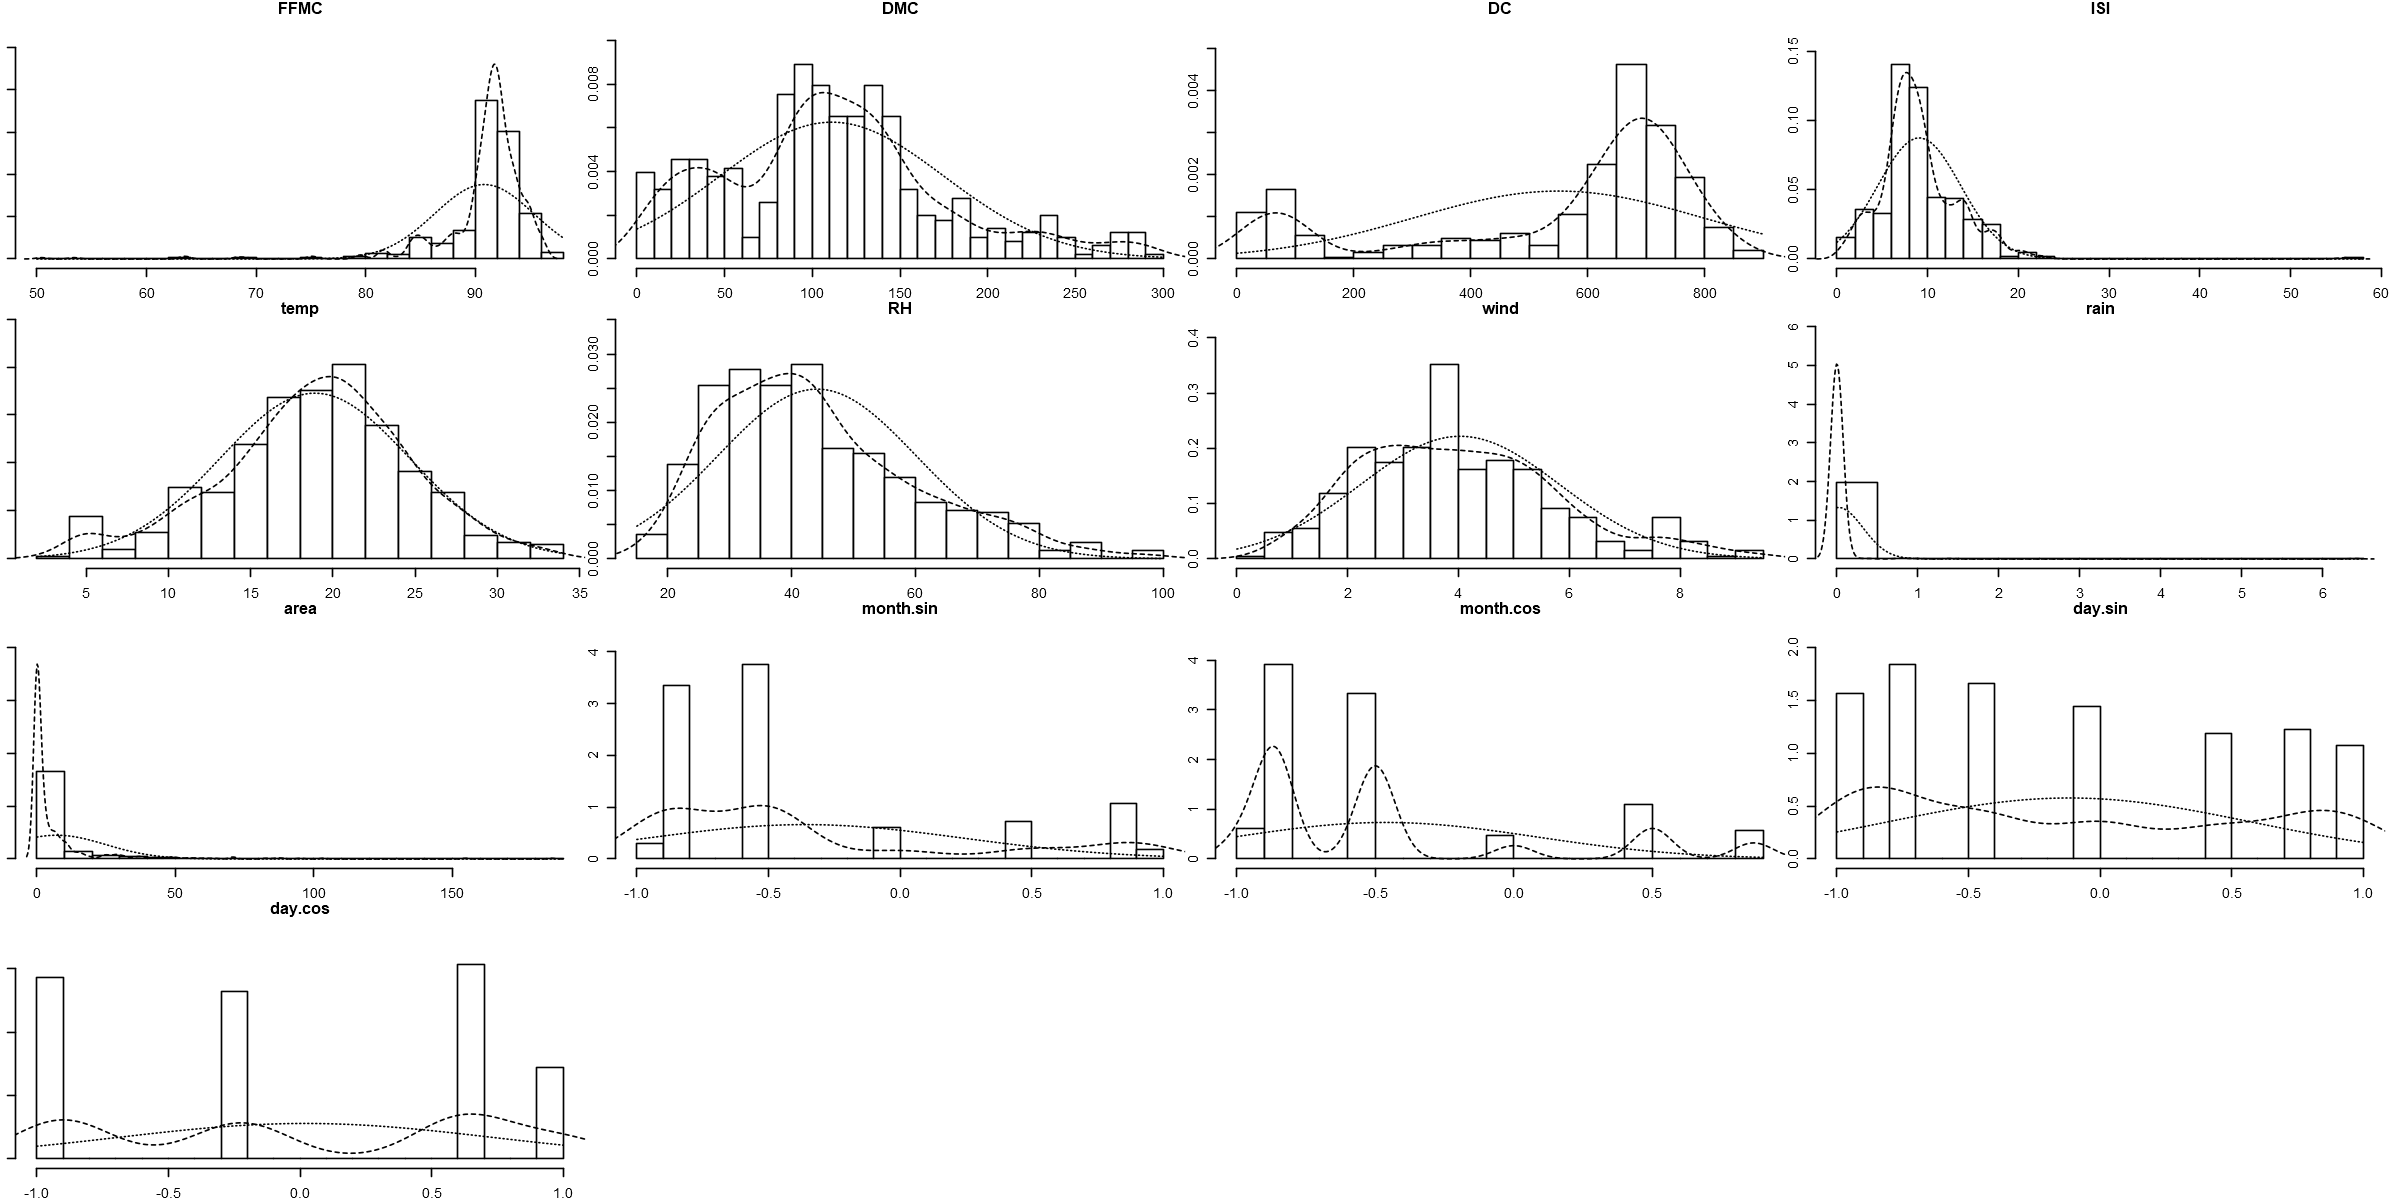

In [12]:
# print more statistic of numerical columns
setPlotSize(20)
round(describe(raw[,which(!names(raw)%in%cat.cols)]),3)

# Plot each numerical columns' histogram
multi.hist(raw[,which(!names(raw)%in%cat.cols)])

These graphs explains:
* Three numerical columns are right skewed which are FFMC, DC and temp
* Six other columns are left skewed which are DMC, ISI, RH, wind, rain and area
* Five columns have the skewness problem since they have skewness value more that 1. They are FFMC, DC, ISI, rain, area.
* Four columns have extreme kurtosis values which are FFMC, ISI, rain, area
* There are three columns that are distributed on a different range than the others. DMC, DC and area have a range which is more than hundred.

I can **transform** FFMC, DMC, DC, ISI, rain, area so that their distribution becomes normalized and they have a similar range.

#### Find Best Normalization Transformation

FFMC

orderNorm Transformation with 505 nonmissing obs and ties
 - 103 unique values 
 - Original quantiles:
  0%  25%  50%  75% 100% 
50.4 90.3 91.6 92.9 96.2 


vars n   mean          sd        median      trimmed      mad      
X1 1    505 90.8085148515 4.5324346 91.60000000 9.149605e+01 1.9273800
X2 2    505 -0.0005003753 0.9978524 -0.06208512 6.362634e-05 0.9727935
   min       max       range     skew       kurtosis    se        
X1 50.400000 96.200000 45.800000 -4.2597288 27.59360632 0.20169069
X2 -3.093186  2.881299  5.974485 -0.0101584 -0.08811744 0.04440385

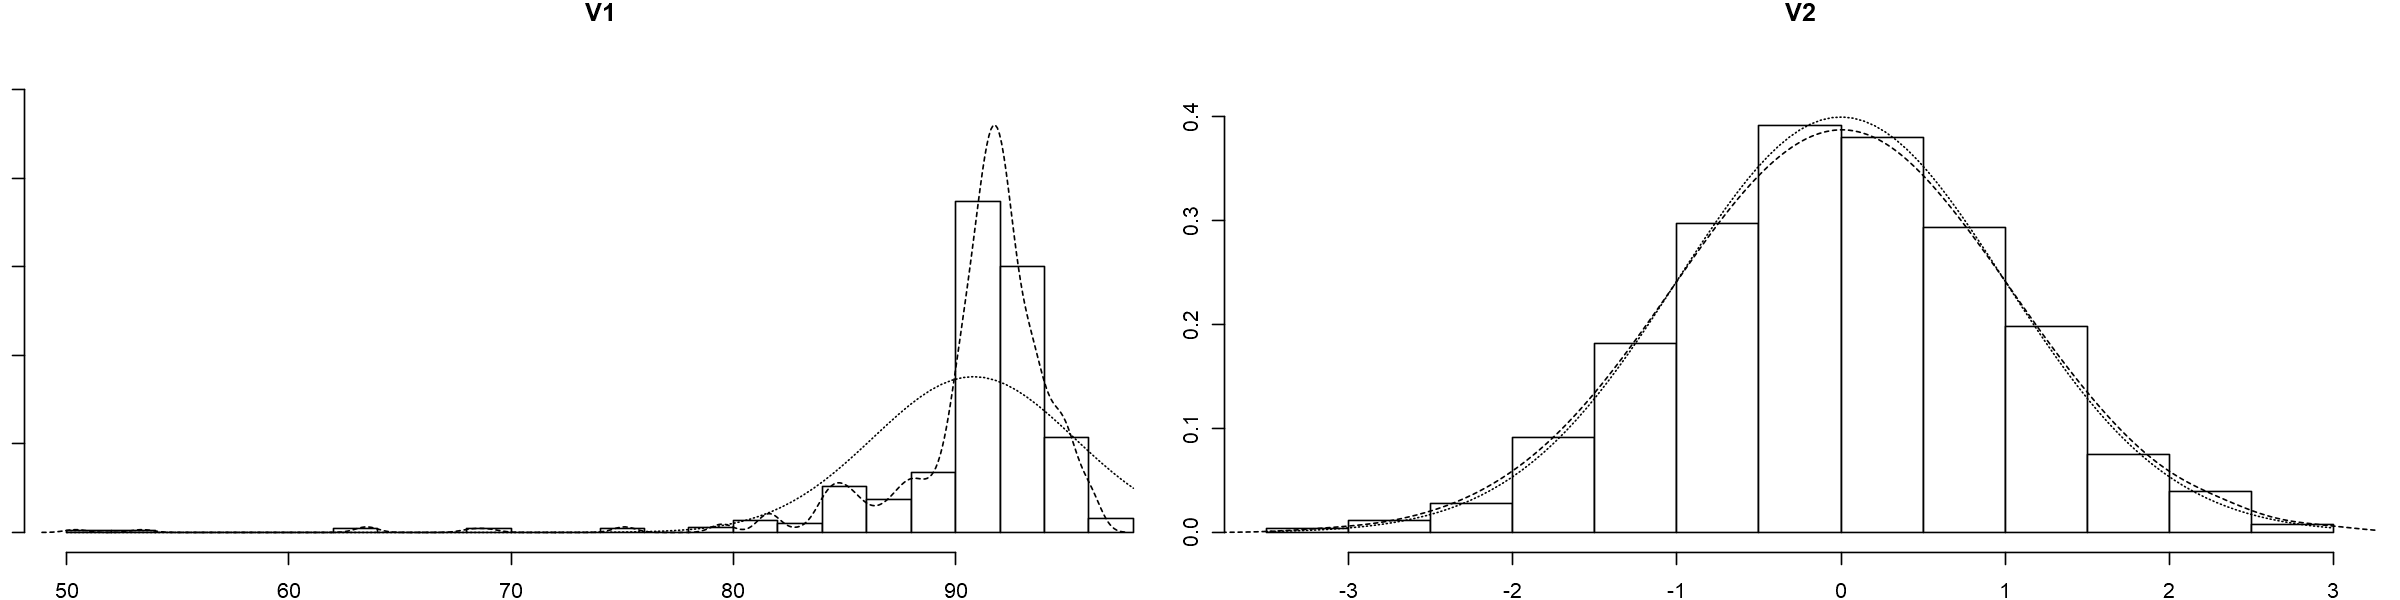

In [13]:
setPlotSize(20,5)
norm <- bestNormalize(raw$FFMC) 
print(norm$chosen_transform)
compare <- cbind(raw$FFMC,norm$x.t)
describe(compare)
multi.hist(compare,ncol=2)

#store the normalized column
FFMC.norm <- norm$x.t

DMC

orderNorm Transformation with 505 nonmissing obs and ties
 - 211 unique values 
 - Original quantiles:
   0%   25%   50%   75%  100% 
  2.4  69.7 108.3 142.4 291.3 


vars n   mean          sd         median        trimmed       mad       
X1 1    505  1.111246e+02 63.7606159 108.300000000  1.067635e+02 51.7427400
X2 2    505 -1.990866e-04  0.9988365  -0.004963641 -4.730323e-05  0.9995794
   min       max        range      skew        kurtosis    se        
X1  2.400000 291.300000 288.900000  0.55779755  0.21511740 2.83731017
X2 -3.093186   3.093186   6.186373 -0.00400326 -0.07575936 0.04444764

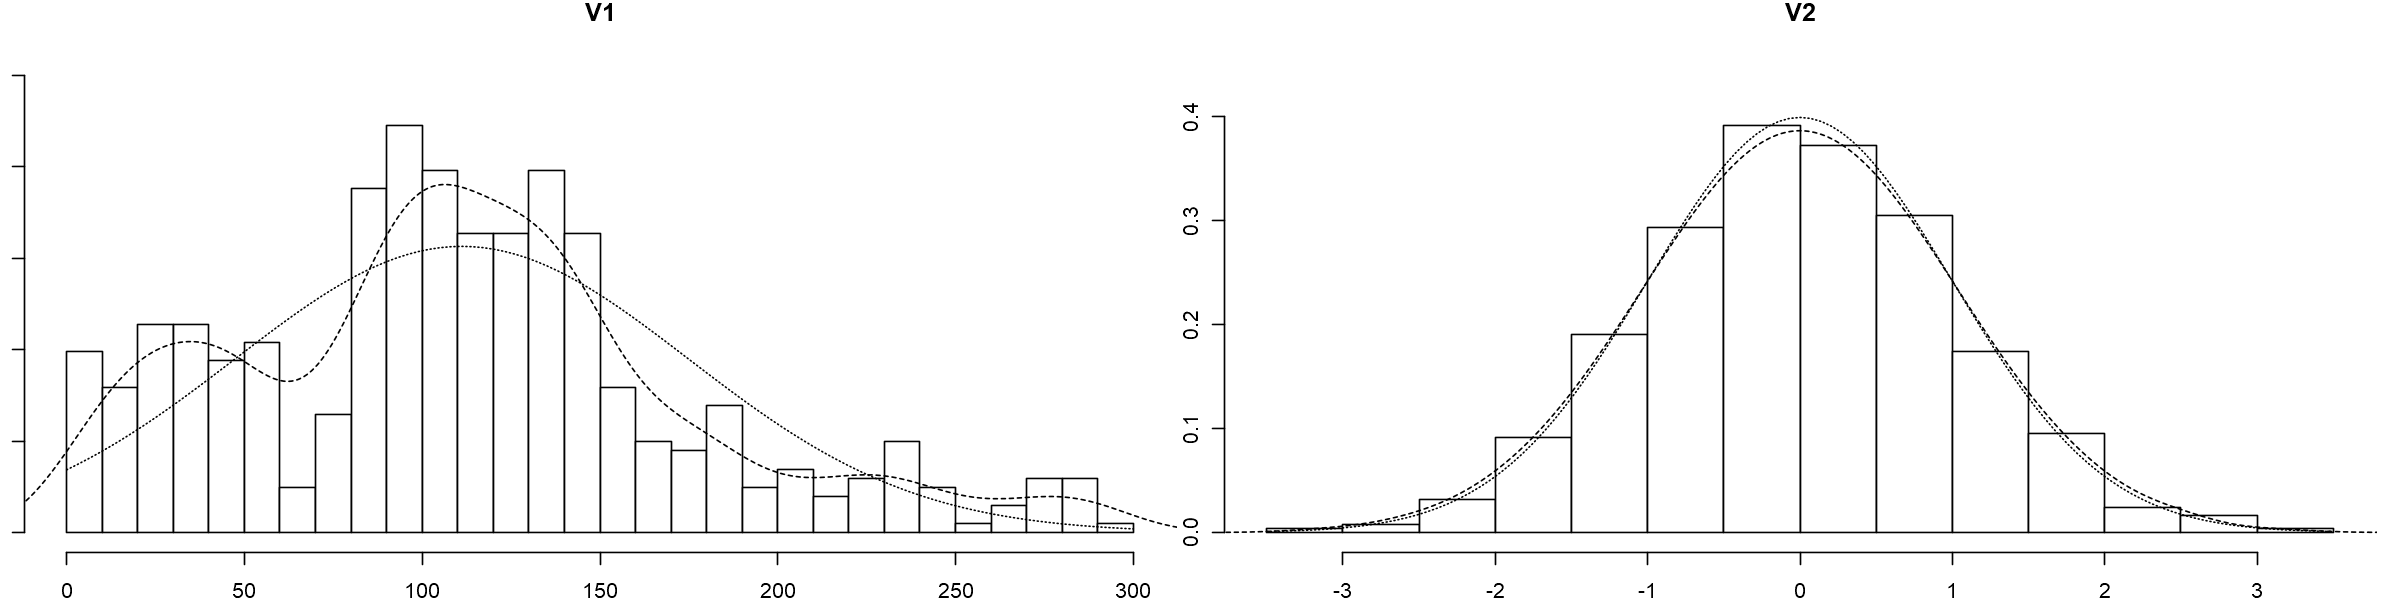

In [14]:
norm <- bestNormalize(raw$DMC) 
print(norm$chosen_transform)
compare <- cbind(raw$DMC,norm$x.t)
describe(compare)
multi.hist(compare, ncol=2)

#store the normalized column
DMC.norm <- norm$x.t

DC

orderNorm Transformation with 505 nonmissing obs and ties
 - 214 unique values 
 - Original quantiles:
   0%   25%   50%   75%  100% 
  7.9 442.1 664.2 714.3 860.6 


vars n   mean          sd          median       trimmed      mad       
X1 1    505  5.500135e+02 247.0871123 6.642000e+02  5.81223e+02 118.904520
X2 2    505 -2.260834e-04   0.9989163 2.481813e-03 -6.64413e-06   1.003259
   min       max        range      skew         kurtosis    se         
X1  7.900000 860.600000 852.700000 -1.108347907 -0.22122363 10.99523219
X2 -3.093186   3.093186   6.186373 -0.004695894 -0.07335791  0.04445119

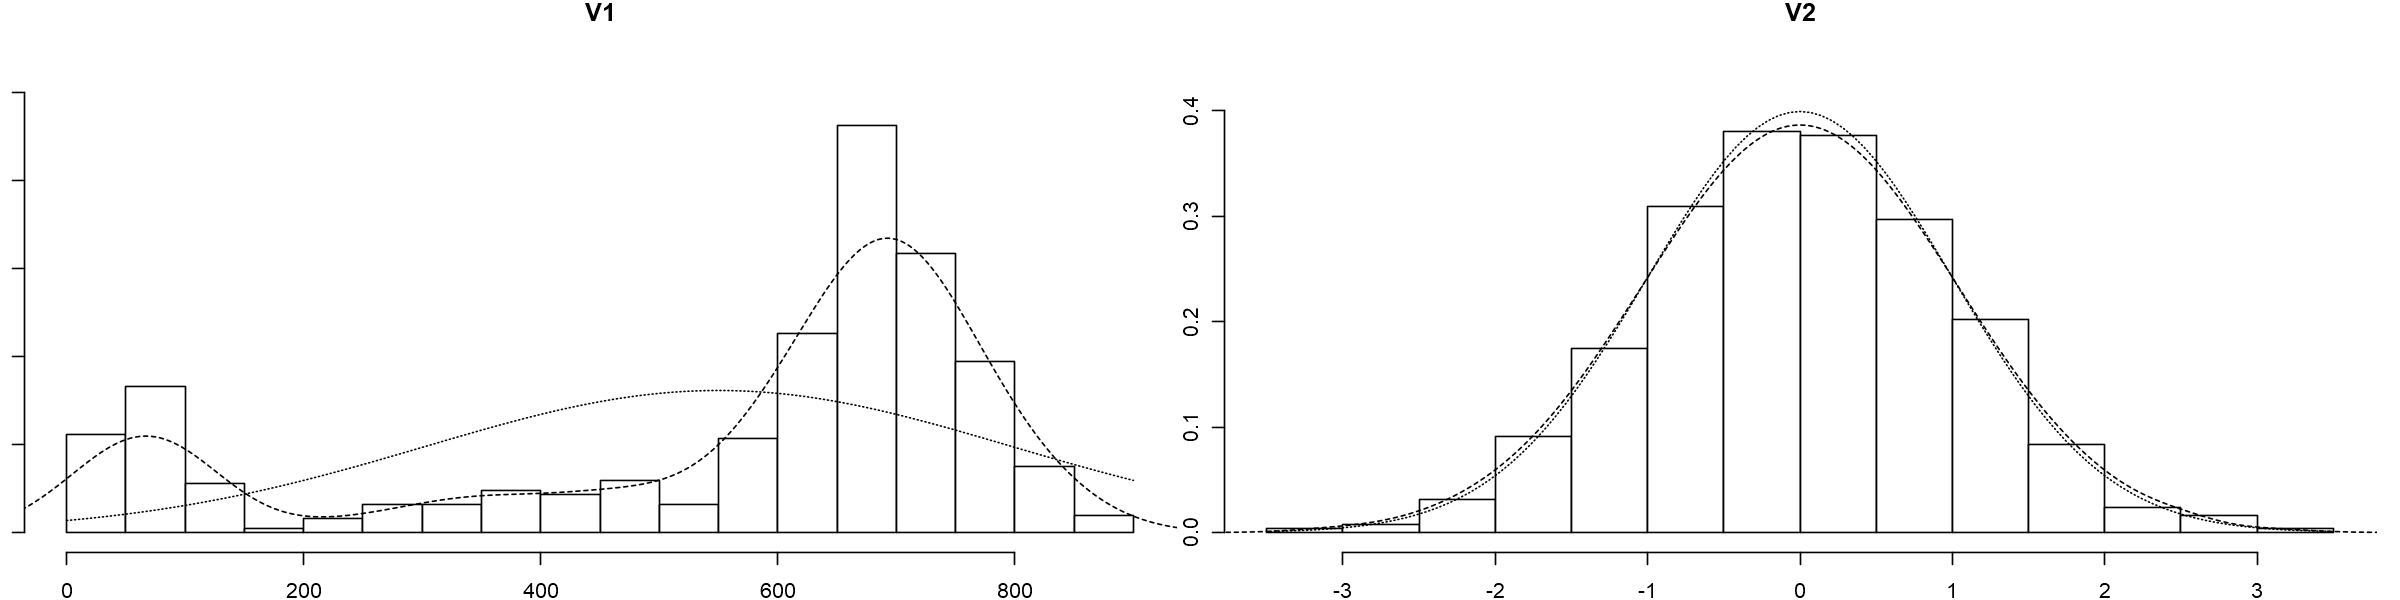

In [15]:
norm <- bestNormalize(raw$DC) 
print(norm$chosen_transform)
compare <- cbind(raw$DC,norm$x.t)
describe(compare)
multi.hist(compare,ncol=2)

#store the normalized column
DC.norm <- norm$x.t

ISI

orderNorm Transformation with 505 nonmissing obs and ties
 - 118 unique values 
 - Original quantiles:
  0%  25%  50%  75% 100% 
 0.4  6.5  8.4 11.0 56.1 


vars n   mean         sd        median       trimmed      mad      min      
X1 1    505 9.0800000000 4.5628434  8.400000000 8.7790123457 3.113460  0.400000
X2 2    505 0.0001786999 0.9984316 -0.002481813 0.0001614839 1.007898 -2.881299
   max       range     skew        kurtosis    se        
X1 56.100000 55.700000 2.564083721 21.46496159 0.20304387
X2  3.093186  5.974485 0.004692972 -0.07941059 0.04442962

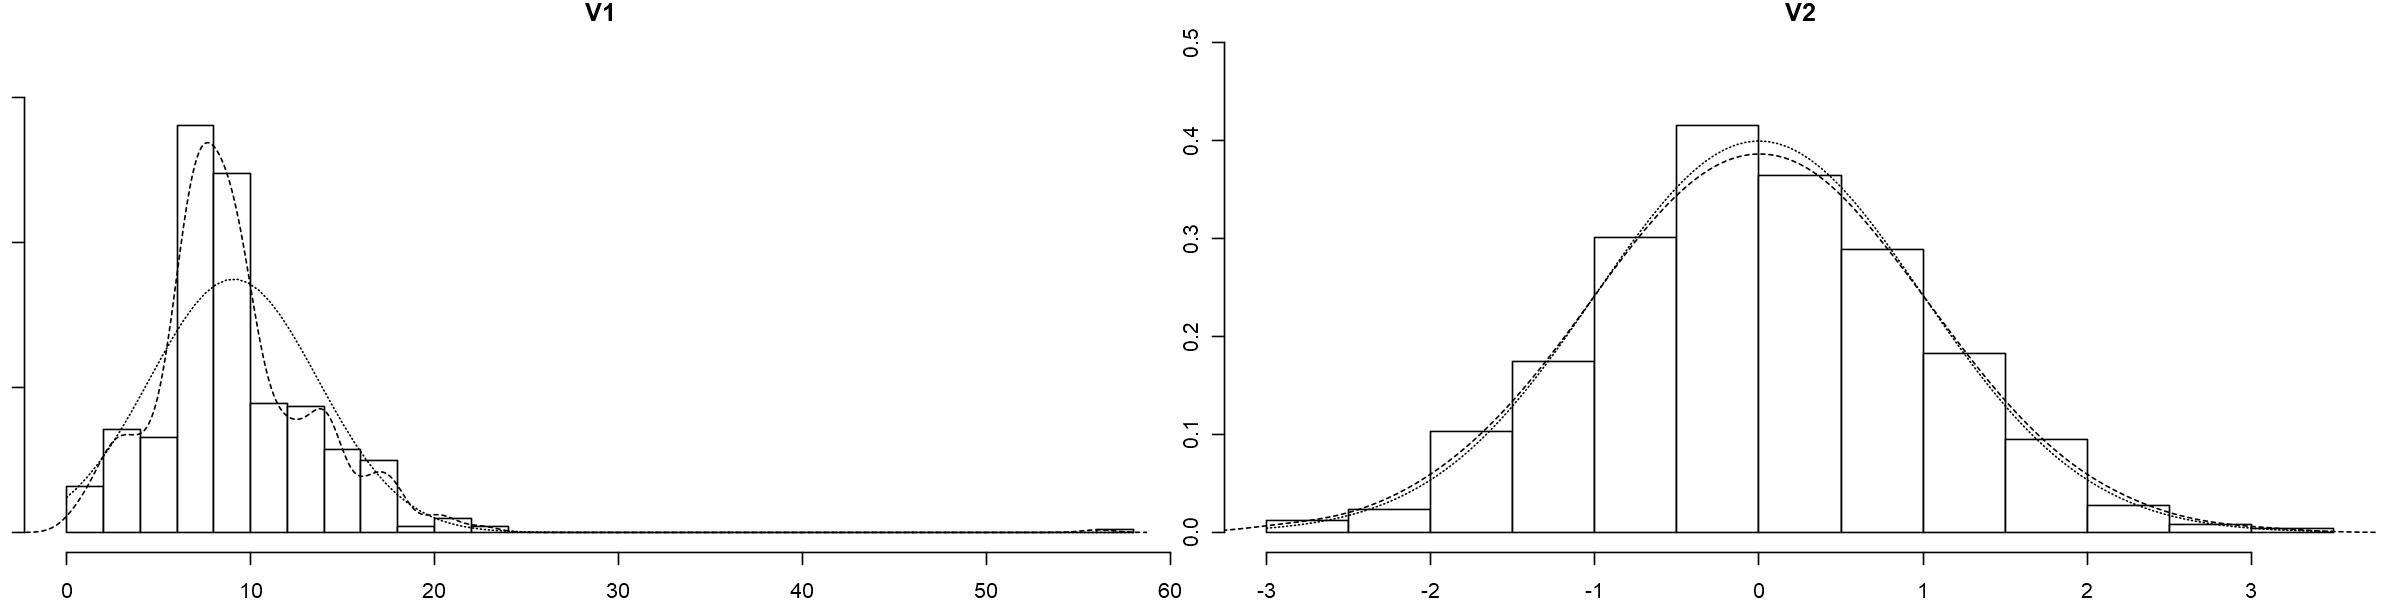

In [16]:
norm <- bestNormalize(raw$ISI) 
print(norm$chosen_transform)
compare <- cbind(raw$ISI,norm$x.t)
describe(compare)
multi.hist(compare,ncol=2)

#store the normalized column
ISI.norm <- norm$x.t

rain

Standardized I(x) Transformation with 505 nonmissing obs.:
 Relevant statistics:
 - mean (before standardization) = 0.02217822 
 - sd (before standardization) = 0.2994426 


vars n   mean          sd        median    trimmed   mad min       max     
X1 1    505  2.217822e-02 0.2994426  0.000000  0.000000 0    0.000000  6.40000
X2 2    505 -1.284541e-17 1.0000000 -0.074065 -0.074065 0   -0.074065 21.29898
   range    skew     kurtosis se        
X1  6.40000 19.46876 405.8137 0.01332502
X2 21.37304 19.46876 405.8137 0.04449942

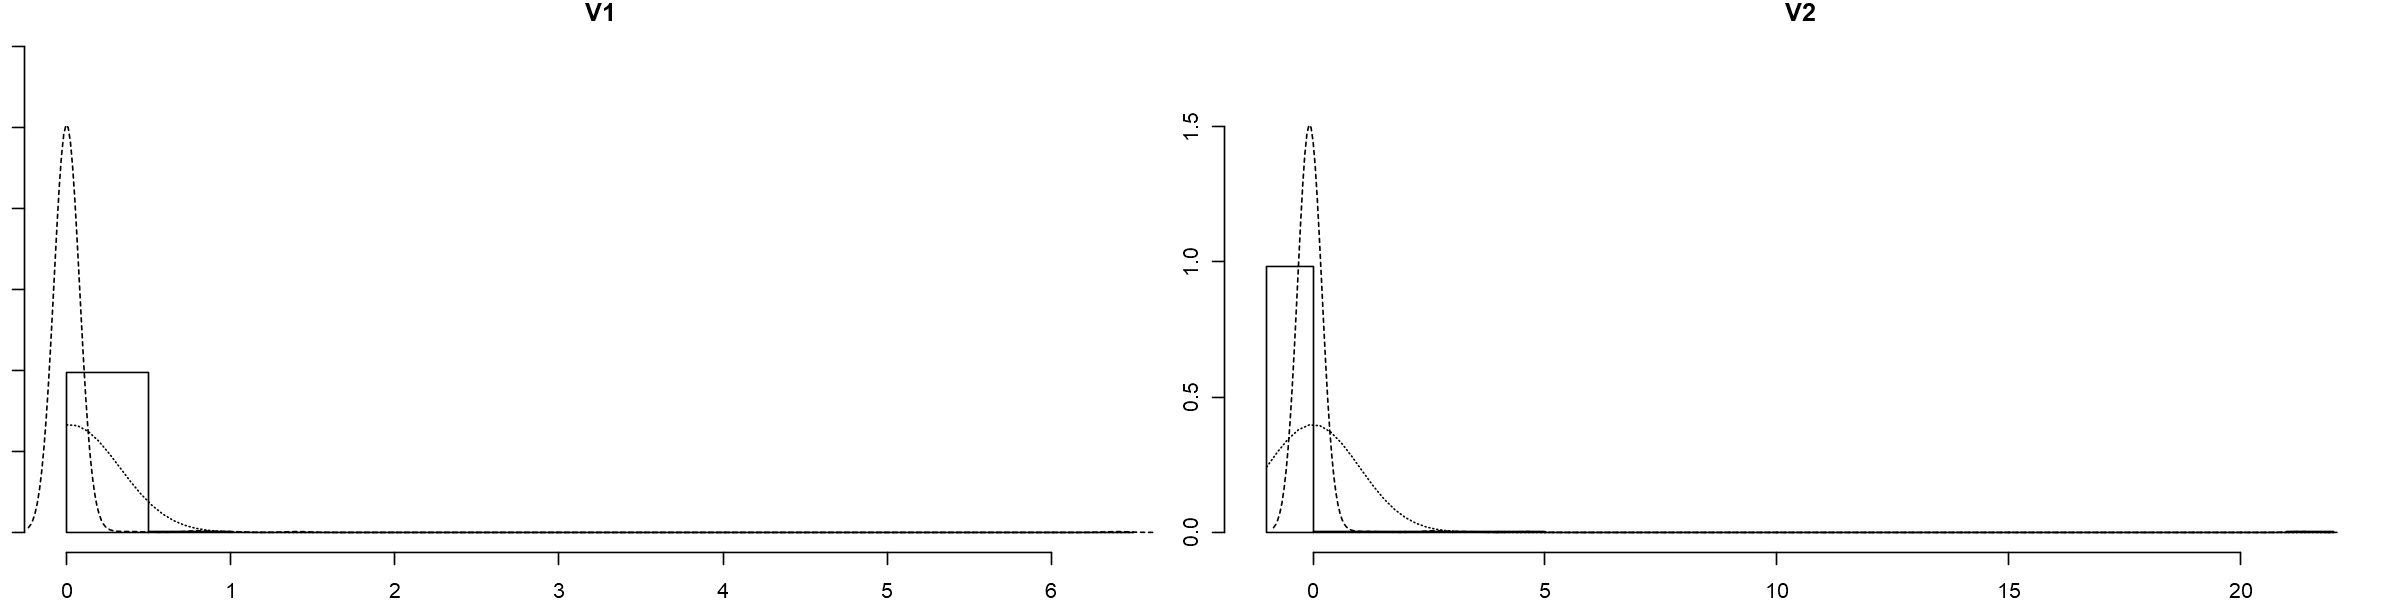

In [17]:
norm <- bestNormalize(raw$rain) 
print(norm$chosen_transform)
compare <- cbind(raw$rain,norm$x.t)
describe(compare)
multi.hist(compare,ncol=2)

vars n   mean  sd    median trimmed mad min max   range skew  
         1    505 0.022 0.299 0      0       0   0   6.400 6.400 19.469
logRain  2    505 0.011 0.110 0      0       0   0   2.001 2.001 13.923
sqrtRain 3    505 0.016 0.148 0      0       0   0   2.530 2.530 12.272
         kurtosis se   
         405.814  0.013
logRain  225.583  0.005
sqrtRain 178.101  0.007

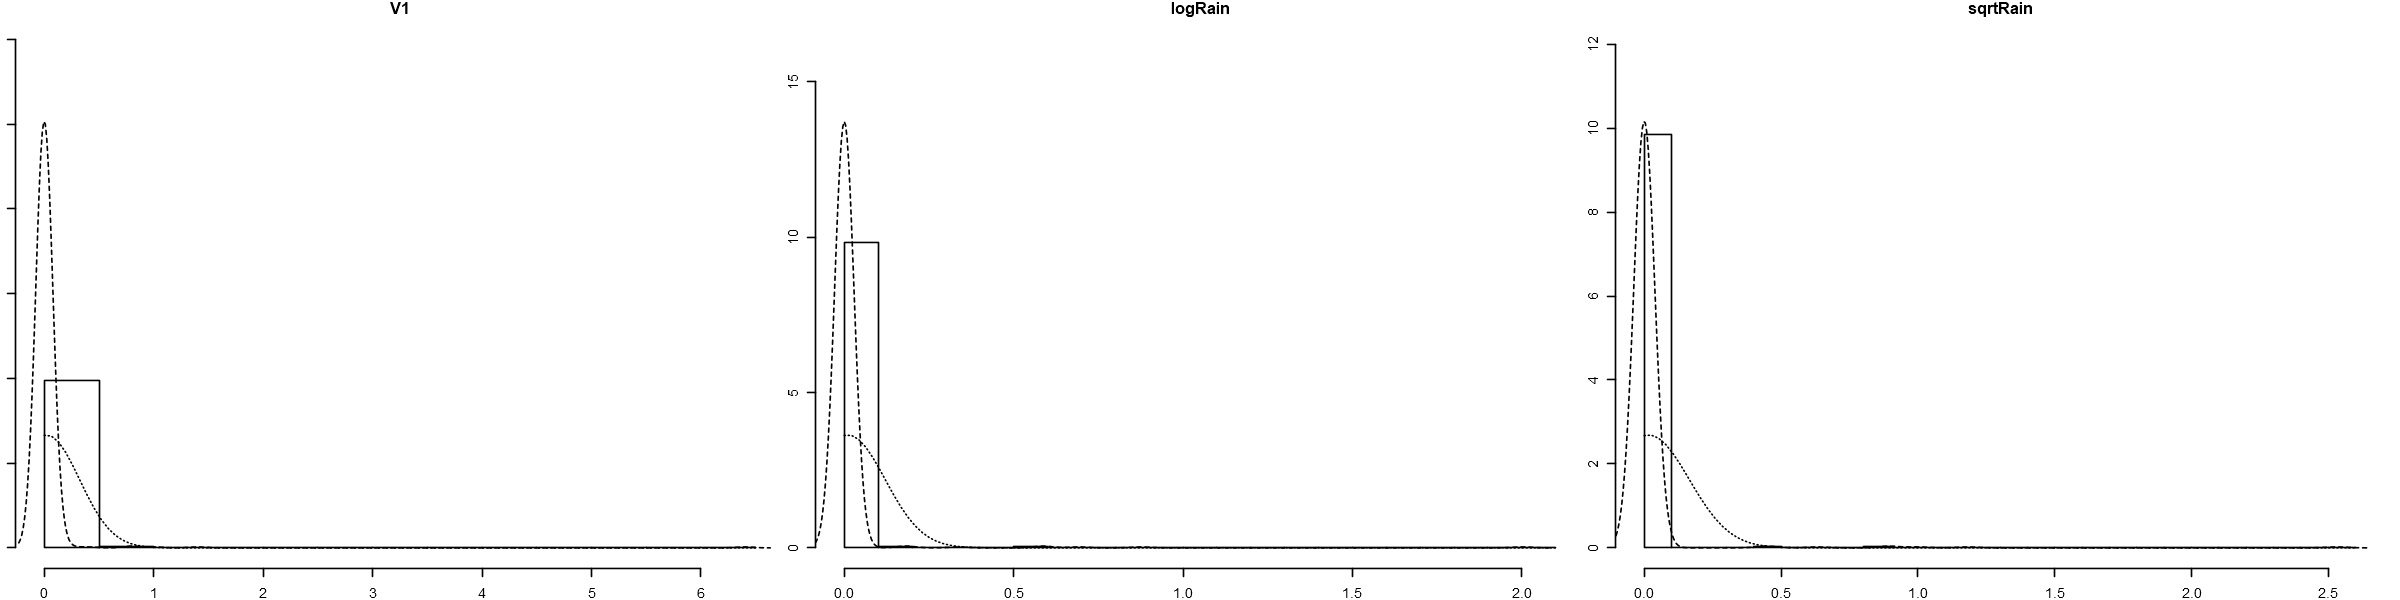

In [18]:
logRain <- log(raw$rain+1)
sqrtRain <- sqrt(raw$rain)
join <- cbind(raw$rain, logRain, sqrtRain)
round(describe(join),3)
multi.hist(join,ncol=3)

#store the normalized column
rain.norm <- sqrtRain

area

Standardized sqrt(x + a) Transformation with 505 nonmissing obs.:
 Relevant statistics:
 - a = 0 
 - mean (before standardization) = 1.547573 
 - sd (before standardization) = 2.176655 


vars n   mean         sd       median     trimmed    mad       min      
X1 1    505 7.123426e+00 17.74418  0.4300000  2.7931111 0.6375180  0.000000
X2 2    505 5.657002e-17  1.00000 -0.4097247 -0.2072478 0.4466514 -0.710987
   max        range      skew     kurtosis  se        
X1 185.760000 185.760000 5.031543 34.410661 0.78960571
X2   5.550631   6.261618 1.930392  4.486975 0.04449942

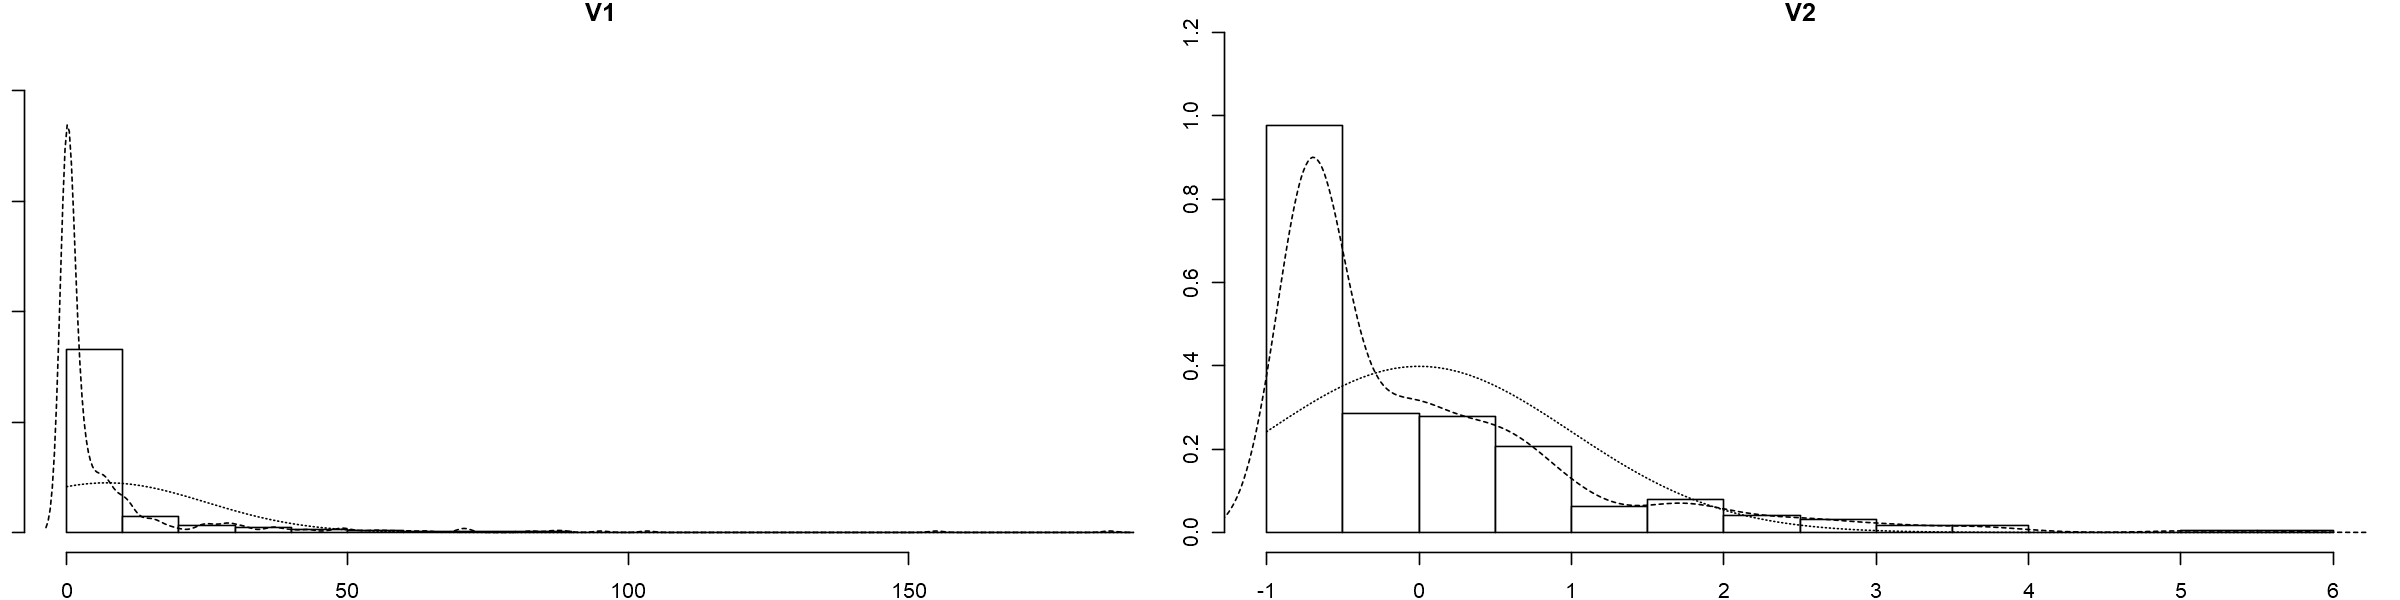

In [19]:
norm <- bestNormalize(raw$area) 
print(norm$chosen_transform)
compare <- cbind(raw$area,norm$x.t)
describe(compare)
multi.hist(compare,ncol=2)

vars n   mean  sd     median trimmed mad   min max     range   skew 
         1    505 7.123 17.744 0.430  2.793   0.638 0   185.760 185.760 5.032
logArea  2    505 1.041  1.282 0.358  0.832   0.530 0     5.230   5.230 1.010
sqrtArea 3    505 1.548  2.177 0.656  1.096   0.972 0    13.629  13.629 1.930
         kurtosis se   
         34.411   0.790
logArea  -0.033   0.057
sqrtArea  4.487   0.097

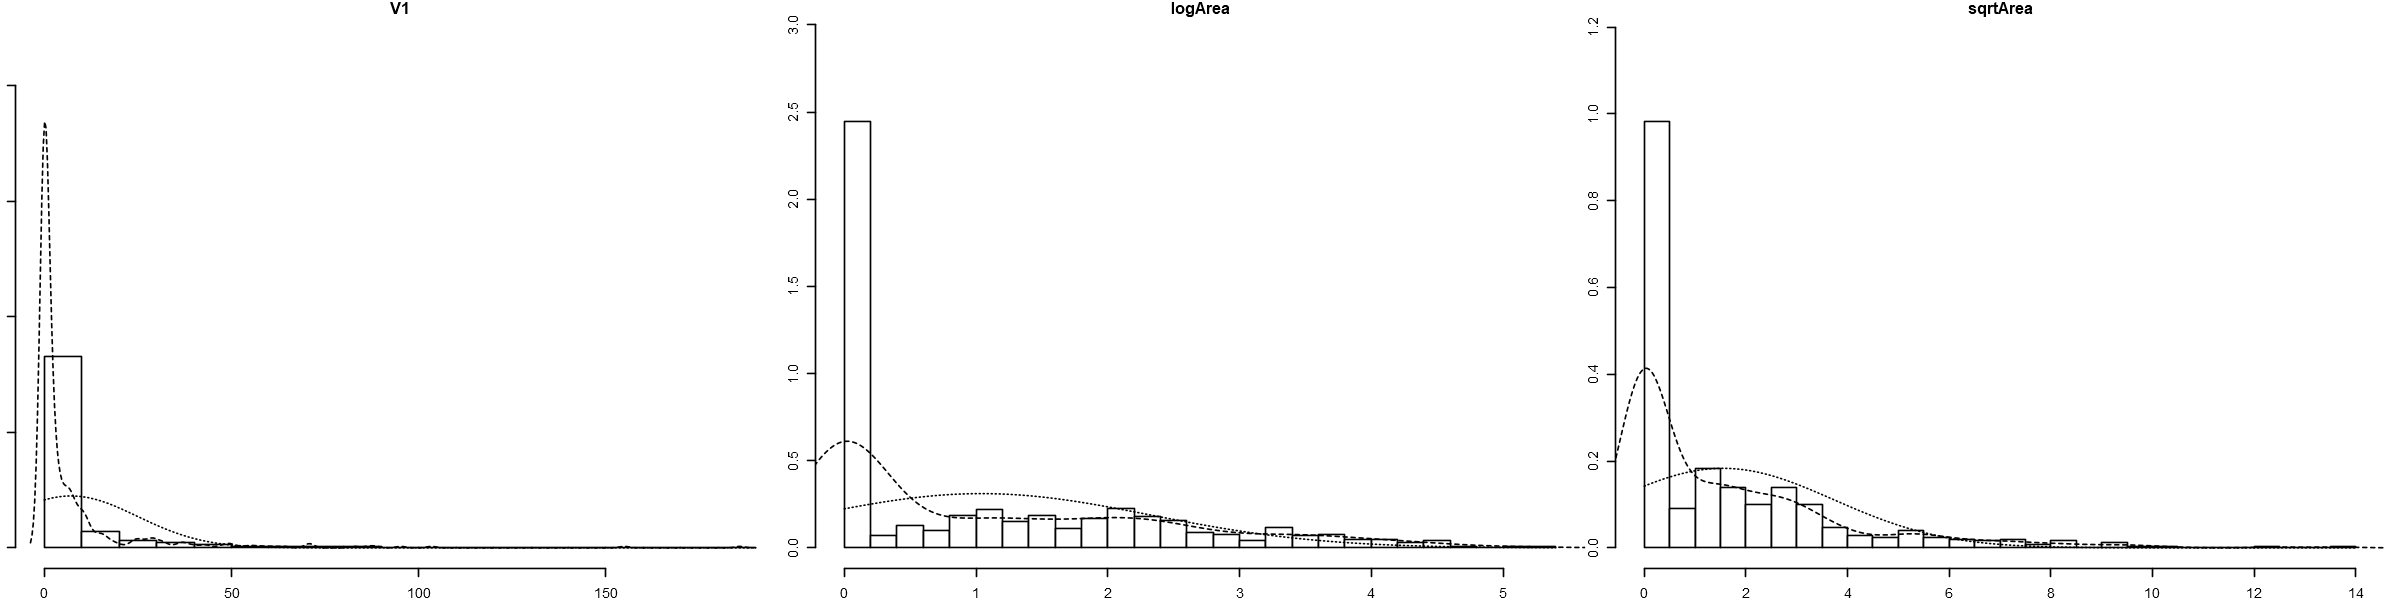

In [20]:
logArea <- log(raw$area+1)
sqrtArea <- sqrt(raw$area)
join <- cbind(raw$area, logArea, sqrtArea)
round(describe(join),3)
multi.hist(join,ncol=3)

#store the normalized column
area.norm <- logArea

I use bestNormalize package to find the best transformation to make each skewed column becomes normal. The package gives orderNorm as the best normalizer for every column except rain and area (FFMC,DMC,DC,ISI). It failed to reduce skewness and kurtosis of rain and area since most of the data in the column are zero.

So I tried two normalizer which are log and square root transformation, and both transformations can lower rain's skewness and kurtosis value even though the values are still considered high. In conclusion, I believe the best transformation to normalize rain is square root transformation.

As for area, both transformation can reduce area's skewness and kurtosis and log transformation gives the best skewness and kurtosis value. So, I can transform area to get a more normalized distribution.

The rain and area distribution have a extreme number of zero value, so I can create new categorical features derived from both features. For rain, I believe its better to create a new column that separate between rainy points (rain > 0) and non rainy points (rain = 0). Additionally, I can separate between zero burnt forests (area = 0) and burnt forests (area>0). The burnt forests category can be also grouped to couple ordinal values (small, medium, large, very large burnt area)  

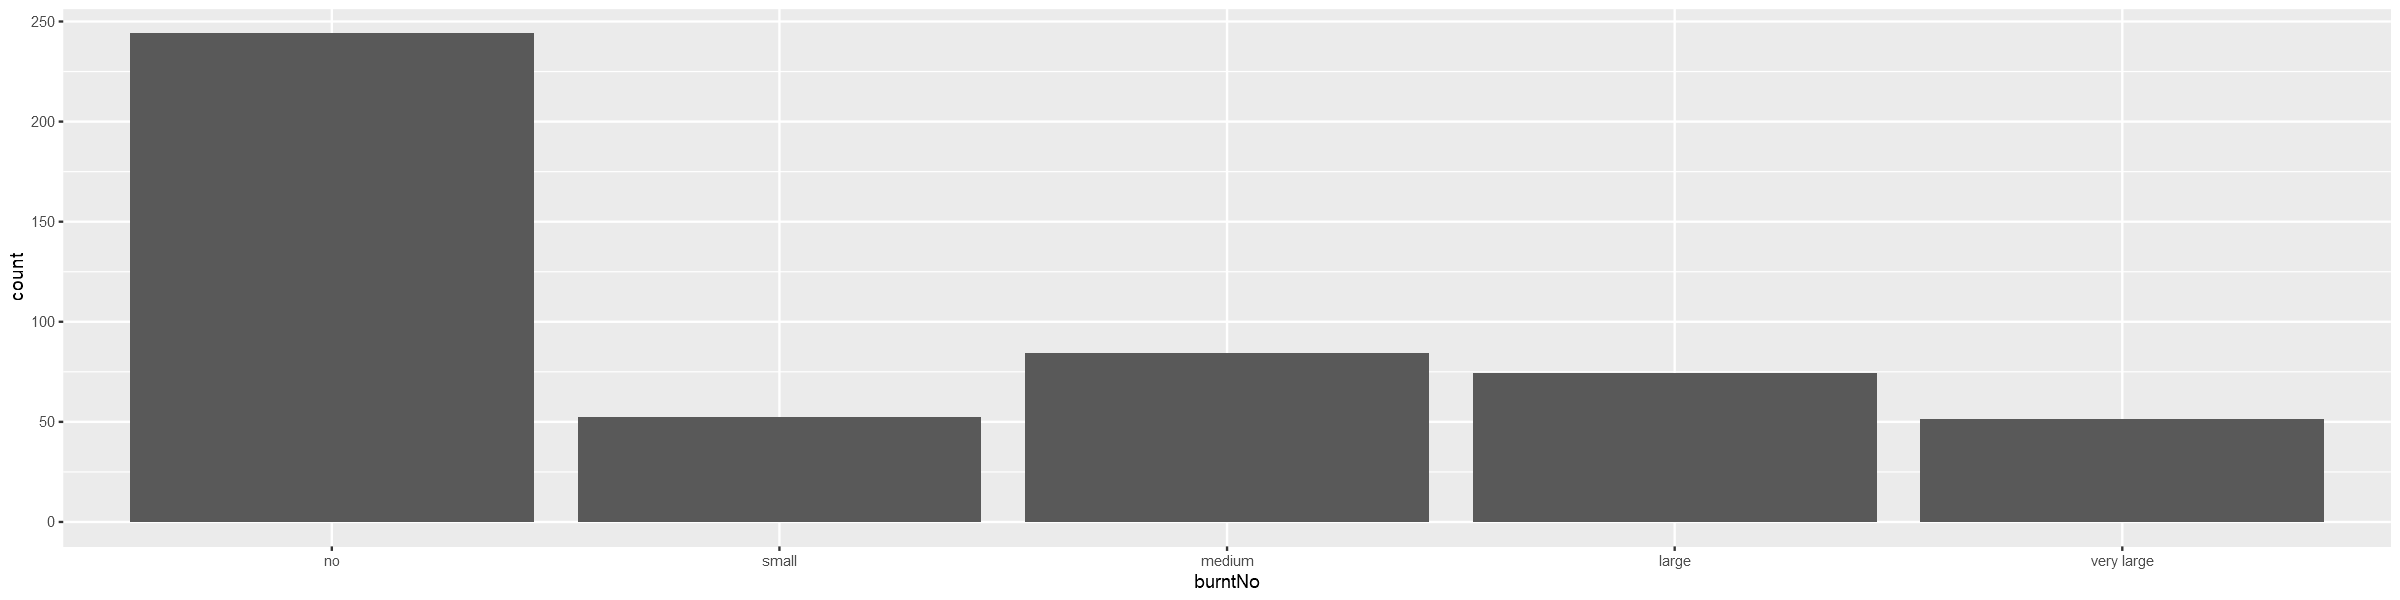

In [21]:
raw$burntNo <- factor(ifelse(area.norm == 0, 'no',
                      ifelse(area.norm < 1, 'small',
                      ifelse(area.norm<2,'medium',
                      ifelse(area.norm<3,'large','very large')))),
                    levels=c('no','small','medium','large','very large'))
ggplot(raw,aes(burntNo)) + geom_bar()

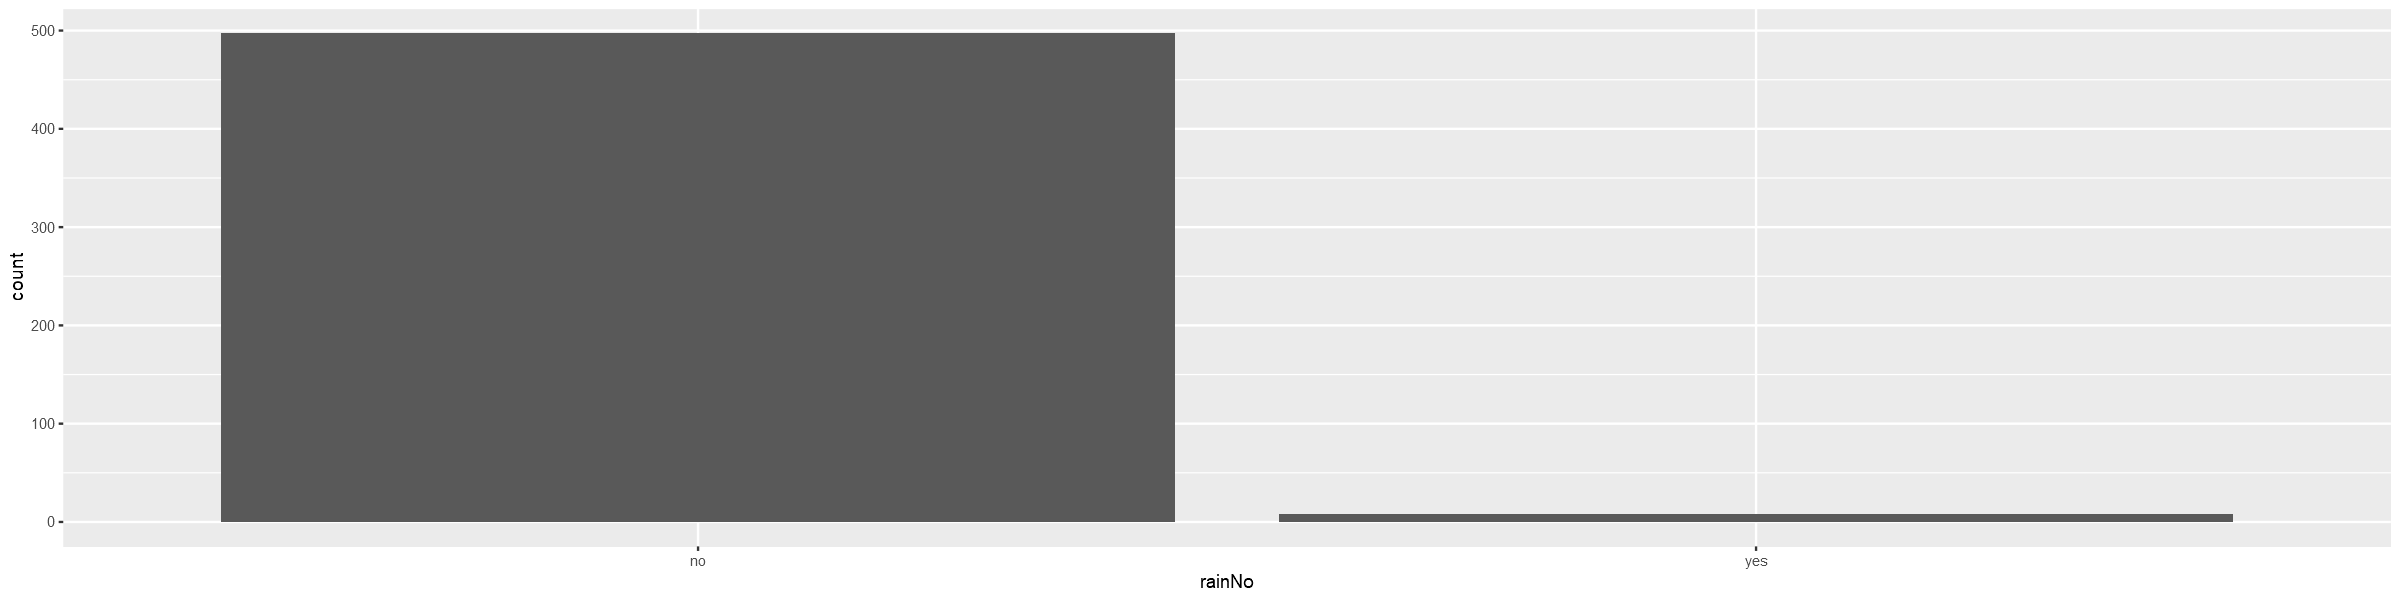

In [22]:
raw$rainNo <- factor(ifelse(rain.norm == 0, 'no', 'yes'), levels=c('no','yes'))
ggplot(raw,aes(rainNo)) + geom_bar()

### Investigate Column Combinations (Multivariate Analysis)

Correlation Plot Function
This is the DIY correlation plot provided in the tutoria. I changed a little bit for coloring scatter plots and showing correlation values 

In [23]:
# DIY correlation plot
# http://stackoverflow.com/questions/31709982/how-to-plot-in-r-a-correlogram-on-top-of-a-correlation-matrix
# there's some truth to the quote that modern programming is often stitching together pieces from SO 

colorRange <- c('#69091e', '#e37f65', 'white', '#aed2e6', '#042f60')
## colorRamp() returns a function which takes as an argument a number
## on [0,1] and returns a color in the gradient in colorRange
myColorRampFunc <- colorRamp(colorRange)

panel.cor <- function(w, z, ...) {
    correlation <- round(cor(w, z),3)

    ## because the func needs [0,1] and cor gives [-1,1], we need to shift and scale it
    col <- rgb(myColorRampFunc((1 + correlation) / 2 ) / 255 )

    ## square it to avoid visual bias due to "area vs diameter"
    radius <- sqrt(abs(correlation))
    radians <- seq(0, 2*pi, len = 50) # 50 is arbitrary
    x <- radius * cos(radians)
    y <- radius * sin(radians)
    ## make them full loops
    x <- c(x, tail(x,n=1))
    y <- c(y, tail(y,n=1))

    ## trick: "don't create a new plot" thing by following the
    ## advice here: http://www.r-bloggers.com/multiple-y-axis-in-a-r-plot/
    ## This allows
    par(new=TRUE)
    plot(0, type='n', xlim=c(-1,1), ylim=c(-1,1), axes=FALSE, asp=1)
    polygon(x, y, border=col, col=col)
    text(0, 0, correlation)
}

# usage e.g.:
# pairs(mtcars, upper.panel = panel.cor)

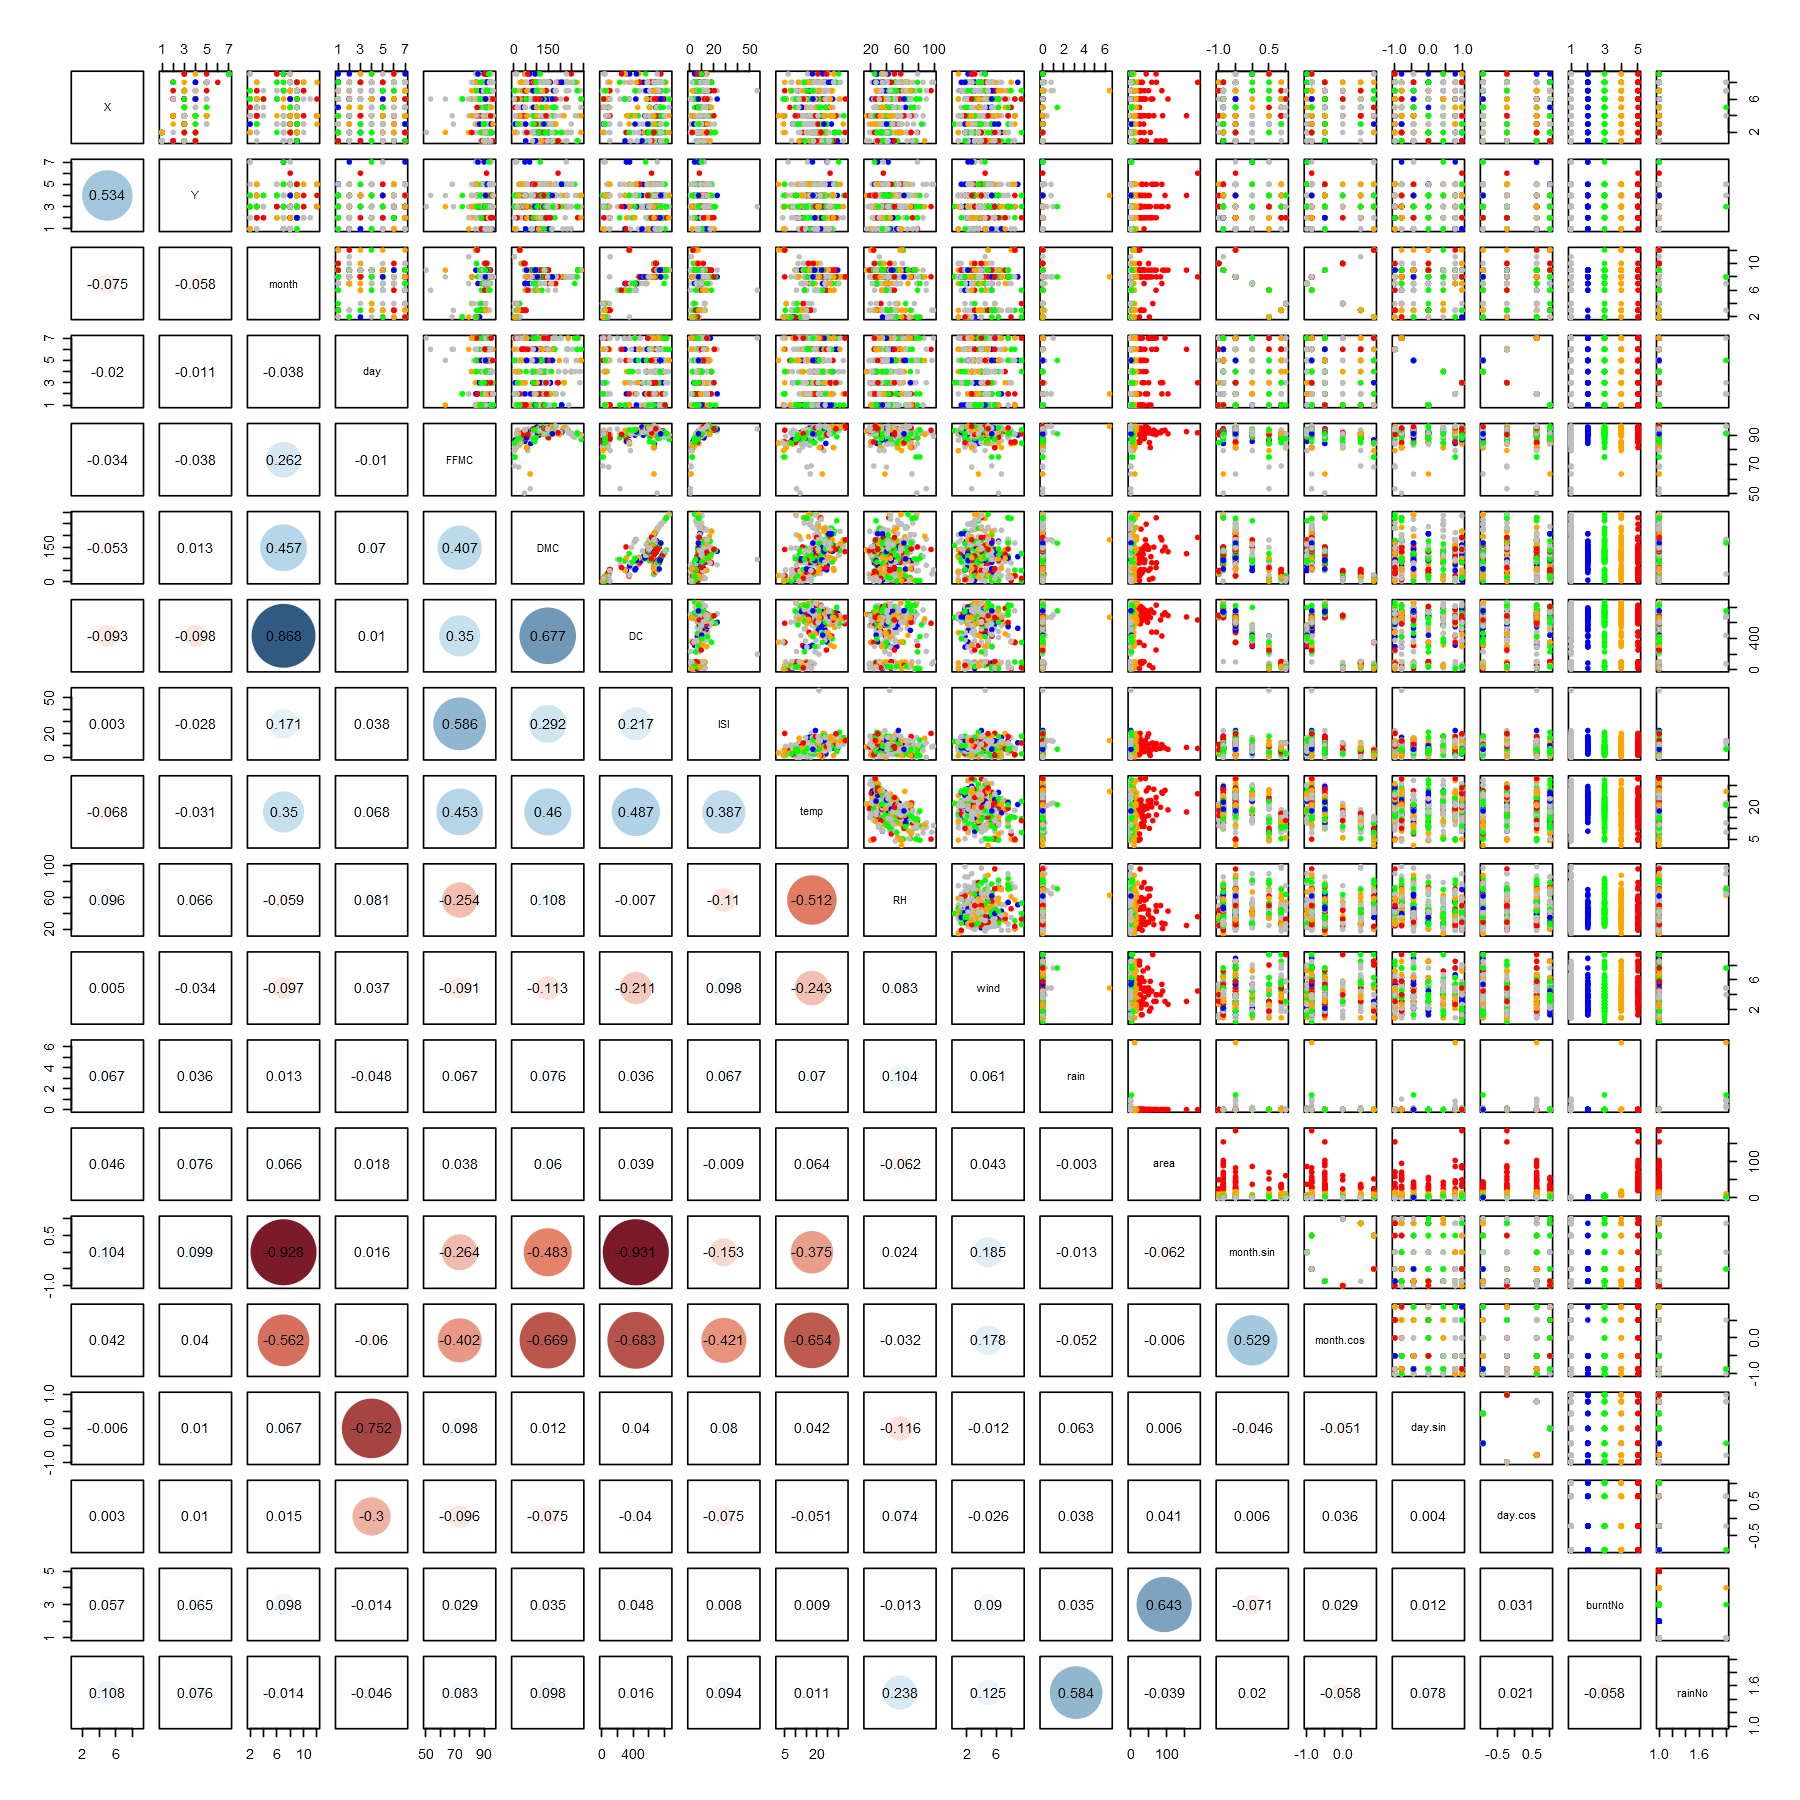

In [24]:
setPlotSize(15,15)
# color for different burnt area size
my_cols <- c('grey',"blue", "green", "orange",'red') 
pairs(raw,lower.panel=panel.cor, col=my_cols[raw$burntNo], pch = 19,  cex = 0.5,)

The correlation matrix shows that:
* From all variable, no varible shows strong correlation to burnt area. There is only small positive correlation between area and month along with small negative correlation between area and RH.
* FFMC, DMC, DC, ISI, temp are all strongly positive correlated to each other, with the highest correlated variables are between DMC with DC and FFMC with ISI.
* month has positive correlation to each of FFMC, DMC, DC, ISI, temp, with DC as the highest correlated column. Whereas, both its derived columns has negative correlation to those columns and correlation between month.sin with DC is the highest negative correlation 
* RH has strong negative correlation with temp and quite negative correlation with FFMC. Moreover, it has positive correlation with rain.
* Wind has quite strong negative correlation to temp and DC. It also has little correlation to rain, DMC and month. 
* there is very strong positive correlation between X and Y.
* The correlations between rain and rainNo because the new categorical variable are derived from the rain. This also applies to area with areaNo, month with month.sin and month.cos, as well as day with day.sin and day.cos

Top positive correlations (more than .5) are shown between:
* month and DC
* DMC and DC
* ISI and FFMC
* X and Y

Whereas top negative correlation (less than -.5) is shown between:
* DC and month.sin
* DC and month.cos
* DMC and month cos
* temp and month.cos
* temp and RH

#### Show each variable's correlation
Predictors' Correlation to the target variable 

Using X, Y, month, day, burntNo, rainNo as id variables



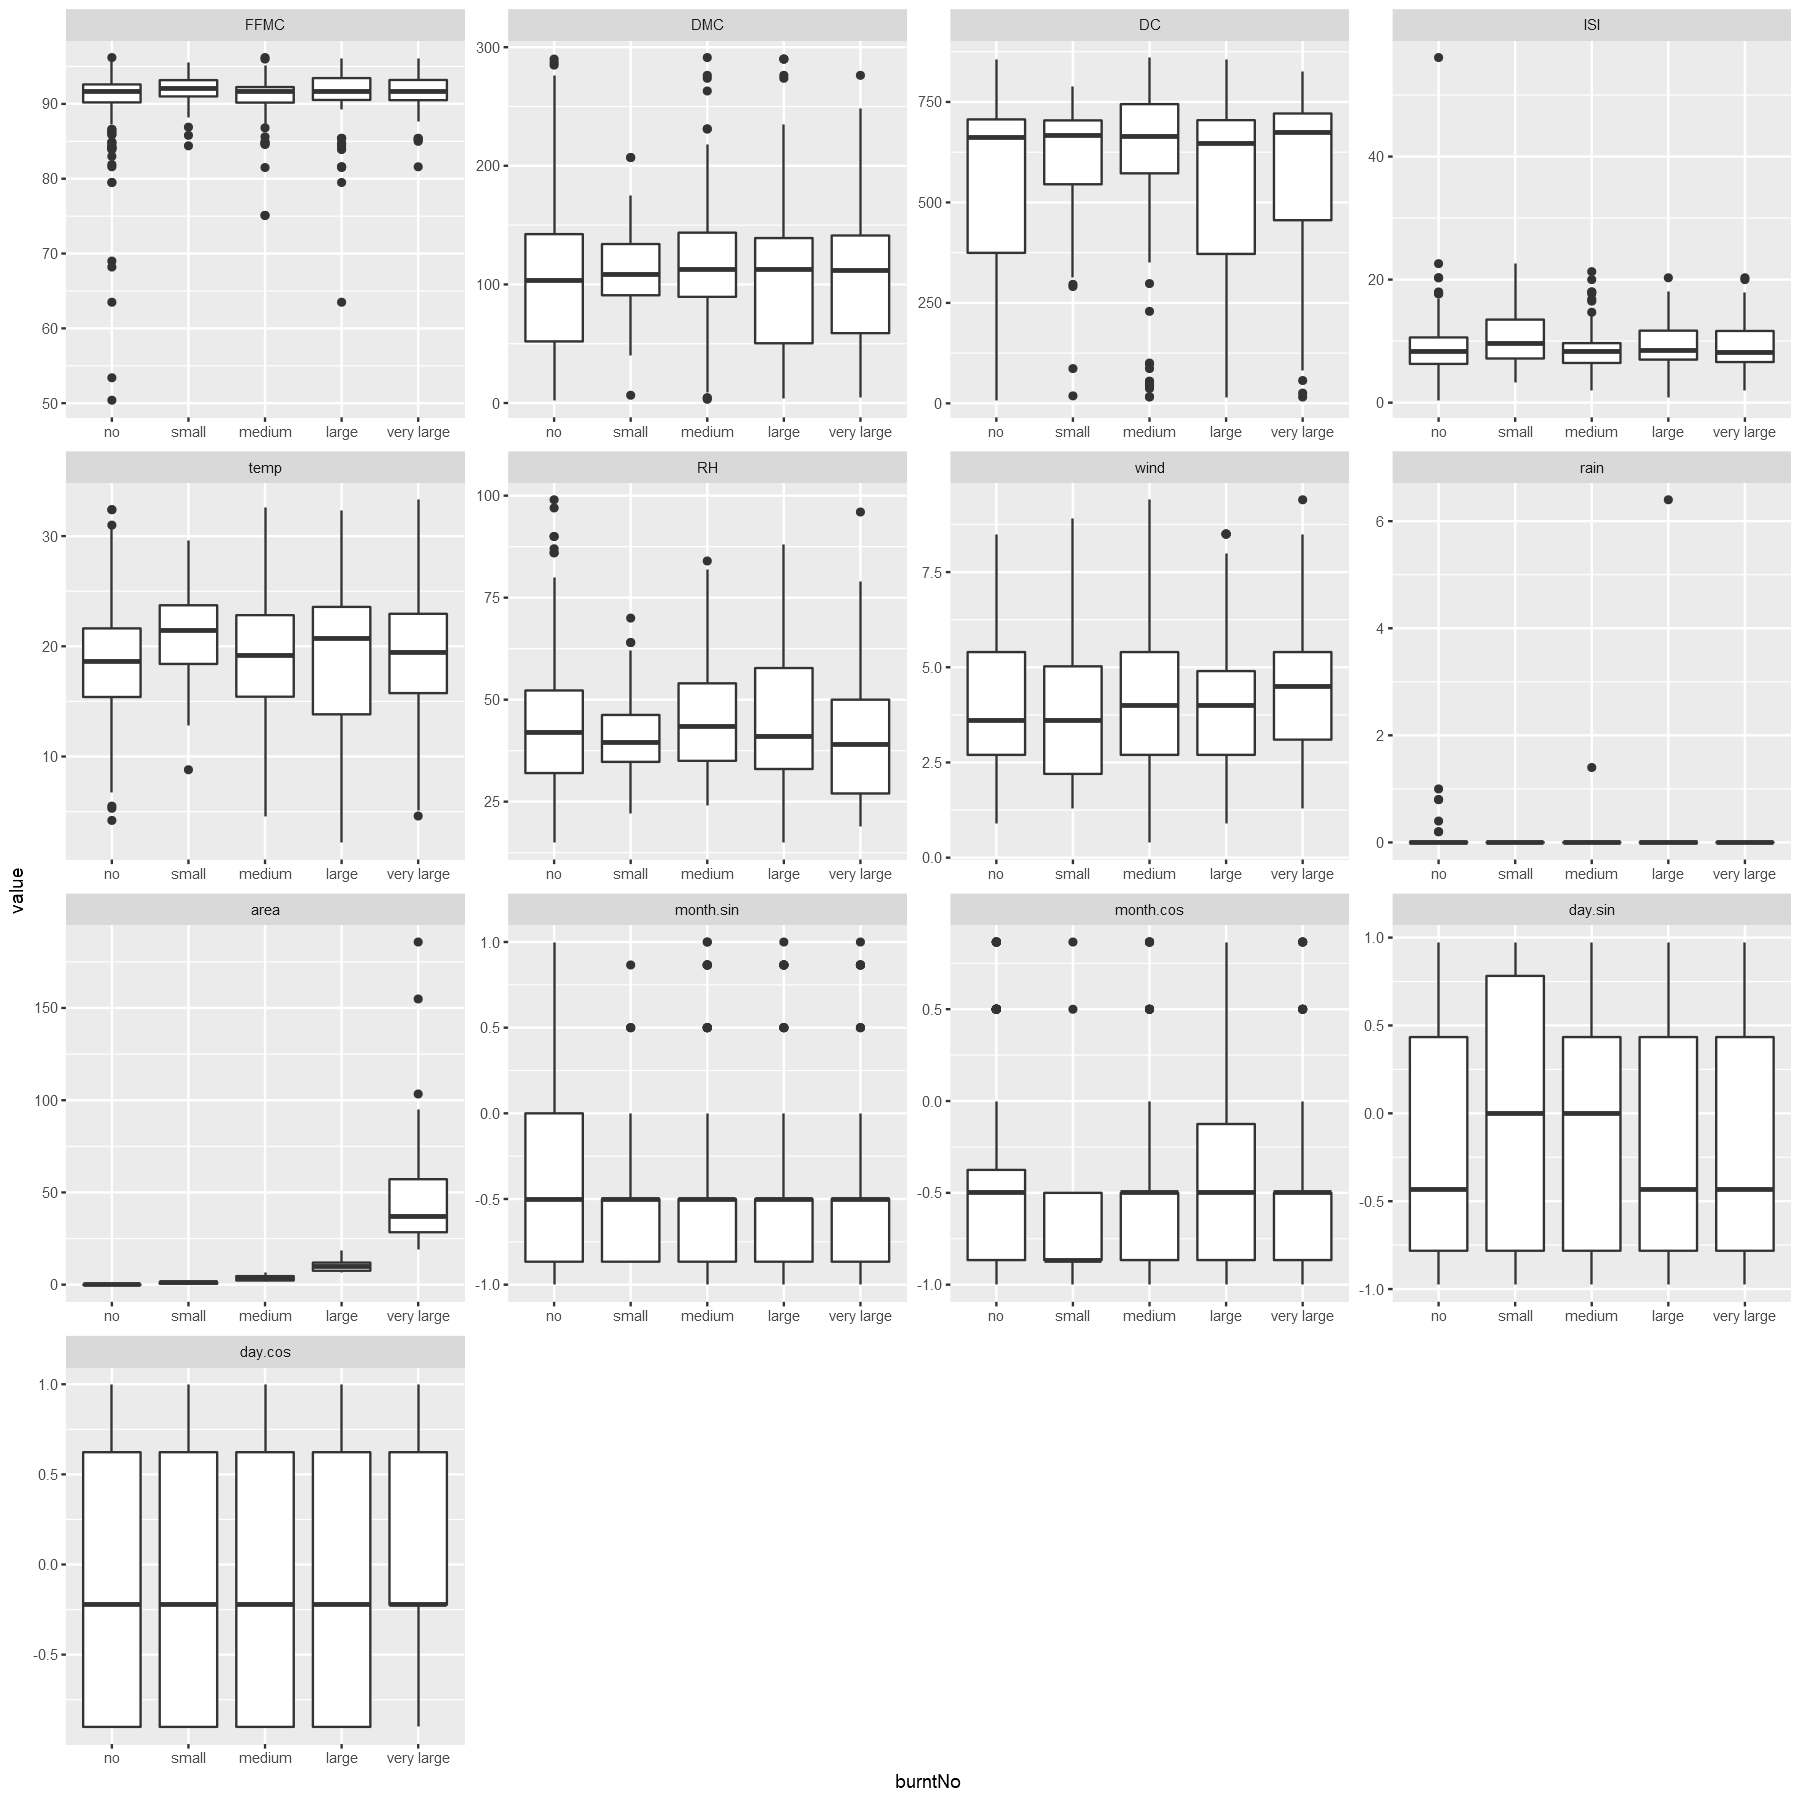

In [25]:
melt(as.data.frame(raw)) %>%
ggplot(aes(x = burntNo,y = value)) +
facet_wrap(~variable, scales="free") +
geom_boxplot() +
scale_y_continuous(labels=function (n) {format(n, scientific=FALSE)})

As explained by the area correlation values to other columns, no columns look correlated with area (in this graph I used grouped burnt area). But, there is one which is wind that looks increased when there are larger burnt area. As it can be seen in the wind face, median of the boxplots is slowly increased on higher the burnt forest area.

Correlation Between Continuous Variables

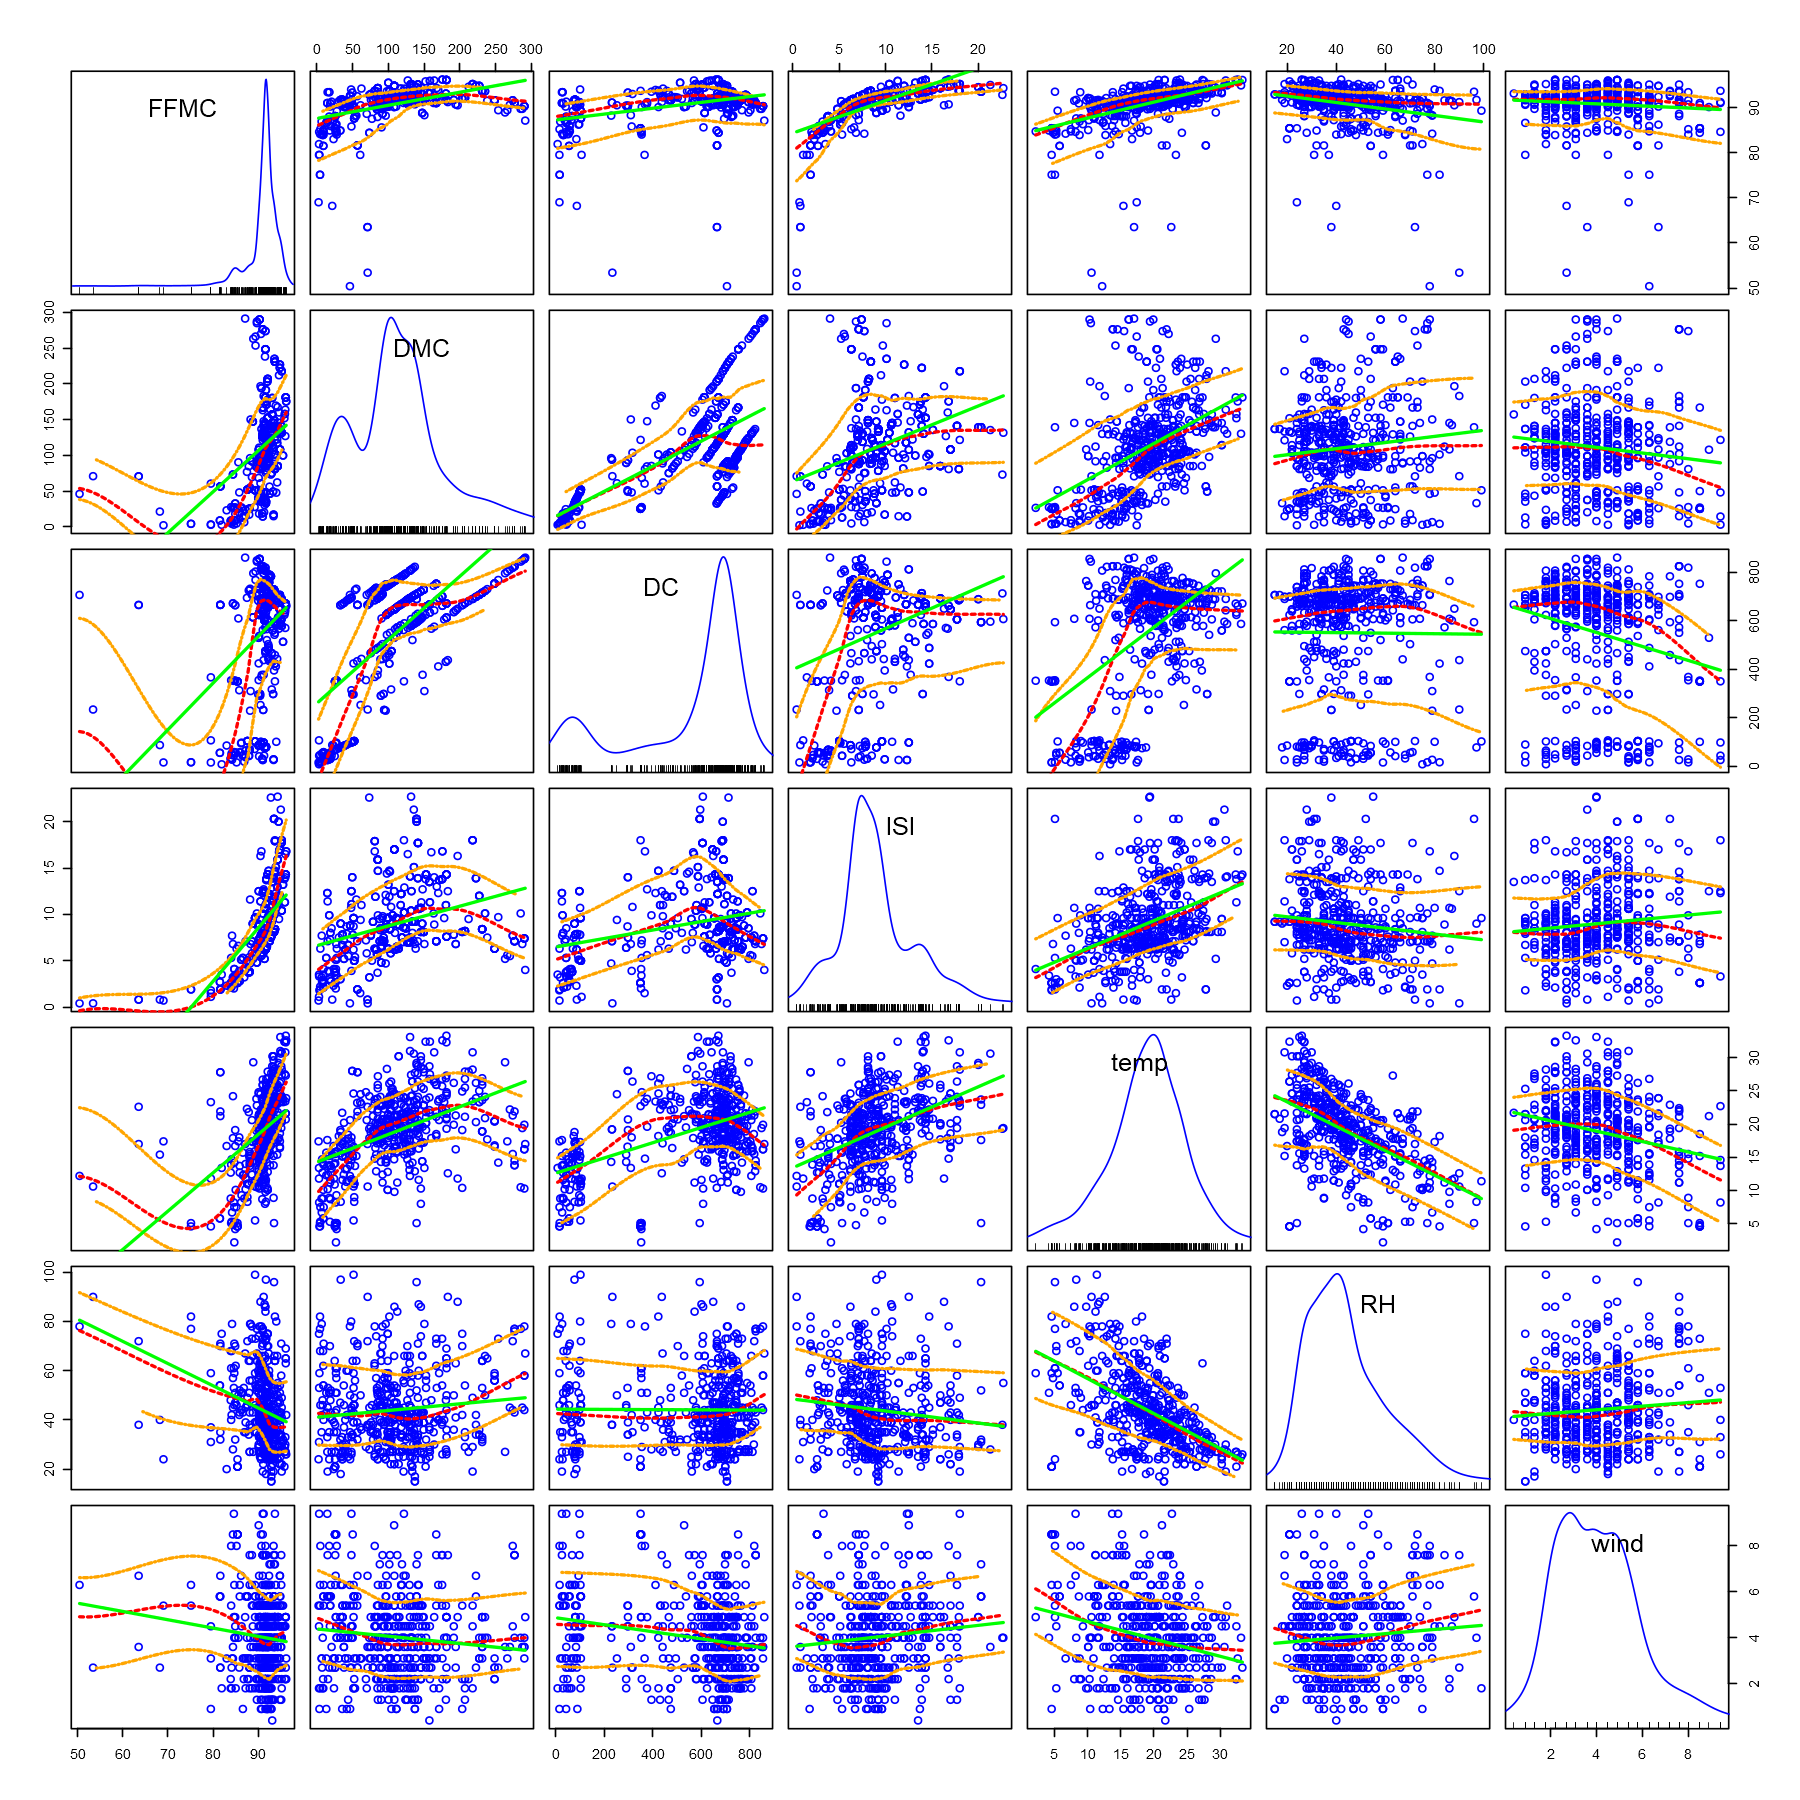

In [26]:
setPlotSize(15,15)
scatterplotMatrix(~FFMC+DMC+DC+ISI+temp+RH+wind,data=raw[ISI<50,], regLine = list(col="green"),
    smooth=list(col.smooth="red", col.spread="orange"))

All correlation between FFMC, DMC, DC, ISI, temp and RH are shown non-linear except the correlation between RH and temp which is looked more linear. Moreover, there are two interesting correlation graphs, which are:
* correlation between FFMC and ISI looks like exponential curve
* correlation between DMC and DC looks linear when the graph are split at DC = 200

`geom_smooth()` using formula 'y ~ x'



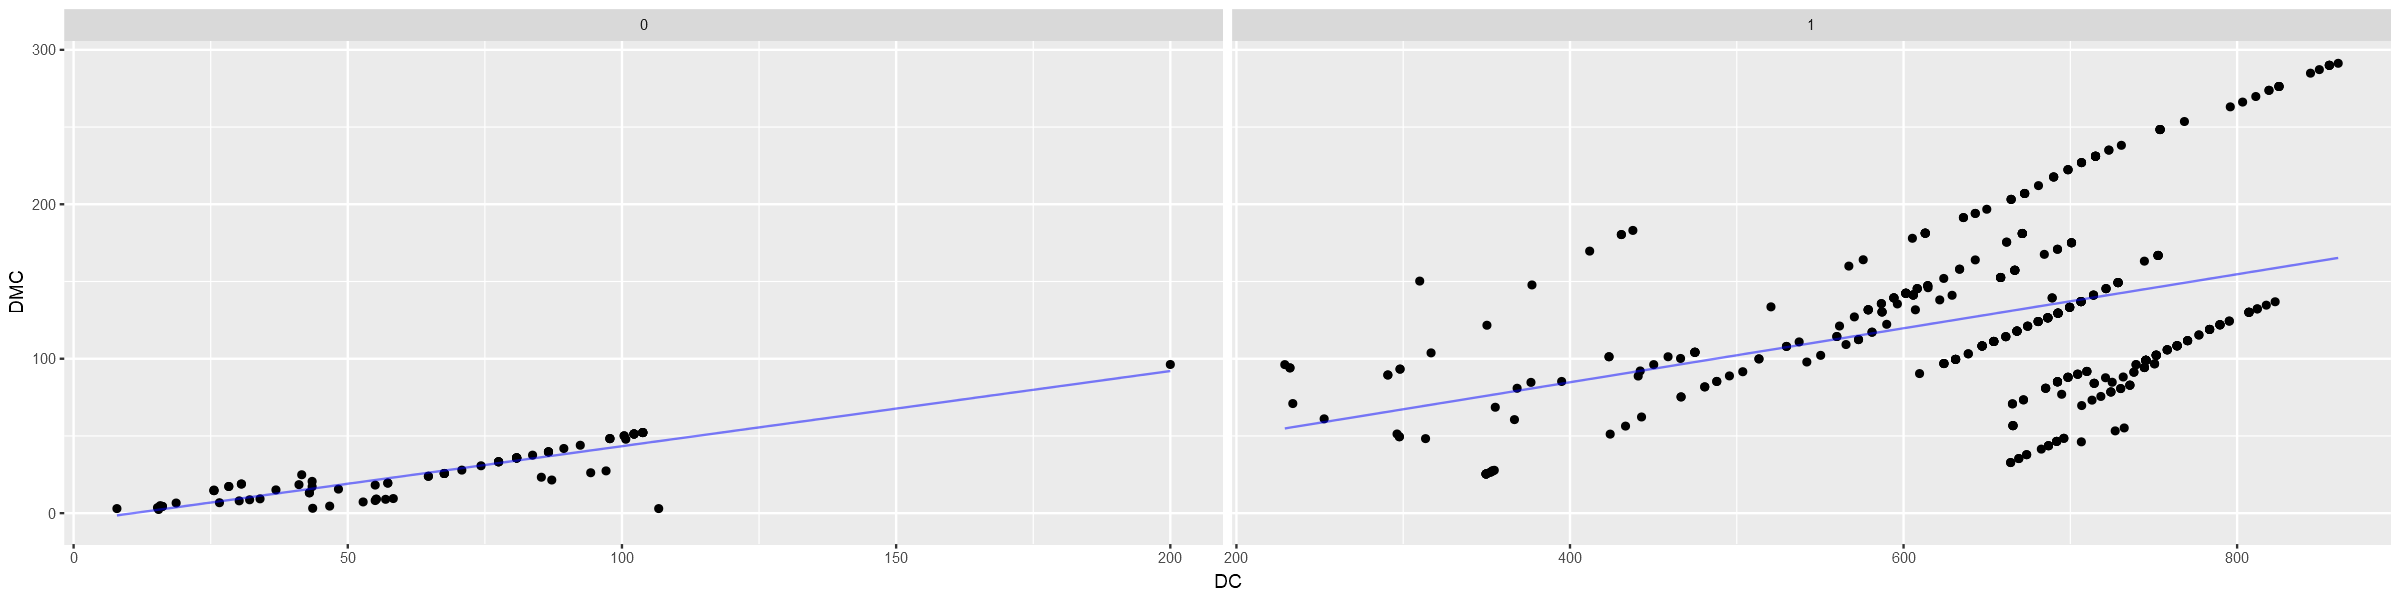

In [27]:
setPlotSize(20,5)
par(mfrow = c(1,2) )
raw %>%
    mutate(split=ifelse(DC>200,1,0)) %>%
    ggplot(aes(DC,DMC)) + geom_point() +
        stat_smooth(geom="line", alpha=.5, method='lm',col='blue') +
        facet_grid(.~split, scales = 'free')

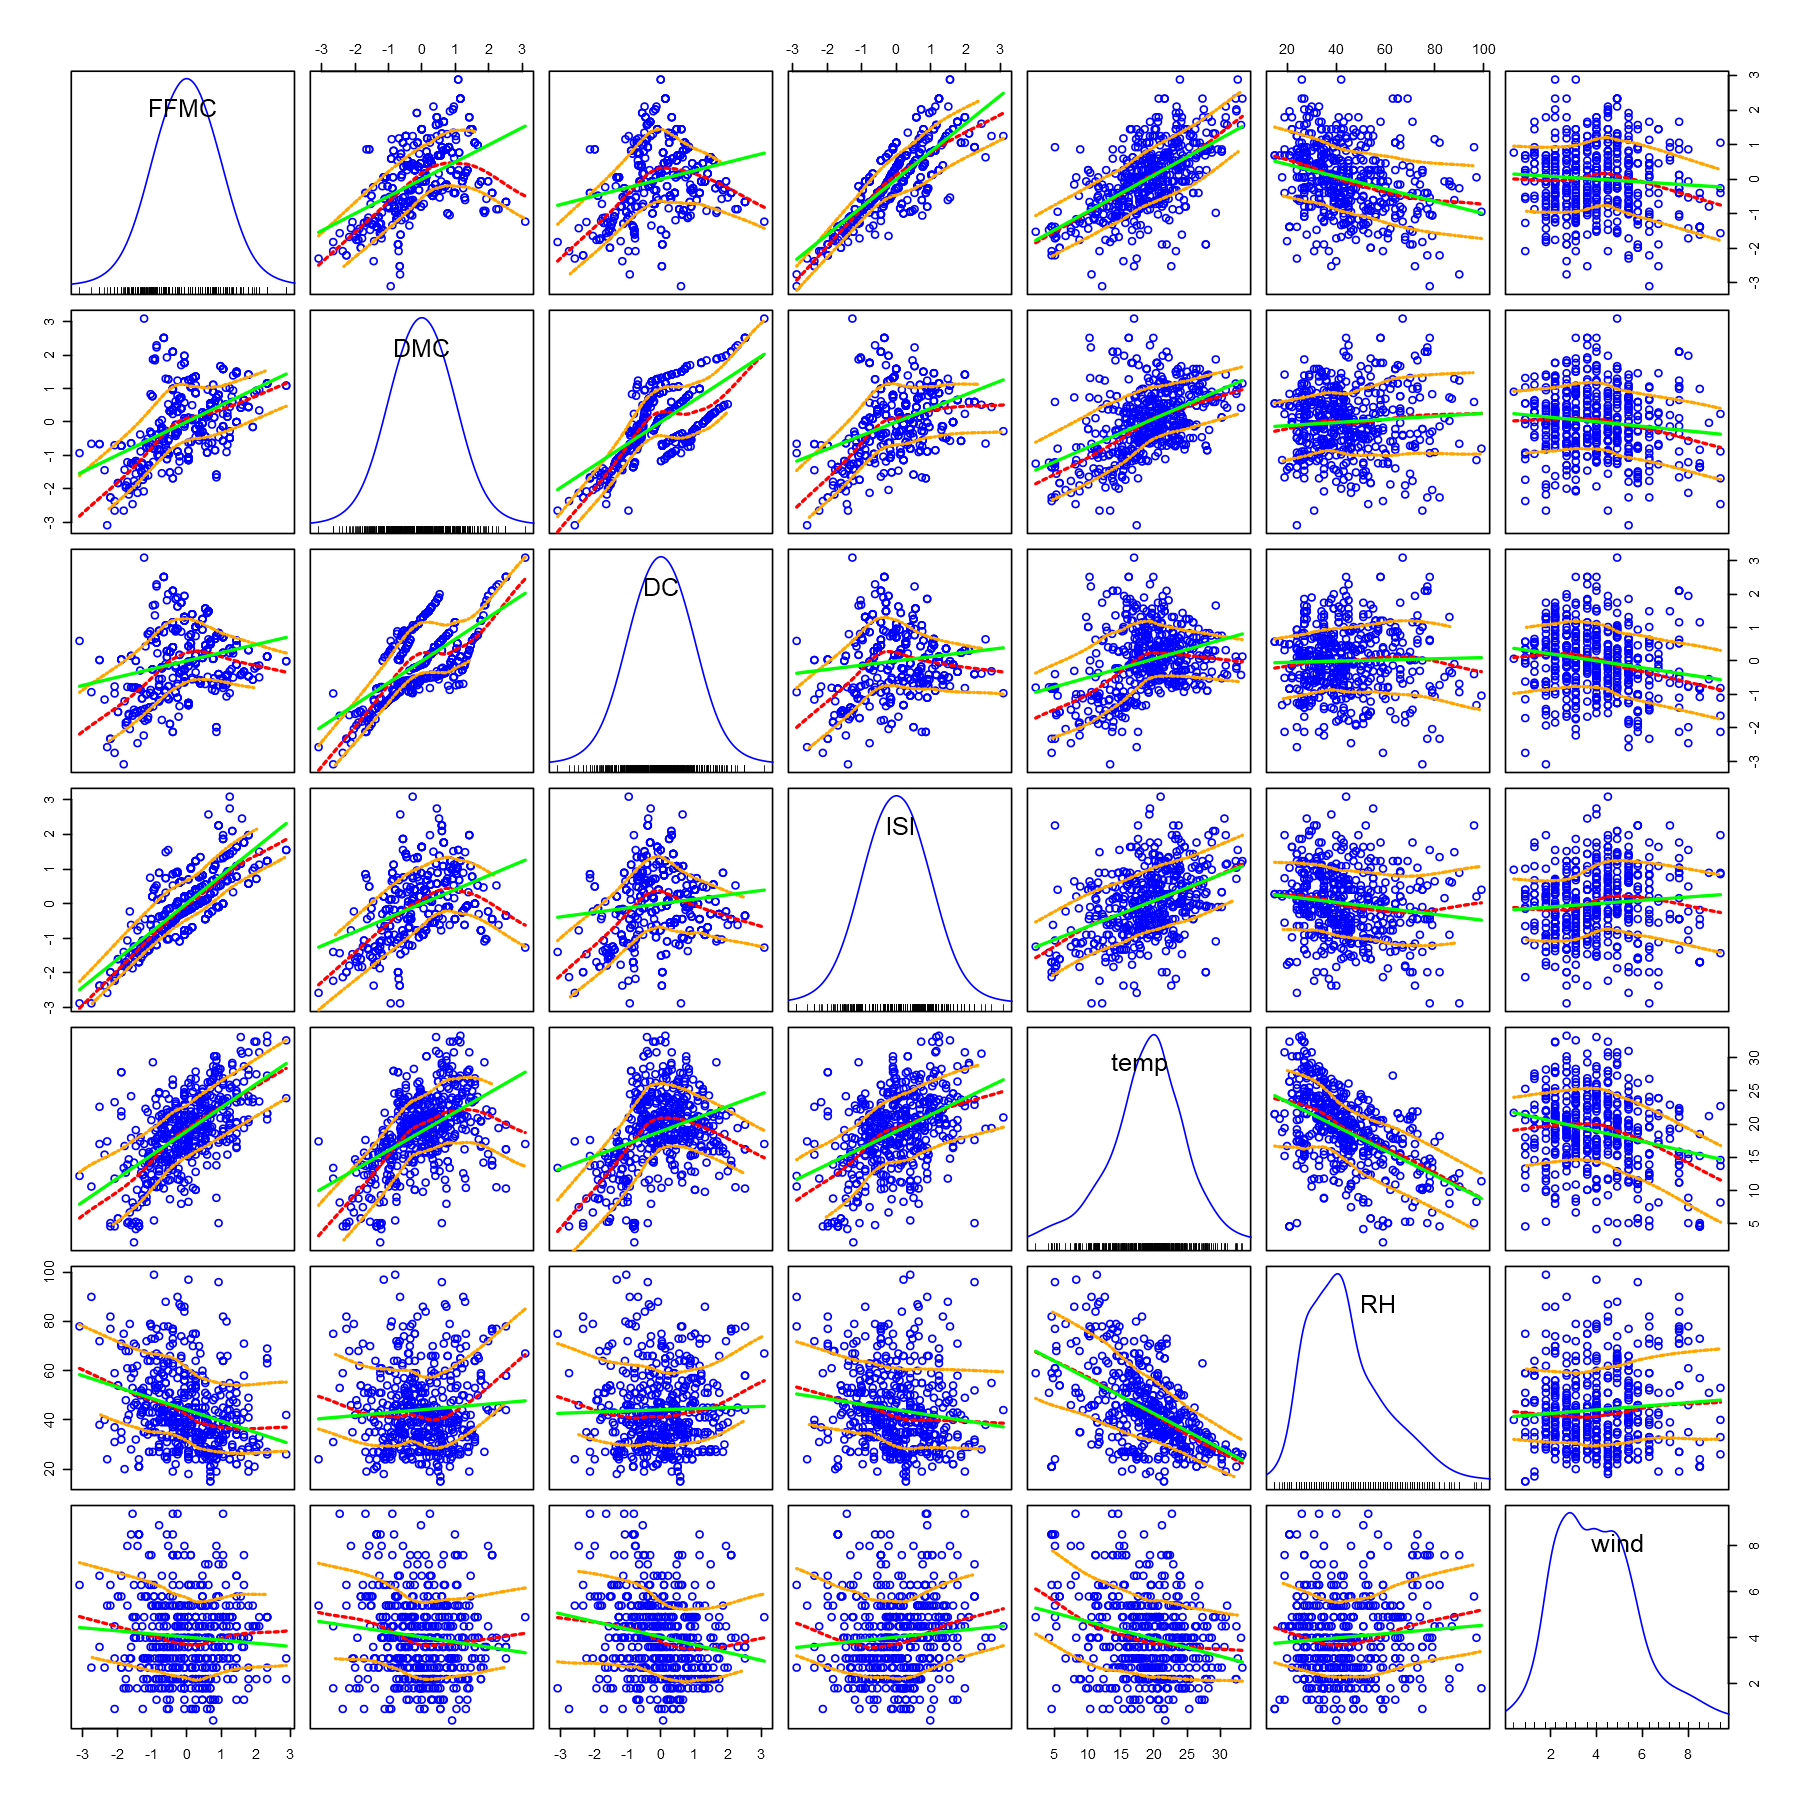

In [28]:
setPlotSize(15,15)
# trying to plot scatterPlot with normalized columns
norm.data <- data.frame(cbind(FFMC.norm,DMC.norm,DC.norm,ISI.norm, raw$temp,raw$RH,raw$wind))
names(norm.data) <- c('FFMC','DMC','DC','ISI','temp','RH','wind')
scatterplotMatrix(~FFMC+DMC+DC+ISI+temp+RH+wind,data=norm.data, regLine = list(col="green"),
    smooth=list(col.smooth="red", col.spread="orange"))

Plotting all normalized column makes some correlations become more linear, like correlation between:
* DMN and DC
* FFMC and ISI
* temp and ISI
* temp and FFMC
* RMC and RH

Month Correlation to Continuous Variables 

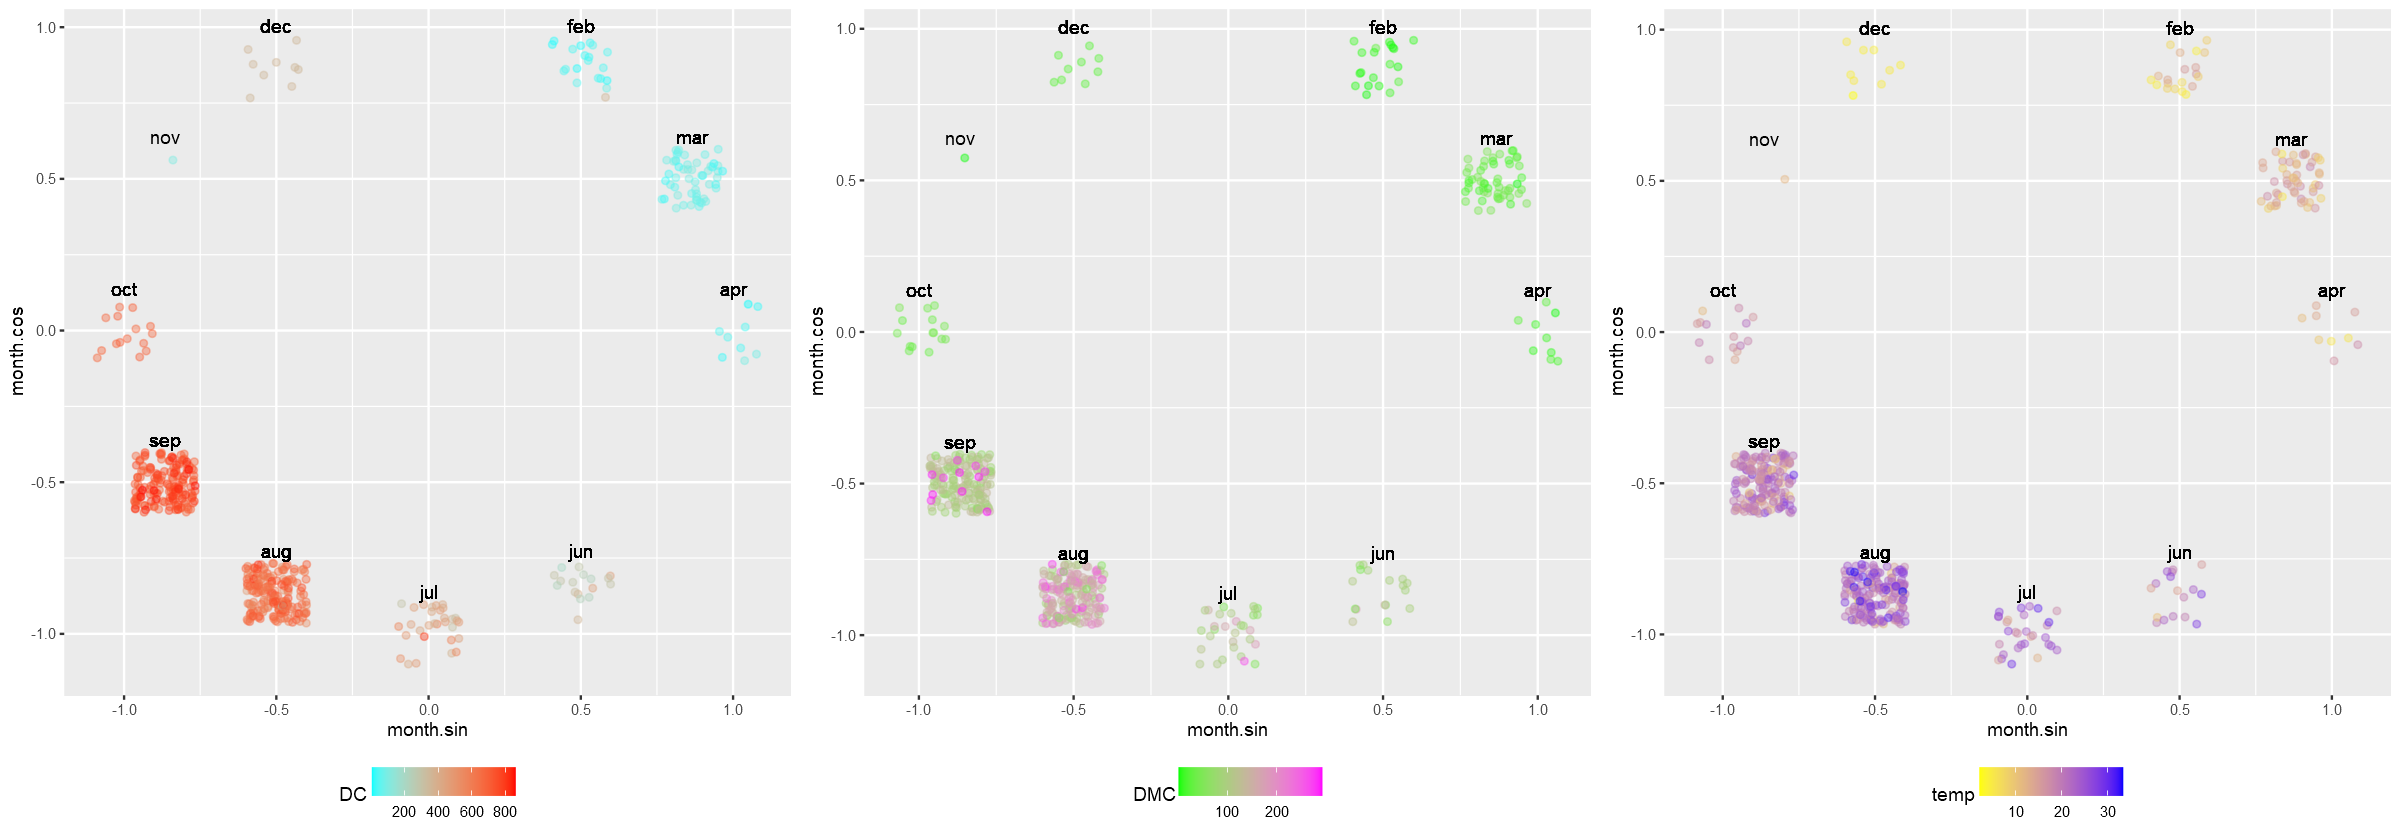

In [29]:
setPlotSize(20,7)

p1 <- ggplot(raw, aes(month.sin,month.cos, label=month)) +
    geom_jitter(alpha=.4,aes(color=DC),width = .1, height = .1) + geom_text(vjust=-2.5) +
    scale_color_gradient(low = 'cyan', high='red') + theme(legend.position = 'bottom')
p2 <- ggplot(raw, aes(month.sin,month.cos, label=month)) +
    geom_jitter(alpha=.4,aes(color=DMC),width = .1, height = .1) + geom_text(vjust=-2.5) +
    scale_color_gradient(low = 'green', high='magenta')+ theme(legend.position = 'bottom')
p3 <- ggplot(raw, aes(month.sin,month.cos, label=month)) +
    geom_jitter(alpha=.4,aes(color=temp),width = .1, height = .1) + geom_text(vjust=-2.5) +
    scale_color_gradient(low = 'yellow', high='blue')+ theme(legend.position = 'bottom')
grid.arrange(p1,p2,p3, ncol=3)

Using additional information from the Internet, I know that Montesinho park has seasonal ranges as follow:
* Summer occurs from June to mid September,
* Fall is around late September to November,
* Winter sits in December to February, and
* Spring occurs around mid March to May 

With the seasonal range informations above, the graphs explain that:
* DC has its highest value occurs when the park is in end of summer, and its lowest value occurs in the end of winter. So, DC is highly correlated with seasonal circle.
* As for DMC, its higher values start occuring in June and vanishing in September. So, summer in Montesinho park helps DMC values become higher.
* As we know about 4 seasons through out year, summer should have higher mean of temperature and winter should have lower temperature's average. The month and temp graph proves that circle more bluish dots occurs around months of summer and yellowish dots are shown around winter.

Correlation with Spatial Variable

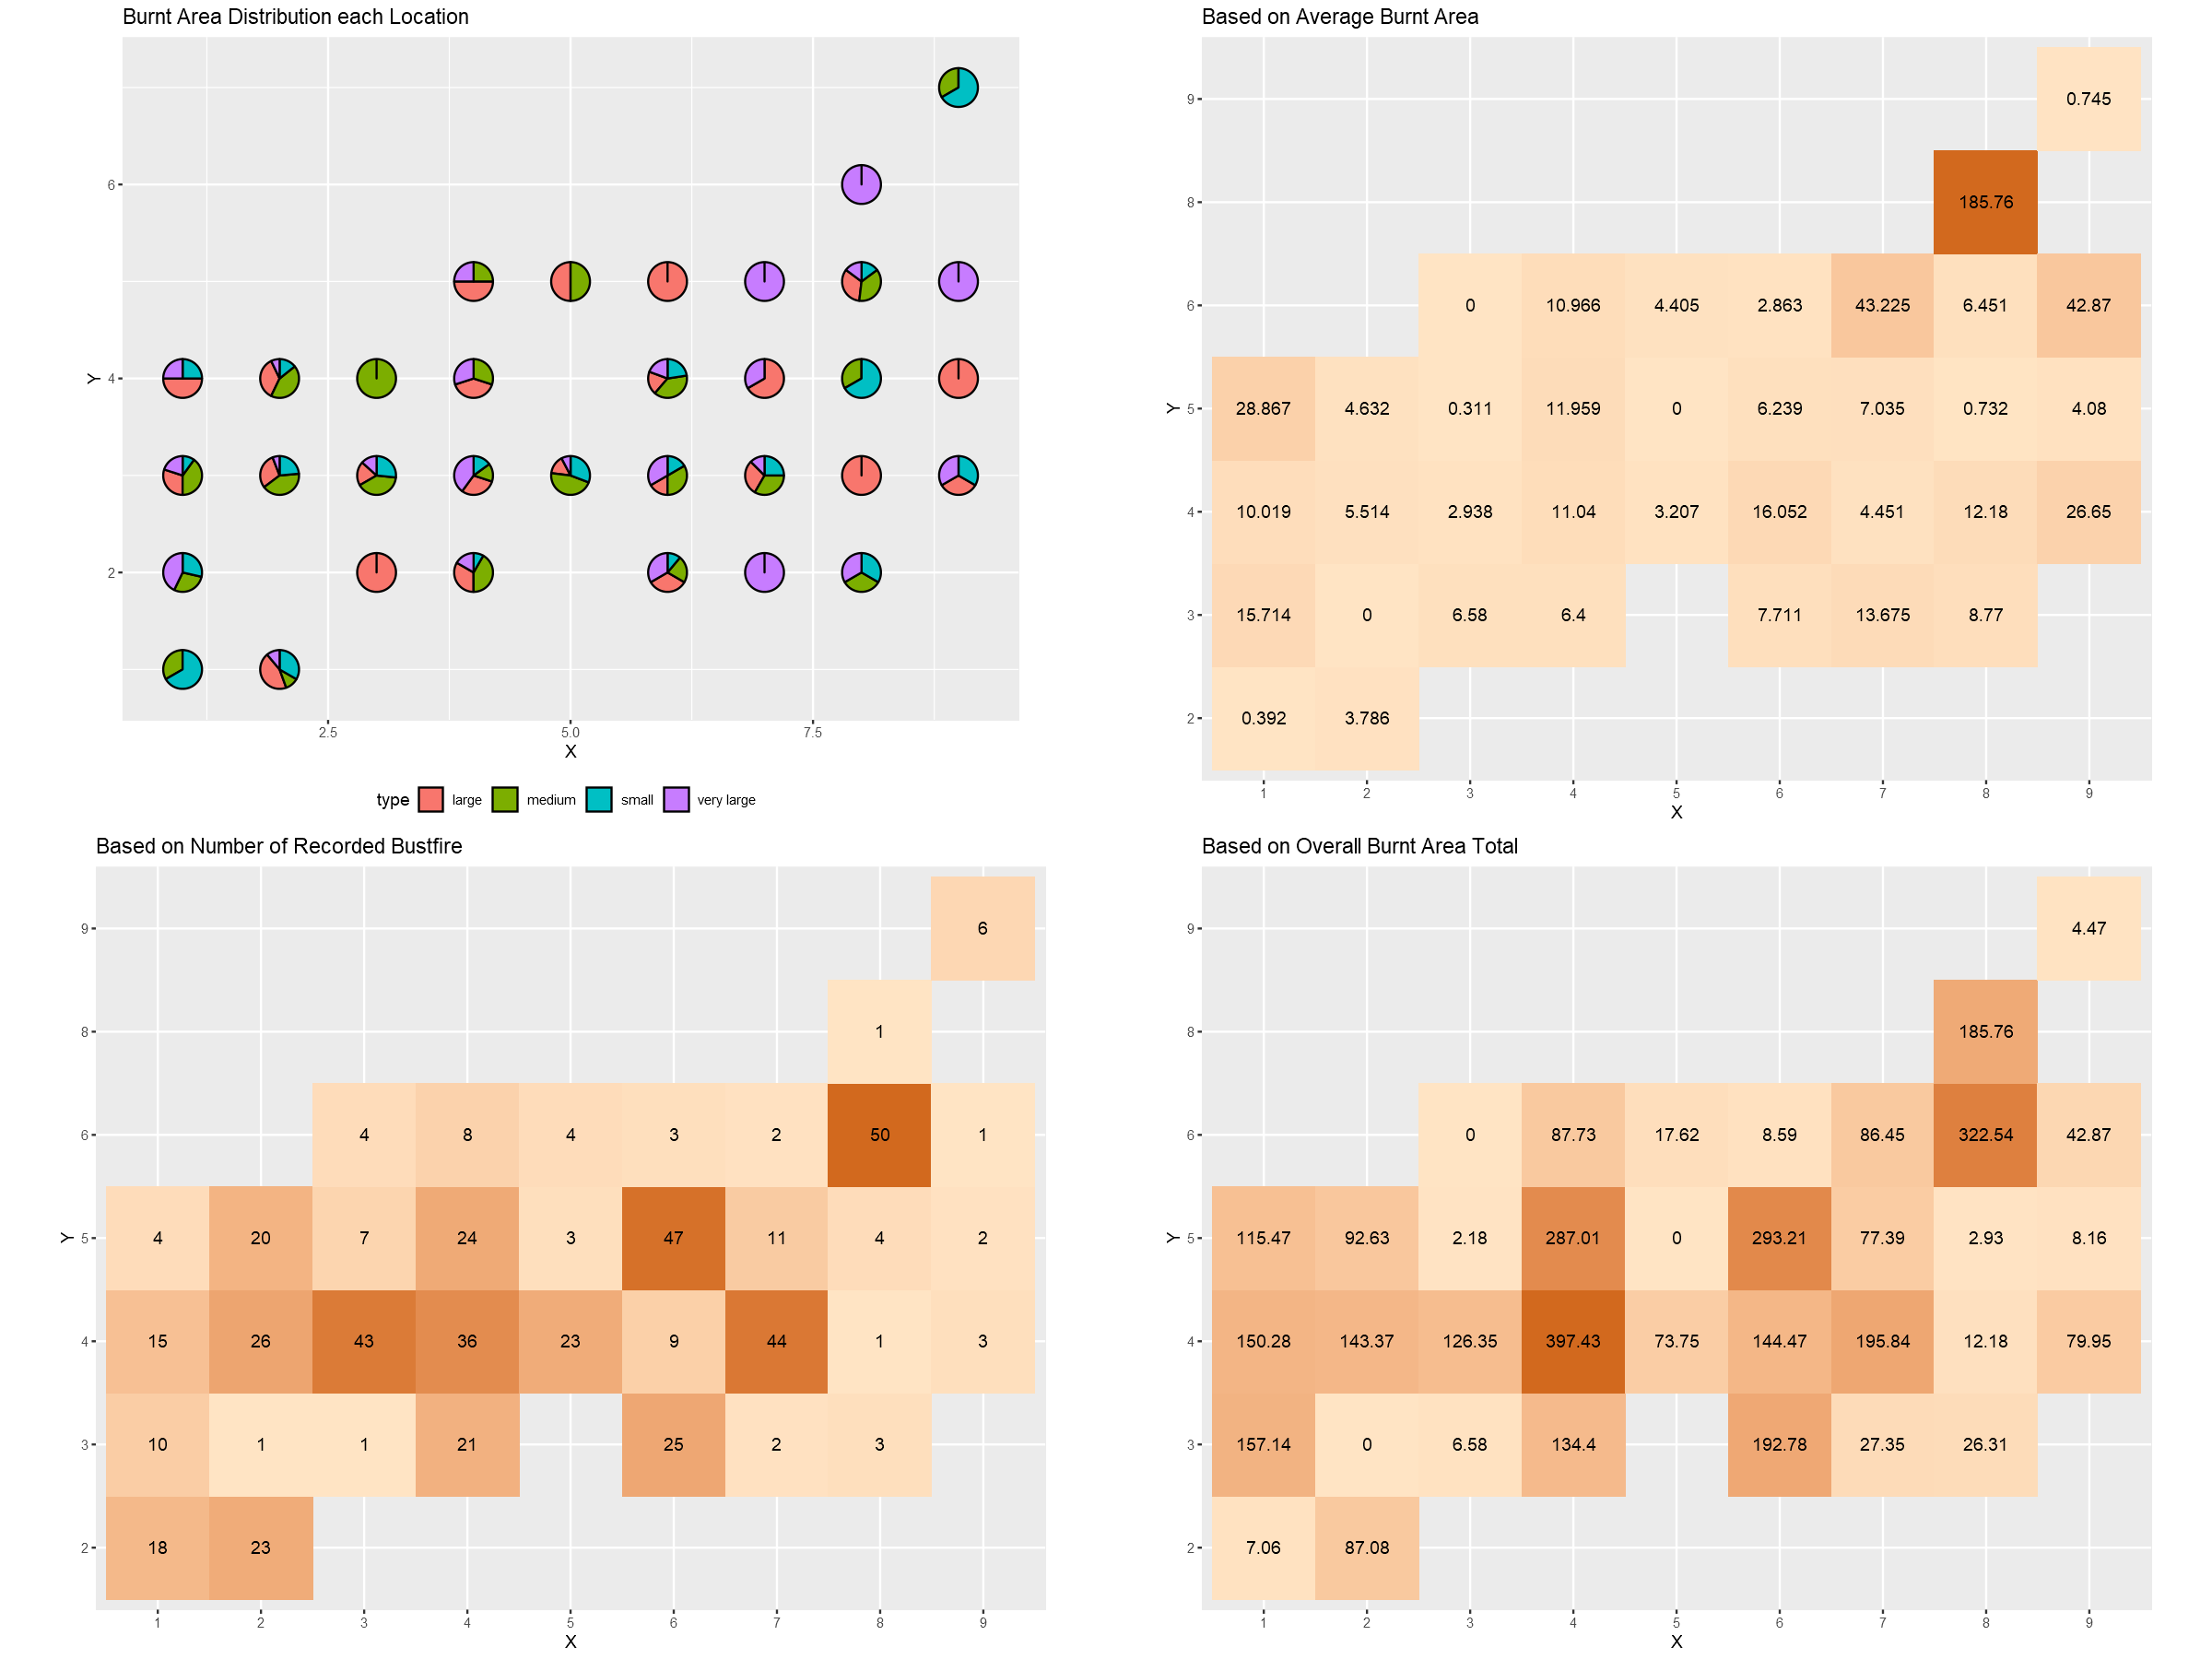

In [30]:
setPlotSize(20,15)

spatial <- raw[,c('X','Y','area')] %>%
                group_by(X,Y) %>%
                summarise(mean=mean(area),n=n(),total=sum(area))
m1 <- raw %>% mutate(count=1) %>% filter(burntNo != 'no') %>%
          dcast(formula = X+Y~burntNo,fun.aggregate = sum, value.var = 'count')

p1 <- ggplot(spatial,aes(X,Y,label=round(mean,3))) +
    geom_tile(aes(fill=mean)) +
    scale_fill_gradient(low='bisque',high='chocolate') + 
    geom_text() + coord_equal() + ggtitle('Based on Average Burnt Area')+
    theme(legend.position = 'none')
p2 <- ggplot(spatial,aes(X,Y,label=round(n,3))) +
    geom_tile(aes(fill=n)) +
    scale_fill_gradient(low='bisque',high='chocolate') + 
    geom_text() + coord_equal() + ggtitle('Based on Number of Recorded Bustfire')+
    theme(legend.position = 'none')
p3 <- ggplot(spatial,aes(X,Y,label=round(total,3))) +
    geom_tile(aes(fill=total)) +
    scale_fill_gradient(low='bisque',high='chocolate') + 
    geom_text() + coord_equal() + ggtitle('Based on Overall Burnt Area Total')+
    theme(legend.position = 'none')
p4<- ggplot() + xlab('X') + ylab('Y') + coord_equal() + ggtitle('Burnt Area Distribution each Location') +
    geom_scatterpie(data=m1, aes(x=as.integer(X), y=as.integer(Y), r=.2), cols=c('small','medium','large','very large'))+
    theme(legend.position = 'bottom')


grid.arrange(p4, p1,p2,p3,ncol=2,nrow=2)

As can be seen in the graphs above, most of forests burnt are located in center part of the park. However, the eastern parts are where many large or very large bustfire. The most severe forest burn occured in north eastern part of the park at coordinate 8,8 (X is considered as longitude coordinate and Y is considered as latitude coordinate). In that coordinate, only one bustfire occured but the burnt area was so large.

## 3. Model Development<a class="anchor" id="sec_3"></a>

In [31]:
# Auxillary function to calculate model performance in term of RMSE
pred.RMSE <- function(model, predictor, target){
    se <- 0
    predicted <- exp(predict(model, predictor))-1
    for (i in 1:length(predicted)) {
        se <- se + (predicted[i]-target[i])^2
    }
    score <- sqrt(se/length(predicted))
    return(score)
}

Preparing dataset for model development

In [32]:
# copy the loaded datafile
full.data <- datafile

# remove influential outliers
full.data <- full.data[-influential[!is.na(influential)],]

# factorize features
full.data$month <- factor(full.data$month, levels = c("jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"))
full.data$day <- factor(full.data$day, levels = c("mon", "tue", "wed", "thu", "fri", "sat", "sun"))
full.data$X <- as.factor(full.data$X)
full.data$Y <- as.factor(full.data$Y)

# circular transformation
circle <- cirTransform(as.integer(full.data$month))
full.data$month.sin <- circle[,'sin']
full.data$month.cos <- circle[,'cos']
full.data$month <- NULL

circle <- cirTransform(as.integer(full.data$day))
full.data$day.sin <- circle[,'sin']
full.data$day.cos <- circle[,'cos']
full.data$day <- NULL

# normalization trasformation
full.data$FFMC.norm <- orderNorm(full.data$FFMC)$x.t
full.data$DMC.norm <- orderNorm(full.data$DMC)$x.t
full.data$DC.norm <- orderNorm(full.data$DC)$x.t
full.data$ISI.norm <- orderNorm(full.data$ISI)$x.t

full.data$rain.norm <- sqrt(full.data$rain)
full.data$area.norm <- log(full.data$area +1)

# feature enginering
full.data$rainNo <- factor(ifelse(full.data$rain.norm == 0, 'no', 'yes'), levels=c('no','yes'))
full.data$DCsplit <- factor(ifelse(full.data$DC <= 200, 'low', 'high'), levels=c('low','high'))

# remove transformed predictors
full.data$FFMC <- NULL
full.data$DMC <- NULL
full.data$DC <- NULL
full.data$ISI <- NULL
full.data$rain <- NULL
full.data$month <- NULL
full.data$daya <- NULL

dim(full.data)
head(full.data)

Warning message in orderNorm(full.data$FFMC):
"Ties in data, Normal distribution not guaranteed
"
Warning message in orderNorm(full.data$DMC):
"Ties in data, Normal distribution not guaranteed
"
Warning message in orderNorm(full.data$DC):
"Ties in data, Normal distribution not guaranteed
"
Warning message in orderNorm(full.data$ISI):
"Ties in data, Normal distribution not guaranteed
"


[1] 505  18

X Y temp RH wind area month.sin month.cos day.sin day.cos FFMC.norm  
1 7 5  8.2 51 6.7  0     0.951     0.309    -0.434  -0.901  -1.29291747
2 7 4 18.0 33 0.9  0    -0.588     0.809     0.782   0.623  -0.56761410
3 7 4 14.6 33 1.3  0    -0.588     0.809    -0.975  -0.223  -0.56761410
4 8 6  8.3 97 4.0  0     0.951     0.309    -0.434  -0.901   0.05462698
5 8 6 11.4 99 1.8  0     0.951     0.309    -0.782   0.623  -0.94133219
6 8 6 22.2 29 5.4  0    -0.951    -0.309    -0.782   0.623   0.40006464
  DMC.norm   DC.norm    ISI.norm   rain.norm area.norm rainNo DCsplit
1 -1.2703488 -1.1277963 -1.1138430 0.0000000 0         no     low    
2 -1.1138430  0.1119146 -0.6482370 0.0000000 0         no     high   
3 -0.9569077  0.2971701 -0.6482370 0.0000000 0         no     high   
4 -1.1419728 -1.3220887  0.2074690 0.4472136 0         yes    low    
5 -0.7999110 -1.0385590  0.4027547 0.0000000 0         no     low    
6 -0.4572035 -0.5851961  1.3462627 0.0000000 0         no     high

The dataset for developing models has 505 datapoints and 18 variables including the target variable (area.norm)

Split the data as training and testing datasets

In [33]:
## 80% of the sample size
smp_size <- floor(0.8 * nrow(full.data))

## set the seed to make the partition reproducible
set.seed(1971)

# sample the train indexes
train_ind <- sample(seq_len(nrow(full.data)), size = smp_size)

# split the full.data
train.data <- full.data[train_ind, ]
test.data <- full.data[-train_ind, ]

# store the y f
train.true <- train.data$area
test.true <- test.data$area
full.true <- full.data$area

train.data$area <- NULL
test.data$area <- NULL
full.data$area <- NULL

cat("The training data's Dimension:")
dim(train.data)
cat("The testing data's Dimension:")
dim(test.data)

The training data's Dimension:

[1] 404  17

The testing data's Dimension:

[1] 101  17

### Linear Model
#### First Model
Use all raw features including transformed features

In [34]:
# make model
lm1 <- lm(area.norm~., data=train.data)
summary(lm1)


Call:
lm(formula = area.norm ~ ., data = train.data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1520 -0.9539 -0.3000  0.7209  3.6276 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.188400   0.810601   0.232 0.816339    
X2          -0.351956   0.283074  -1.243 0.214521    
X3          -1.130999   0.328483  -3.443 0.000640 ***
X4          -0.400594   0.302783  -1.323 0.186629    
X5          -0.717424   0.377343  -1.901 0.058035 .  
X6          -0.529286   0.320401  -1.652 0.099382 .  
X7          -0.725371   0.325582  -2.228 0.026478 *  
X8          -0.656572   0.399831  -1.642 0.101403    
X9           0.927773   0.646396   1.435 0.152035    
Y3           0.805283   0.344419   2.338 0.019907 *  
Y4           0.875256   0.286229   3.058 0.002389 ** 
Y5           0.910849   0.297168   3.065 0.002334 ** 
Y6           0.999345   0.394228   2.535 0.011652 *  
Y8           5.013669   1.312790   3.819 0.000157 ***
Y9          -1.194233   0.8

a few statistic that need to focus on:
* The adjusted $R^2$ shows that this model only can explain 7.64% variation on the target variable (area.norm)
* The F-statistic 2.191 has low p-value (0.0005889). That low p-value indicates that the model is more useful than model with only intercept because that we can reject the null hypothesis based on that p-value.
* P-value on each features suggests the significancy of each corresponding feature. Most of the features are not significant and the most of significant features are in the X and Y variables with the most significant are both X3 and Y8.
* month.cos and rainNoYes are significant features outside X and Y variables, whereas rain.norm has lower level of significancy

Use step function to remove unimportant variables (reduce model complexity)

In [35]:
lm1 <- step(lm1)
summary(lm1)

Start:  AIC=197.55
area.norm ~ X + Y + temp + RH + wind + month.sin + month.cos + 
    day.sin + day.cos + FFMC.norm + DMC.norm + DC.norm + ISI.norm + 
    rain.norm + rainNo + DCsplit

            Df Sum of Sq    RSS    AIC
- day.sin    1     0.068 570.76 195.60
- RH         1     0.125 570.82 195.64
- temp       1     0.151 570.84 195.66
- ISI.norm   1     0.234 570.92 195.72
- FFMC.norm  1     0.466 571.16 195.88
- month.sin  1     0.523 571.21 195.93
- day.cos    1     1.051 571.74 196.30
- DC.norm    1     2.104 572.79 197.04
- DCsplit    1     2.820 573.51 197.55
<none>                   570.69 197.56
- wind       1     3.732 574.42 198.19
- DMC.norm   1     4.093 574.78 198.44
- rain.norm  1     5.174 575.86 199.20
- rainNo     1     9.183 579.87 202.00
- month.cos  1     9.690 580.38 202.36
- X          8    32.313 603.00 203.81
- Y          6    41.839 612.53 214.14

Step:  AIC=195.6
area.norm ~ X + Y + temp + RH + wind + month.sin + month.cos + 
    day.cos + FFMC.norm + DMC.


Call:
lm(formula = area.norm ~ X + Y + wind + month.cos + DMC.norm + 
    DC.norm + rain.norm + rainNo + DCsplit, data = train.data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1292 -0.9684 -0.3198  0.7245  3.5614 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.15520    0.38228   0.406 0.684987    
X2          -0.33645    0.27925  -1.205 0.229017    
X3          -1.10706    0.32099  -3.449 0.000626 ***
X4          -0.37366    0.29603  -1.262 0.207638    
X5          -0.71470    0.37064  -1.928 0.054564 .  
X6          -0.48694    0.31212  -1.560 0.119560    
X7          -0.72003    0.31754  -2.268 0.023916 *  
X8          -0.65230    0.39076  -1.669 0.095880 .  
X9           0.98800    0.62832   1.572 0.116673    
Y3           0.81073    0.33303   2.434 0.015375 *  
Y4           0.89340    0.27933   3.198 0.001497 ** 
Y5           0.92598    0.28937   3.200 0.001489 ** 
Y6           1.03172    0.38003   2.715 0.006931 ** 
Y8           4.

Step function remove many variables and only 9 variables are remained, which are:
* X
* Y
* wind
* month.cos
* DMC.norm
* DC.norm
* rain.norm
* rainNo
* DCsplit

The new model has 0.08852 $R^2$ value meaning that there is improvement in the current model compared with the previous model.

The model's p-value still shows that this model is still useful compared to model with only intercept.

In [36]:
score <- pred.RMSE(lm1, train.data, train.true)
print(paste("Model RMSE: ", round(score,3)))

[1] "Model RMSE:  16.016"


The current model has 16.016 RMSE score which will be used for model comparation

Warning message:
"not plotting observations with leverage one:
  119"
Warning message:
"not plotting observations with leverage one:
  119"


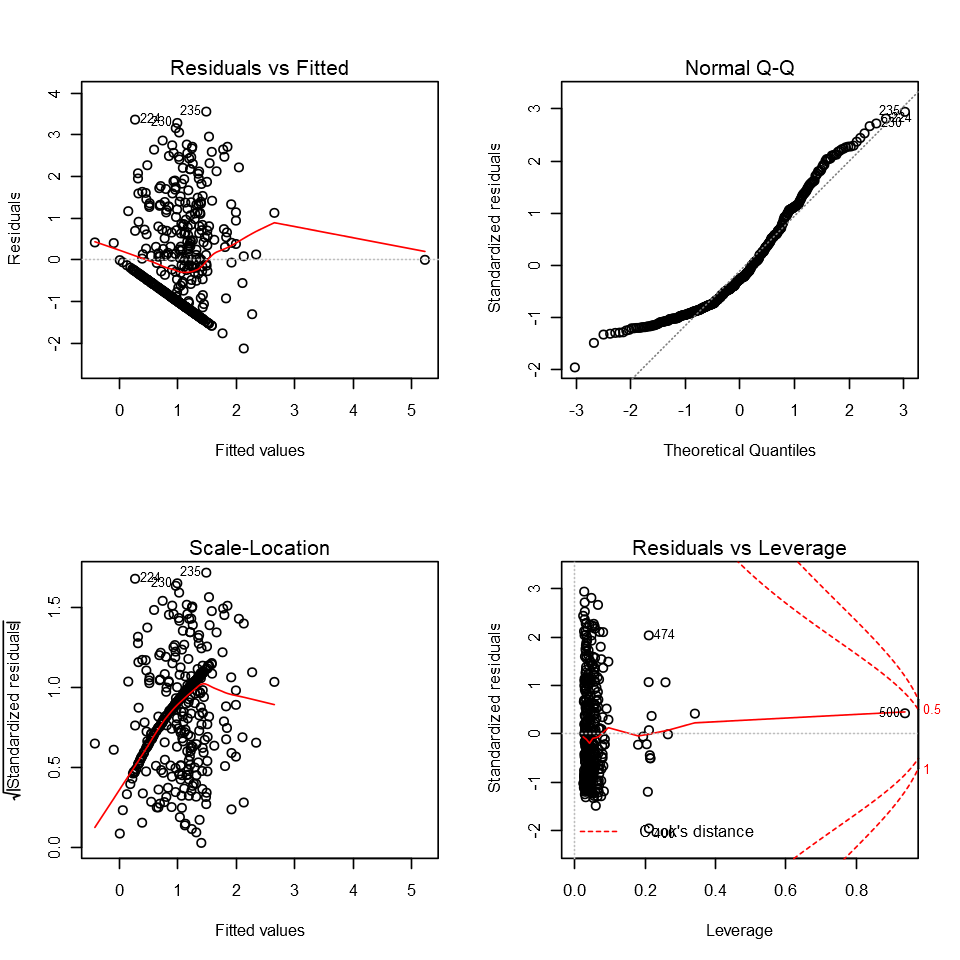

In [37]:
setPlotSize(8,8)
par(mfrow=c(2,2))
plot(lm1)

The model plots show:

* Residual vs Fitted - shows the model residuals are not evenly distributed around zero and the error terms change along the regression line. as it can be seen in the plot that the red line forms a zigzag shape and there is a straight line pattern on the bottom left part of the plot. The homoscedasticity assumption is violated in this model.
* Normal Q-Q - indicates that the model residuals are not normally distributed as the residuals deviate significantly from the dashed line
* Scale-Location - the assumption of equal variance is also violated by the model the since the model residuals are not distributed along the redline
* Residuals vs Leverage - shows there are some possible influential outliers, however they are still located inside the Cook's distance line. There is one datapoint that has almost an extreme leverage point (#500), but it still inside the borders. 

In [38]:
lm1.predict <- exp(lm1$fitted.values)-1
cbind(lm1.predict[119],train.true[119])
train.data[119,]

[,1]   [,2]  
421 185.76 185.76

X Y temp RH wind month.sin month.cos day.sin day.cos FFMC.norm  DMC.norm
421 8 8 26.2 36 4.5  -0.951    -0.309    0.975   -0.223  0.05462698 1.253838
    DC.norm    ISI.norm   rain.norm area.norm rainNo DCsplit
421 -0.1569966 -0.1821748 0         5.229824  no     high

One datapoint that was not plotted in the lm plots. The #119 point is accurately predicted.

#### Second Model
Add observed variable interactions to the first model

In [39]:
lm2 <- update(lm1, . ~ . + DMC.norm:DC.norm + ISI.norm:FFMC.norm + X:Y + DC.norm:month.sin +
              DC.norm:month.cos + DC.norm:month.cos + temp:month.cos + temp:RH , data = train.data)
summary(lm2)


Call:
lm(formula = area.norm ~ X + Y + wind + month.cos + DMC.norm + 
    DC.norm + rain.norm + rainNo + DCsplit + DMC.norm:DC.norm + 
    ISI.norm:FFMC.norm + X:Y + DC.norm:month.sin + month.cos:DC.norm + 
    month.cos:temp + temp:RH, data = train.data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0932 -0.8441 -0.2703  0.6921  3.7325 

Coefficients: (29 not defined because of singularities)
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -6.159e-01  6.903e-01  -0.892  0.37287    
X2                  3.875e-01  4.372e-01   0.886  0.37601    
X3                 -5.713e+00  1.846e+00  -3.095  0.00213 ** 
X4                 -4.736e+00  1.786e+00  -2.652  0.00837 ** 
X5                 -3.555e+00  1.924e+00  -1.847  0.06553 .  
X6                 -4.984e+00  1.880e+00  -2.650  0.00840 ** 
X7                 -3.821e+00  2.270e+00  -1.683  0.09324 .  
X8                 -4.469e+00  1.727e+00  -2.588  0.01006 *  
X9                 -1.611e+00  1.1

The $R^2$ of this model is a little bit higher that the previous model, it means that there is another improvement in this model.

The p-value of F-statistic still shows that this model is more useful than the model with only intercept.

Use Step function to remove unimportant features. 

In [40]:
lm2 <- step(lm2)
summary(lm2)

Start:  AIC=207.25
area.norm ~ X + Y + wind + month.cos + DMC.norm + DC.norm + rain.norm + 
    rainNo + DCsplit + DMC.norm:DC.norm + ISI.norm:FFMC.norm + 
    X:Y + DC.norm:month.sin + month.cos:DC.norm + month.cos:temp + 
    temp:RH

                     Df Sum of Sq    RSS    AIC
- X:Y                19    33.260 567.98 193.63
- temp:RH             1     0.086 534.80 205.31
- DMC.norm:DC.norm    1     0.254 534.97 205.44
- ISI.norm:FFMC.norm  1     0.755 535.47 205.82
- DC.norm:month.sin   1     1.531 536.25 206.41
- wind                1     2.313 537.03 206.99
<none>                            534.72 207.25
- DCsplit             1     2.717 537.43 207.30
- month.cos:temp      1     4.066 538.78 208.31
- month.cos:DC.norm   1     4.102 538.82 208.34
- rain.norm           1     4.266 538.98 208.46
- rainNo              1     7.232 541.95 210.68

Step:  AIC=193.63
area.norm ~ X + Y + wind + month.cos + DMC.norm + DC.norm + rain.norm + 
    rainNo + DCsplit + DMC.norm:DC.norm + ISI.n


Call:
lm(formula = area.norm ~ X + Y + wind + month.cos + DMC.norm + 
    DC.norm + rain.norm + rainNo + month.cos:DC.norm + month.cos:temp, 
    data = train.data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.3045 -0.9151 -0.3299  0.7100  3.6516 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        0.51301    0.30556   1.679 0.093987 .  
X2                -0.32304    0.28025  -1.153 0.249765    
X3                -1.09018    0.32118  -3.394 0.000760 ***
X4                -0.38608    0.29699  -1.300 0.194401    
X5                -0.76222    0.36901  -2.066 0.039547 *  
X6                -0.49611    0.31205  -1.590 0.112703    
X7                -0.73833    0.31772  -2.324 0.020659 *  
X8                -0.58979    0.39194  -1.505 0.133209    
X9                 0.75999    0.64928   1.171 0.242526    
Y3                 0.72137    0.33804   2.134 0.033480 *  
Y4                 0.85473    0.28098   3.042 0.002514 ** 
Y5               

Compared to the first model, this model still uses most of the same features as the first model. The only different is this model drops out the DCsplit and uses interaction variables between month.cos and DC.norm as well as month.cos and temp.

The $R^2$ of this model is getting lower than previous model. However, I still believe this model will show a better performance since it uses less predictors so that it will less overfit to the training data 

In [41]:
score <- pred.RMSE(lm2, train.data, train.true)
print(paste("Model RMSE: ", round(score,3)))

[1] "Model RMSE:  16.045"


The model RMSE shows there is a little improvement that the first model since the current model has lower RMSE score.

Warning message:
"not plotting observations with leverage one:
  119"
Warning message:
"not plotting observations with leverage one:
  119"


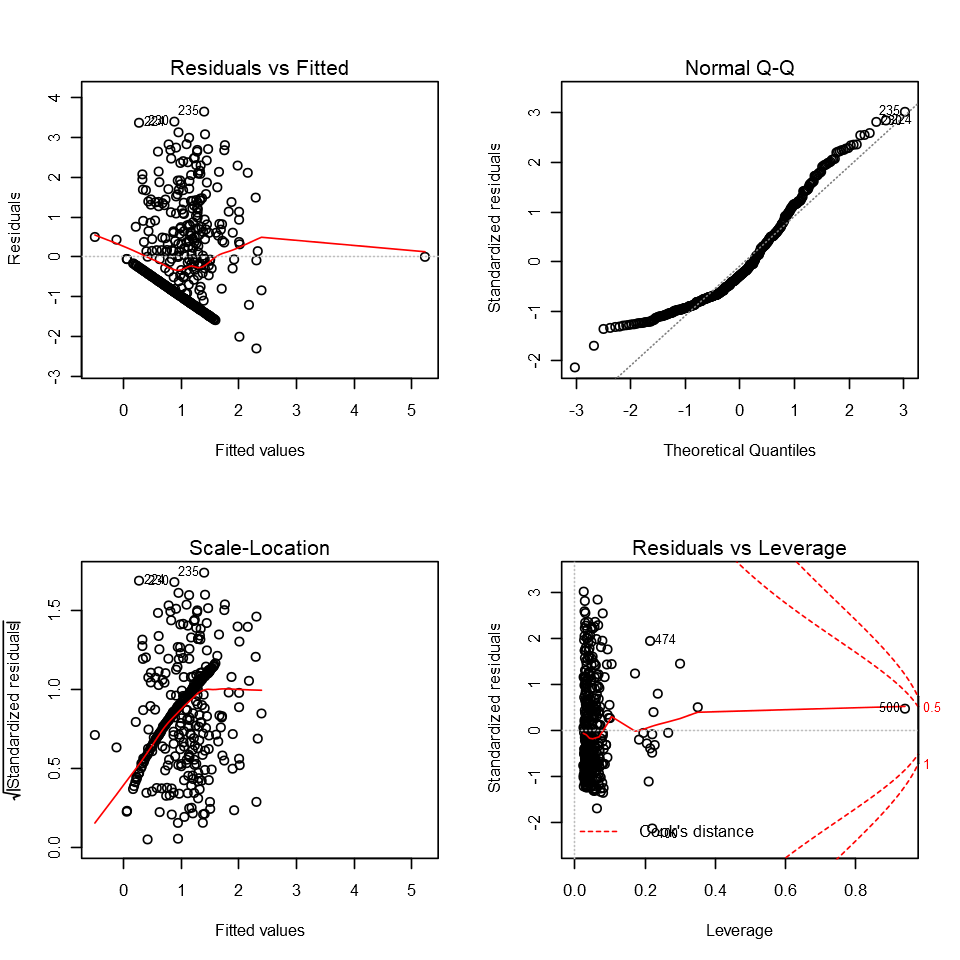

In [42]:
par(mfrow=c(2,2))
plot(lm2)

There is no much changes in the lm plots. The residuals are still not distributed normally and linearly. Moreover, the equal variance and homoscedasticity are still violated by the model.

#### Final Linear Model

In conclusion, I believe the second linear model that accomodate interactions between predictors is a better model, so the final linear model is using these variables as its predictor:
* X
* Y
* wind
* month.cos
* DMC.norm
* DC.norm
* rain.norm
* rainNo
* month.cos:DC.norm
* month.cos:temp

and this is the R code to build the model:

lm(formula = area.norm ~ X + Y + wind + month.cos + DMC.norm + 
    DC.norm + rain.norm + rainNo + month.cos:DC.norm + month.cos:temp, data = train.data)

### Random Forest
Train the initial model using all predictior

In [43]:
rf <- randomForest(area.norm~. ,data=train.data)


score <- pred.RMSE(rf, train.data, train.true)
print(paste("Model RMSE: ", round(score,3)))

[1] "Model RMSE:  14.7"


the initial model has 14.7 as its RMSE score

Feature Selection by using rfe function in caret package

the function implement a Recursive Feature Elimination which repeatedly construct a model and remove features with low weights. Here I use 10 fold validations as method to resampling models in each iteration.


Recursive feature selection

Outer resampling method: Cross-Validated (10 fold) 

Resampling performance over subset size:

 Variables  RMSE Rsquared   MAE RMSESD RsquaredSD   MAESD Selected
         1 1.441  0.04470 1.140 0.1961    0.07690 0.14519         
         2 1.350  0.02477 1.108 0.1446    0.03947 0.09557         
         3 1.295  0.03906 1.059 0.1117    0.03831 0.06355         
         4 1.266  0.05449 1.030 0.1287    0.05761 0.08429         
         5 1.259  0.05730 1.025 0.1312    0.04912 0.08766         
         6 1.254  0.07426 1.020 0.1254    0.05876 0.08270         
         7 1.251  0.07096 1.024 0.1386    0.05430 0.09270         
         8 1.250  0.06818 1.031 0.1388    0.05232 0.09554        *
         9 1.254  0.06786 1.029 0.1383    0.05224 0.09672         
        10 1.261  0.06101 1.034 0.1374    0.05004 0.09094         
        11 1.257  0.06528 1.038 0.1347    0.05792 0.09526         
        12 1.259  0.06341 1.042 0.1308    0.05184 0.09353         
    

[1] "temp"      "DC.norm"   "DMC.norm"  "Y"         "X"         "month.cos"
[7] "ISI.norm"  "wind"

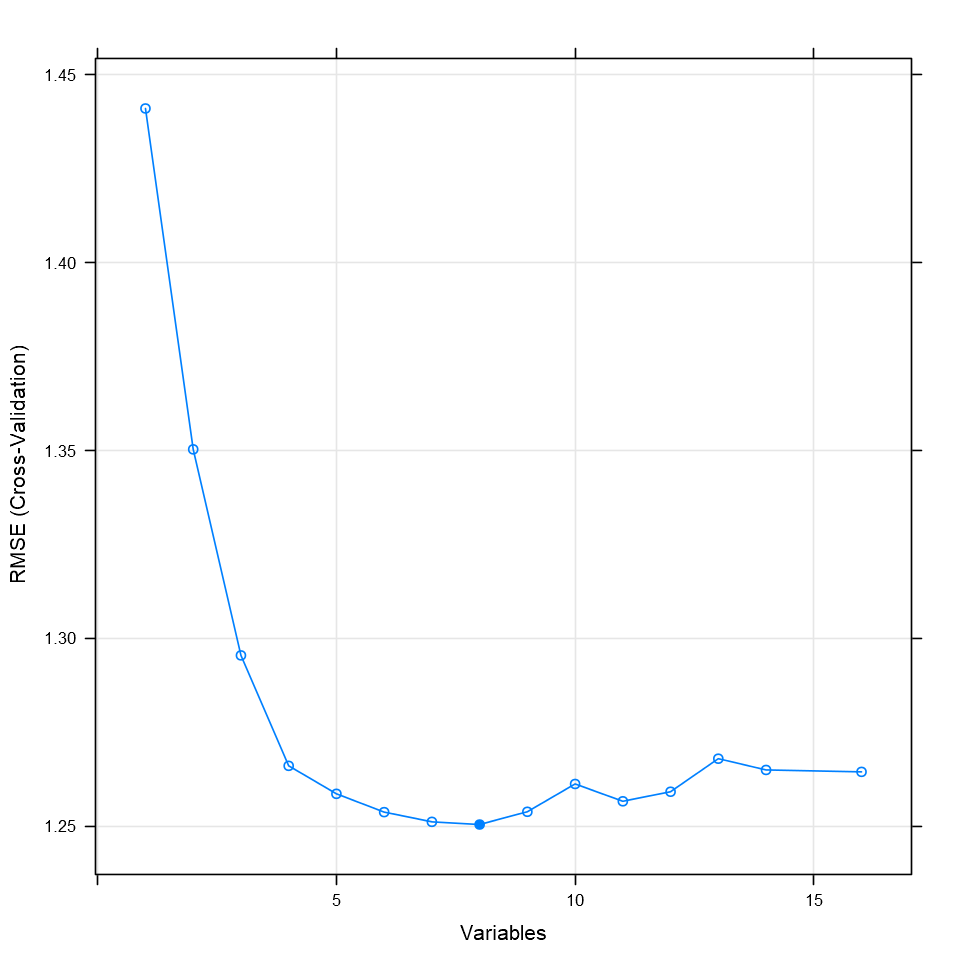

In [44]:
set.seed(1971)
col.index <- which(names(train.data) != 'area.norm')
# define the control using a random forest selection function
control <- rfeControl(functions=rfFuncs, method="cv", number=10)
# run the RFE algorithm
results <- rfe(train.data[,col.index],
               train.data[,'area.norm'], sizes=col.index, rfeControl=control)
# summarize the results
print(results)
# list the chosen features
predictors(results)
# plot the results
plot(results, type=c("g", "o"))

The result of RFE function shows that the best number of features to be use for random forest model training is 8 features. Additionaly, it also lists all 8 features to be use, as follow:
* 'temp'
* 'DC.norm'
* 'DMC.norm'
* 'Y'
* 'X'
* 'month.cos'
* 'ISI.norm'
* 'wind'

Hyperparameter Tuning using grid.search in caret package
The random forest's hyperparameter tuned is mtry. This hyperparameter manages the number of variables available for splitting at each tree node.

In this grid search, I use a range from 1 to number of predictor from rfe (8) as the possible mtry value. I also use  10 fold cross validation resampling method to get the optimal mtry value that give the lowest RMSE score.

Random Forest 

404 samples
  8 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 404, 404, 404, 404, 404, 404, ... 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared    MAE     
  1     1.276767  0.01707144  1.070252
  2     1.273912  0.02841082  1.055069
  3     1.278931  0.03446093  1.051875
  4     1.285714  0.03485715  1.052883
  5     1.291793  0.03438558  1.055611
  6     1.295879  0.03482912  1.058381
  7     1.299232  0.03477930  1.060460
  8     1.303727  0.03321169  1.063330

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 2.


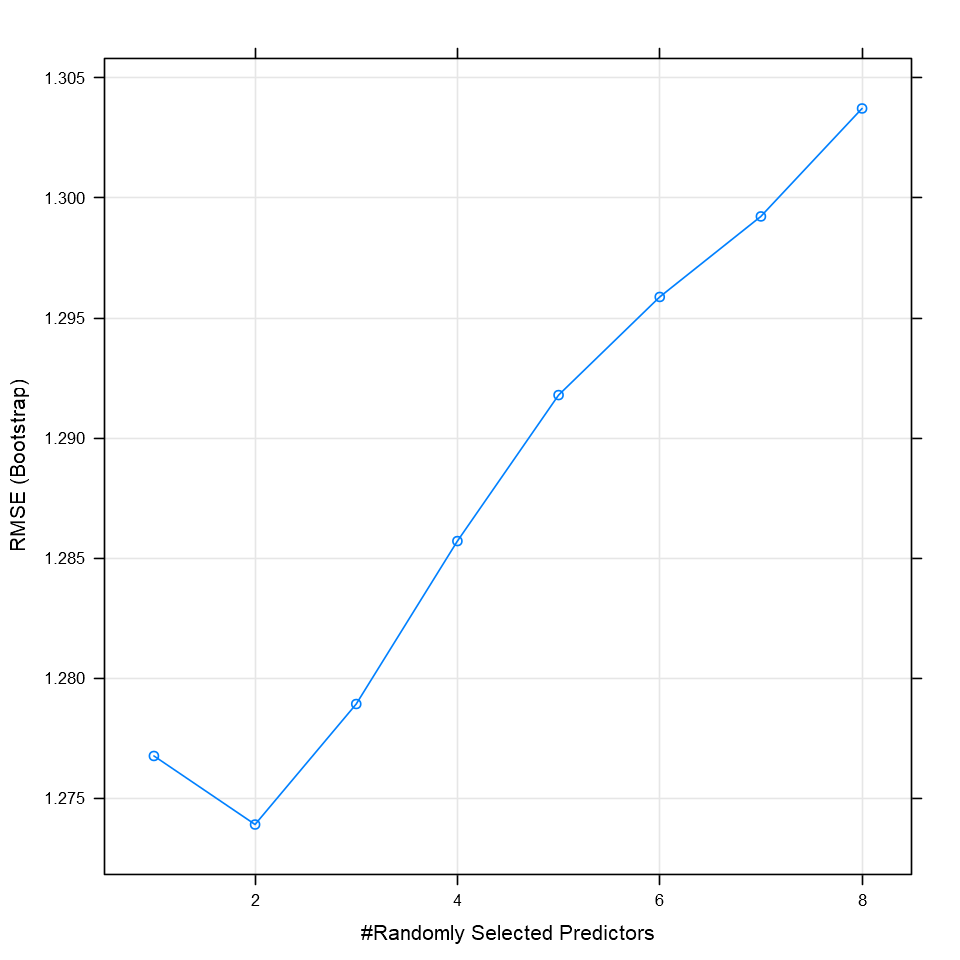

In [45]:
set.seed(1971)
control <- trainControl(method='repeatedcv', 
                        number=10, 
                        repeats=3,
                        search='grid')
# Create tunegrid with 8 values from 1:number of predictors for mtry to tunning model.
# Our train function will change number of entry variable at each split according to tunegrid. 
tunegrid <- expand.grid(.mtry = (1:8))

rf_gridsearch <- train(area.norm ~ temp + DC.norm + DMC.norm + Y + X + month.cos + ISI.norm + wind, 
                       data = train.data,
                       method = 'rf',
                       metric = 'RMSE',
                       tuneGrid = tunegrid)
print(rf_gridsearch)
plot(rf_gridsearch)

As it can be seen in the graph, the most optimum value of mtry is 2 which gives the average RMSE score of 1.2739.

#### Final Model

In [46]:
rf <- randomForest(area.norm~temp + DC.norm + DMC.norm + Y + X + month.cos + ISI.norm + wind,
                   data=train.data, mtry = 2)

score <- pred.RMSE(rf, train.data, train.true)
print(paste("Model RMSE: ", round(score,3)))

[1] "Model RMSE:  14.97"


The final Random Forest model is using 8 variable as its predictor and 2 as mtry value. Its has 14.97 RMSE score which is higher than the initial model. However, it should have better performance that the initial model for predicting unseen data since it has lower model complexity that helps resolving overfitting problem

### SVM

Train the initial SVM model and calculate its score

In [47]:
#Regression with SVM
svm1 <- svm(area.norm~.,data=train.data)

#Predict using SVM regression
score <- pred.RMSE(svm1, train.data, train.true)
print(paste("Model RMSE: ", round(score,3)))

[1] "Model RMSE:  18.924"


The SVM model has worse RMSE score that other previous models. So, I can try to find the optimum hyperparameter values to improve the score.

Hyperparameter Tuning
I use tune function in e10371 package to tune the gamma and cost value of svm. The possible gamma values is set around 0.1 to 2.0 with 0.1 increment and the possible cost values will try to be found in range of 2 to 16. I also implemen 10 fold cross validation method to calculate the lowest RMSE score for each pairs of possible gamma and cost values. 

In [48]:
set.seed(1971)
svmParams <- tune(svm, area.norm~., data = train.data, 
                    ranges = list(gamma = seq(.1,2,.1), cost = seq(2,16,2)),
                    tunecontrol = tune.control(sampling = "cross")
                    )
svmParams$best.parameters

gamma cost
10 1     2

As the result, the optimal gamma value is 1 and cost value is 2.

#### Final Model

In [49]:
svm2 <- svm(area.norm~.,data=train.data, 
            gamma = svmParams$best.parameters$gamma, 
            cost = svmParams$best.parameters$gamma)

#Predict using SVM regression
score <- pred.RMSE(svm2, train.data, train.true)
print(paste("Model RMSE: ", round(score,3)))

[1] "Model RMSE:  16.835"


The final svm model that implements the optimal gamma and cost values has 16.835 RMSE score which is significant improved that the initial svm model 

## 4. Model Comparison<a class="anchor" id="sec_4"></a>

To compare all three developed models above, I try to compare their RMSE score for predicting the testing dataset prepared before the model development step.

In [50]:
scoreLm <- pred.RMSE(lm2, train.data, train.true)
scoreRf <- pred.RMSE(rf, train.data, train.true)
scoreSvm <- pred.RMSE(svm2, train.data, train.true)

print(paste("Linear Regression RMSE: ", round(scoreLm,3)))
print(paste("Random Forest RMSE: ", round(scoreRf,3)))
print(paste("SVM RMSE: ", round(scoreSvm,3)))

[1] "Linear Regression RMSE:  16.045"
[1] "Random Forest RMSE:  14.97"
[1] "SVM RMSE:  16.835"


As it can be seen, the Random Forest is the best model from all three models since it has the lowest RMSE score. However, that RMSE scores haven't considered the uncertainty aspect of the model since it only have trained with one dataset and shown only one RMSE score. So, for considering the uncertainty of training models using different dataset, I use bootstrap method.

#### Bootstraping
Create a bootstraping auxillary function

In [51]:
boot.fn <- function(training, testing, target, bootsize) {
    # take a number of bootsize data from training data randomly but with replacement
    subset.data <- training[sample(nrow(training),bootsize,replace = TRUE),]
    
    # train all models using subsetted data
    boot.lm <- lm(formula = area.norm ~ X + Y + wind + month.cos + DMC.norm + 
                  DC.norm + rain.norm + rainNo + month.cos:DC.norm + month.cos:temp, data = subset.data)
    boot.rf <- randomForest(area.norm~temp + DC.norm + DMC.norm + Y + X + month.cos + ISI.norm + wind,
                            data=subset.data, mtry = 2)
    boot.svm <- svm(area.norm~.,data=subset.data, 
                    gamma = svmParams$best.parameters$gamma, 
                    cost = svmParams$best.parameters$gamma)
    
    # calculate score
    scoreLm <- pred.RMSE(boot.lm, testing, target)
    scoreRf <- pred.RMSE(boot.rf, testing, target)
    scoreSvm <- pred.RMSE(boot.svm, testing, target)
    
    #return the scores
    return (list(lm=scoreLm,rf=scoreRf,svm=scoreSvm))
}
#try it
boot.fn(train.data, test.data, test.true, 300)

$lm
       4 
16.98632 

$rf
       4 
17.28114 

$svm
       4 
17.36688

Implement the bootstraping with ntry number of try and 500 as bootstrap data size. There are some possibility that this code will errors related with the levels of Y variable because of the randomize datapoint sampling. If the errors occurs, please run this cell once again.

Warning message in predict.lm(model, predictor):
"prediction from a rank-deficient fit may be misleading"


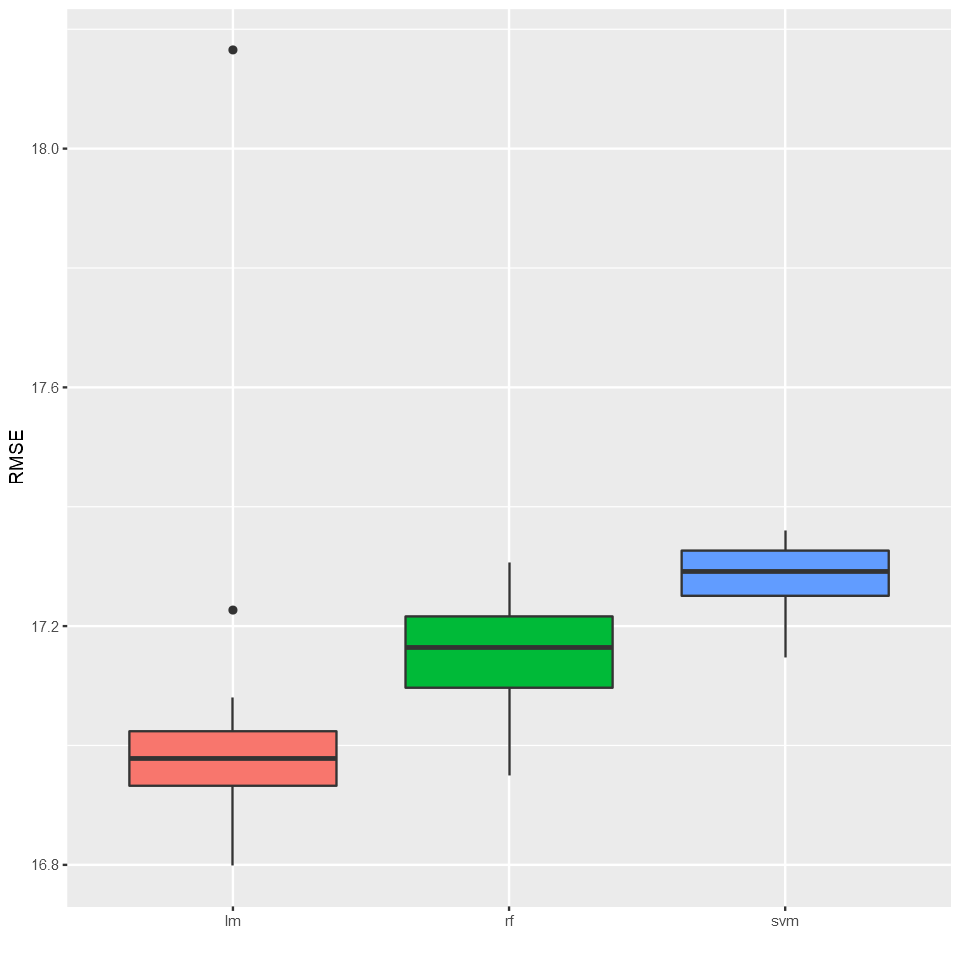

In [52]:
ntry <- 30
bootsize <- 500

# create a result holder
result <- data.frame(try=(1:ntry),lm=rep(0,ntry),rf=rep(0,ntry),svm=rep(0,ntry))

# loop for ntry number of times
for(i in (1:ntry)){
    # implement bootstraping
    booting <- boot.fn(train.data, test.data, test.true, bootsize)
    
    # save the model's scores
    result[i,'try'] <- i
    result[i,'lm'] <- booting$lm
    result[i,'rf'] <- booting$rf
    result[i,'svm'] <- booting$svm
}

# plot the boxplot for each model
result %>% melt(id.vars = 'try', measure.vars = c('lm','rf','svm')) %>%
    ggplot(aes(x=variable, y=value, fill=variable)) + geom_boxplot() +
    ylab('RMSE') + xlab('') + theme(legend.position='none')

As it can be seen from the graph, lm has lower median of RMSE score but couple outliers. In conclusion, linear model is the best model from all three models since its result on predicting unseen data shows lower bias to the target variables.

## 5. Variable Identification and Explanation <a class="anchor" id="sec_5"></a>

### Use raw data

In [53]:
# re-import the data
var.data <- datafile

# remove influential outliers
var.data <- var.data[-influential[!is.na(influential)],]

# factorize features
var.data$month <- factor(var.data$month, levels = c("jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"))
var.data$day <- factor(var.data$day, levels = c("mon", "tue", "wed", "thu", "fri", "sat", "sun"))
var.data$X <- as.factor(var.data$X)
var.data$Y <- as.factor(var.data$Y)

#### Best Subset Method

Best subset method try all possible subset of features and calculate its score

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2  linear dependencies found"


Reordering variables and trying again:


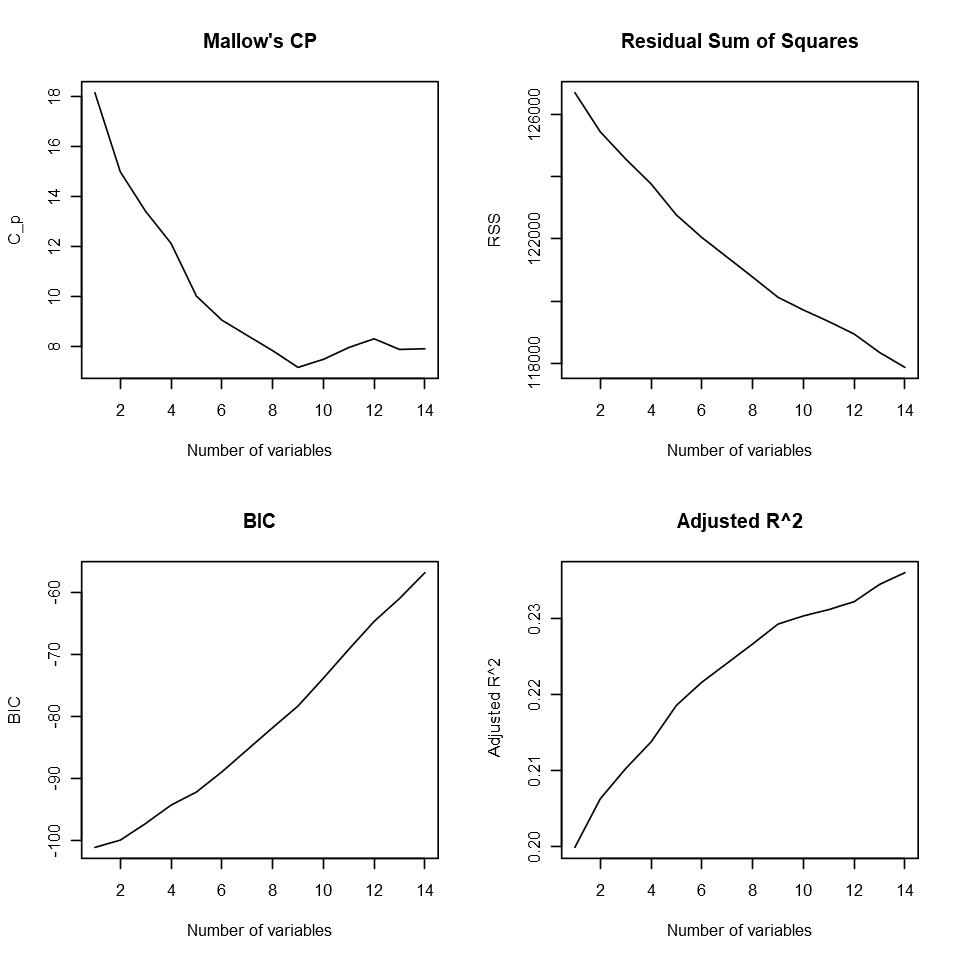

In [54]:
regfit.full <- regsubsets(area ~ ., data = var.data, nvmax = ncol(var.data))
reg.summary <- summary(regfit.full)


par(mfrow = c(2,2))
plot(reg.summary$cp, main = "Mallow's CP", xlab = "Number of variables", ylab = "C_p", type = "l")
plot(reg.summary$rss, main = "Residual Sum of Squares", xlab = "Number of variables", ylab = "RSS", type = "l")
plot(reg.summary$bic, main = "BIC", xlab = "Number of variables", ylab = "BIC", type = "l")
plot(reg.summary$adjr2, main = "Adjusted R^2", xlab = "Number of variables", ylab = "Adjusted R^2", type = "l")

The plots except the BIC plot shows that the most of optimum number of variable is around 9 variables. On the Mallow's CP plot, it is the lowest point of the line. In addition, it is at the knee point of the Adjusted $R^2$ plot. However, the point is difficult to see in the RSS plot, but it should be at the elbow point of that line around 9

#### Forward Subsetting Method

The forward subsetting method, build the best features subset from initial model with only intercept and add one feature that increase its score one of the time.

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2  linear dependencies found"


Reordering variables and trying again:


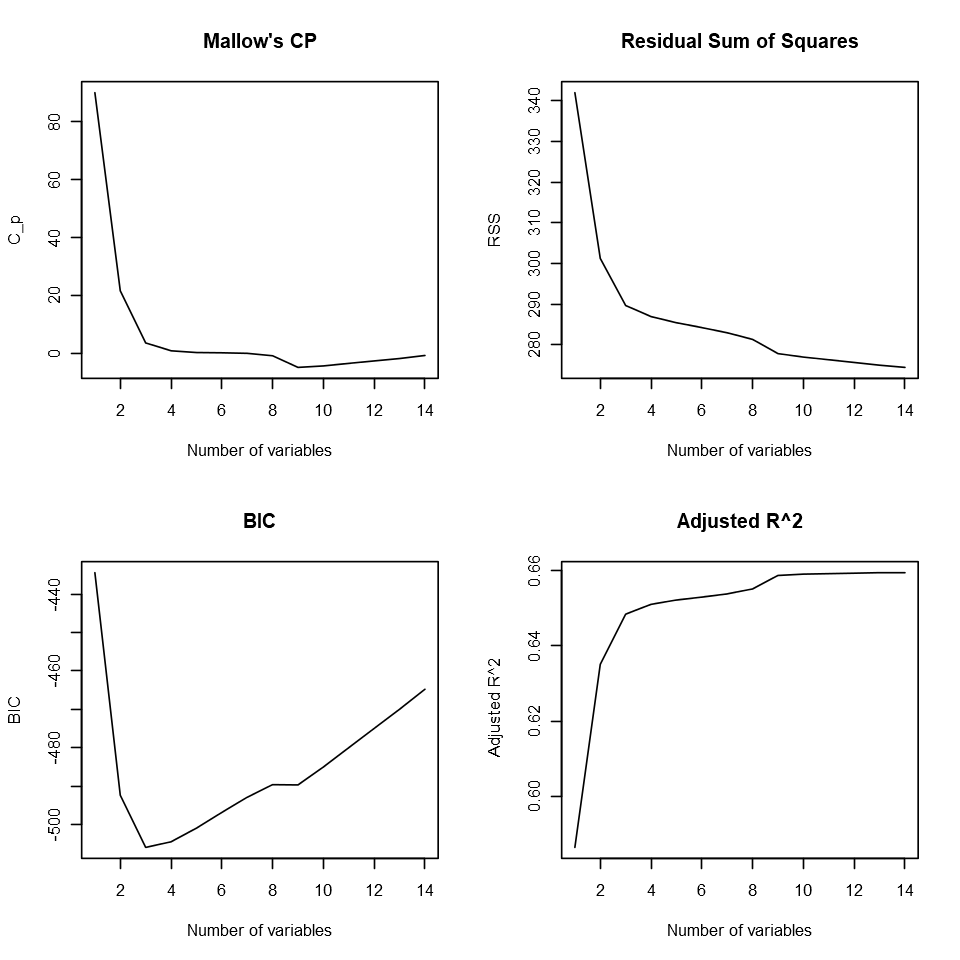

In [55]:
regfit.forward <- regsubsets(area.norm ~ ., data = var.data, nvmax = ncol(var.data), method = 'forward')
reg.summary <- summary(regfit.forward)

par(mfrow = c(2,2))
plot(reg.summary$cp, main = "Mallow's CP", xlab = "Number of variables", ylab = "C_p", type = "l")
plot(reg.summary$rss, main = "Residual Sum of Squares", xlab = "Number of variables", ylab = "RSS", type = "l")
plot(reg.summary$bic, main = "BIC", xlab = "Number of variables", ylab = "BIC", type = "l")
plot(reg.summary$adjr2, main = "Adjusted R^2", xlab = "Number of variables", ylab = "Adjusted R^2", type = "l")

The optimum number of variable is shown clearly from all plot, it is 3 variables. The point is at the elbow point of Mallow's CP, RSS and BIC plots and at the knee point of Adjusted $R^2$ plot.

#### Backward Subsetting Method

Different for the forward subsetting method, the backward subsetting method starts with all features as the model predictor. And in each iteration, it removes a variable which give unsignificant effect to the model score

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2  linear dependencies found"


Reordering variables and trying again:


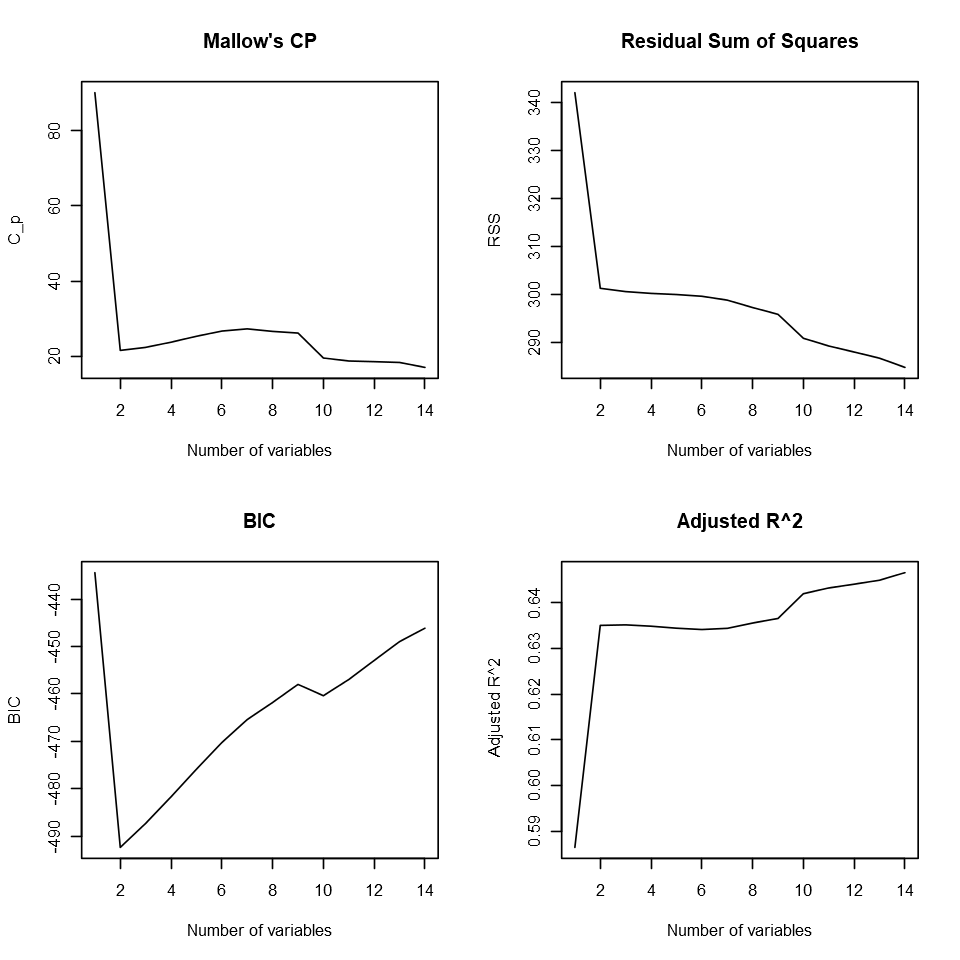

In [56]:
regfit.backward <- regsubsets(area.norm ~ ., data = var.data, nvmax = ncol(var.data), method = 'backward')
reg.summary <- summary(regfit.backward)

par(mfrow = c(2,2))
plot(reg.summary$cp, main = "Mallow's CP", xlab = "Number of variables", ylab = "C_p", type = "l")
plot(reg.summary$rss, main = "Residual Sum of Squares", xlab = "Number of variables", ylab = "RSS", type = "l")
plot(reg.summary$bic, main = "BIC", xlab = "Number of variables", ylab = "BIC", type = "l")
plot(reg.summary$adjr2, main = "Adjusted R^2", xlab = "Number of variables", ylab = "Adjusted R^2", type = "l")

All plots shows that the optimum number of varible is 2 variables.

##### Check the important predictors
Since the best subset method has too different conclusion, I just check the the forward and backward method's result  

In [57]:
cat('The Forward Subsetting method give these variables as the most important variables:')
coef(regfit.forward, 3)
cat('The Backward Subsetting method give these variables as the most important variables:')
coef(regfit.backward, 2)

The Forward Subsetting method give these variables as the most important variables:

(Intercept)          Y8      daywed    monthdec 
1.004453404 4.223389825 0.001981141 1.566996465

The Backward Subsetting method give these variables as the most important variables:

(Intercept)          Y8    monthdec 
   1.004662    4.225163    1.567008

Both forward and backward subsetting method give 2 same variables which are y8 and monthdec. In addition, the forward subsetting method adds daywed as the importan variable

#### Lasso Regression as Feature Subset Tools
Lasso regression can also be use as feature subset tools since it pulls the unimportant variable's coefficient toward zero. so the variables that have zero as its coefficient are considered as unimportant features. 

##### Find the best lambda for lasso regression by using cross validation

[1] 1.971036

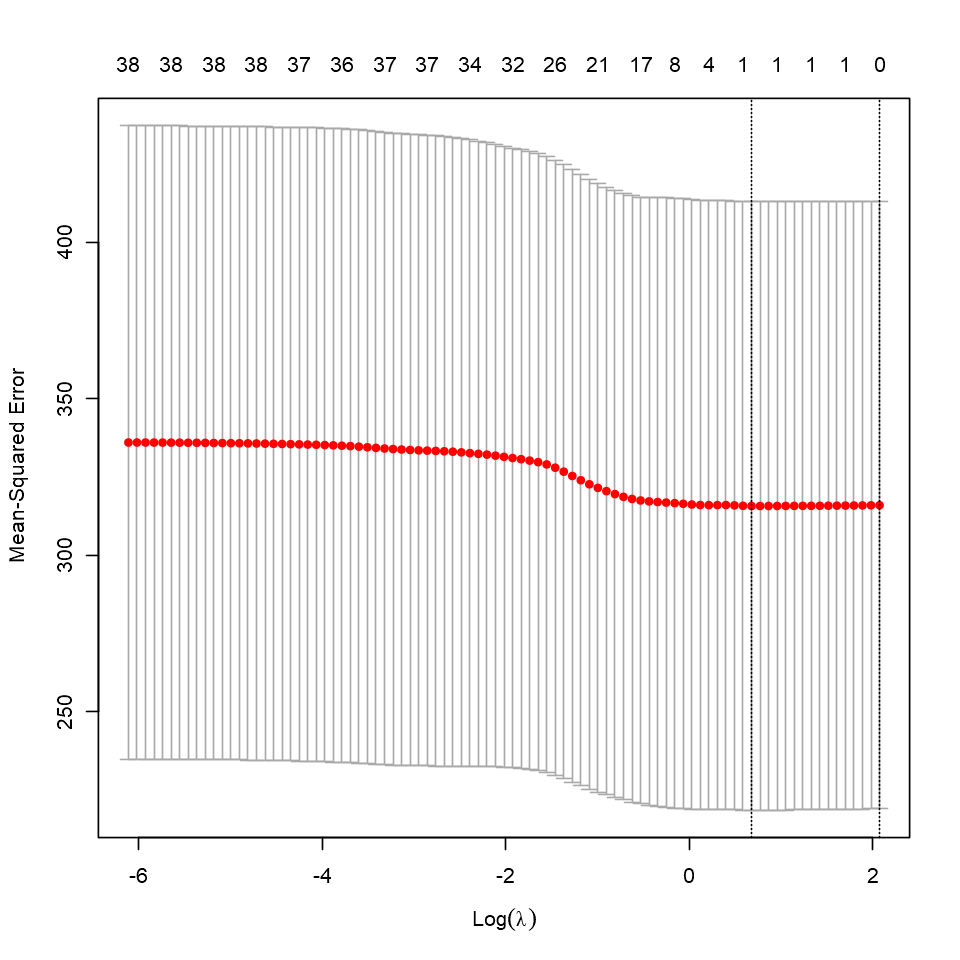

In [58]:
xmat <- model.matrix(area ~ ., data = var.data)[, -1]
cv.lasso <- cv.glmnet(xmat, var.data$area, alpha = 1)
plot(cv.lasso)
bestlam <- cv.lasso$lambda.min
bestlam

The best lambda found will be used to create a lasso regression model.

In [59]:
fit.lasso <- glmnet(xmat, var.data$area, alpha = 1)
data.frame(coefficient=predict(fit.lasso, s = bestlam, type = "coefficients")[1:34,]) %>%
    rownames_to_column(var = "variable") %>%
    filter(coefficient!=0)

variable    coefficient
1 (Intercept)   6.856785 
2 Y8          134.653571

In conclusion, lasso regression considers that only Y8 is important to predicting target variable (area). This result matches with the previous result from subsetting method. All of the tools say that the Y8 is the important variable followed by monthdec and daywed.

### Using Transformed Columns
The previous method is not satisfying for me since it only give couple variable as the important features. So, I try to do the same steps but using a dataset that also includes all transformed variables 

#### Bestsubset Method

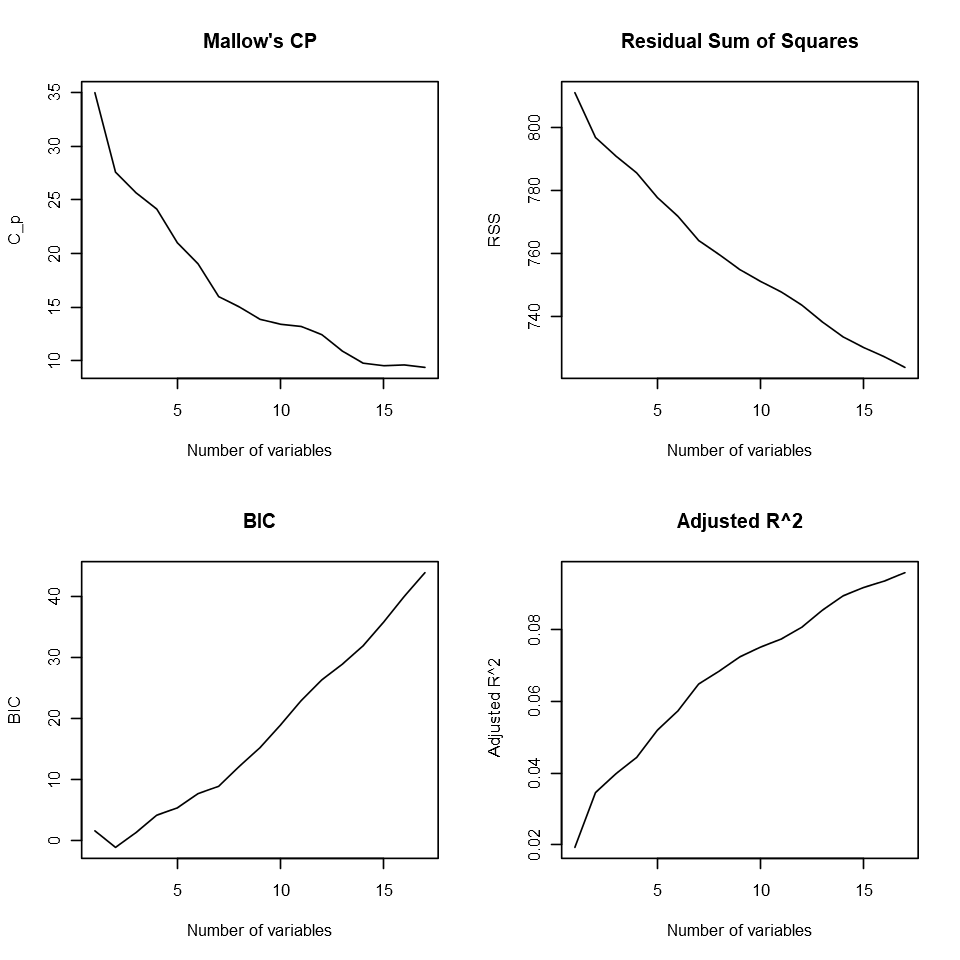

In [60]:
regfit.full <- regsubsets(area.norm ~ ., data = full.data, nvmax = ncol(full.data))
reg.summary <- summary(regfit.full)


par(mfrow = c(2,2))
plot(reg.summary$cp, main = "Mallow's CP", xlab = "Number of variables", ylab = "C_p", type = "l")
plot(reg.summary$rss, main = "Residual Sum of Squares", xlab = "Number of variables", ylab = "RSS", type = "l")
plot(reg.summary$bic, main = "BIC", xlab = "Number of variables", ylab = "BIC", type = "l")
plot(reg.summary$adjr2, main = "Adjusted R^2", xlab = "Number of variables", ylab = "Adjusted R^2", type = "l")

It is hard to get the optimal number of variable from plots above since they look like a straight line. However, I see a little break in all plots beside BIC plot at the point around 6 or 7.

#### Forward Subsetting Method

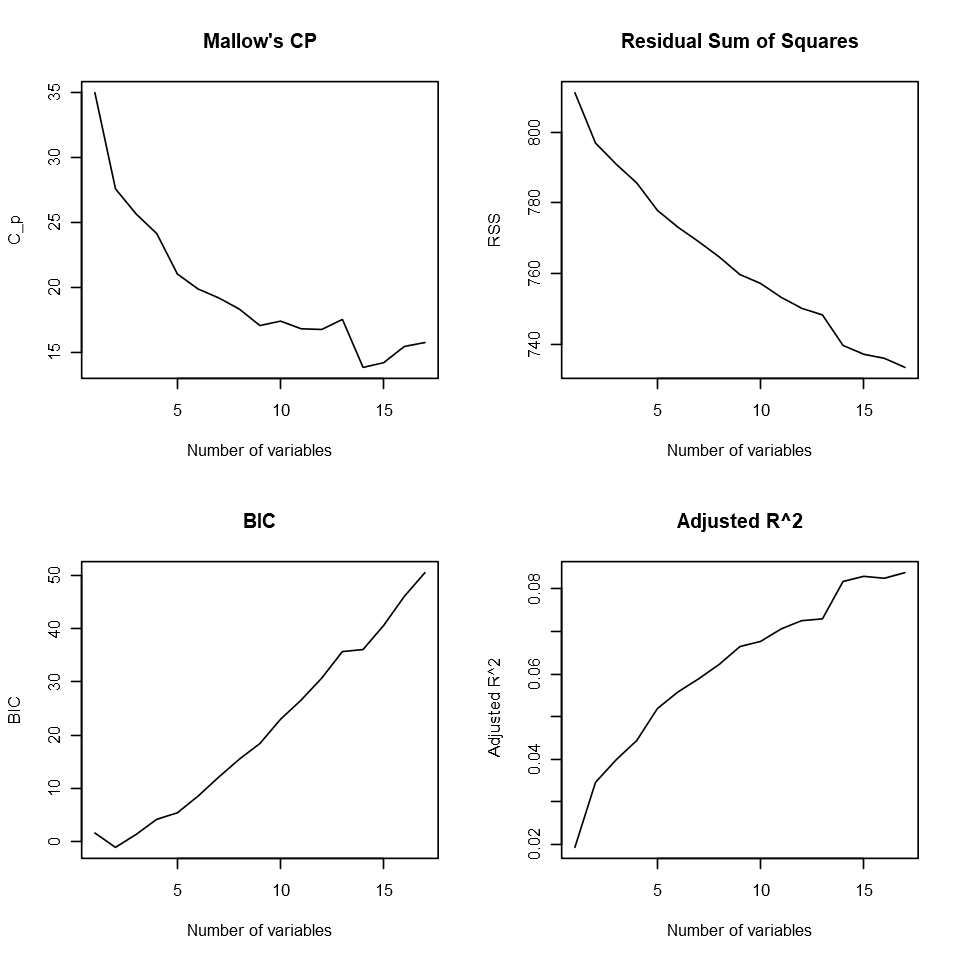

In [61]:
regfit.forward <- regsubsets(area.norm ~ ., data = full.data, nvmax = ncol(full.data), method = 'forward')
reg.summary <- summary(regfit.forward)

par(mfrow = c(2,2))
plot(reg.summary$cp, main = "Mallow's CP", xlab = "Number of variables", ylab = "C_p", type = "l")
plot(reg.summary$rss, main = "Residual Sum of Squares", xlab = "Number of variables", ylab = "RSS", type = "l")
plot(reg.summary$bic, main = "BIC", xlab = "Number of variables", ylab = "BIC", type = "l")
plot(reg.summary$adjr2, main = "Adjusted R^2", xlab = "Number of variables", ylab = "Adjusted R^2", type = "l")

The most optimal number of variables is 9 variables, even though it hard to see it clearly from all graph.

#### Backward Subsetting Method

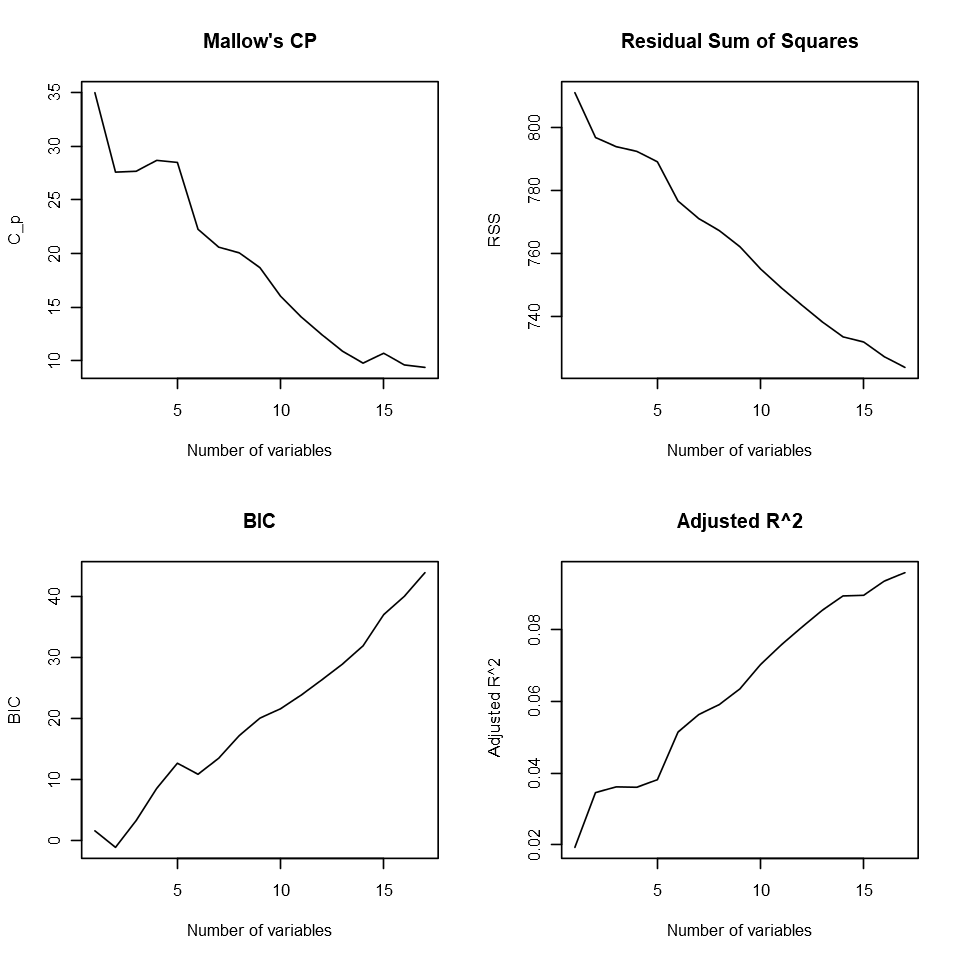

In [62]:
regfit.backward <- regsubsets(area.norm ~ ., data = full.data, nvmax = ncol(full.data), method = 'backward')
reg.summary <- summary(regfit.backward)


par(mfrow = c(2,2))
plot(reg.summary$cp, main = "Mallow's CP", xlab = "Number of variables", ylab = "C_p", type = "l")
plot(reg.summary$rss, main = "Residual Sum of Squares", xlab = "Number of variables", ylab = "RSS", type = "l")
plot(reg.summary$bic, main = "BIC", xlab = "Number of variables", ylab = "BIC", type = "l")
plot(reg.summary$adjr2, main = "Adjusted R^2", xlab = "Number of variables", ylab = "Adjusted R^2", type = "l")

The most optimal number of variables is 7 as it is seenn from all graph, even though it is hard to clearly see it.

In [63]:
data.frame(coefficient=coef(regfit.full,7))
data.frame(coefficient=coef(regfit.forward,9))
data.frame(coefficient=coef(regfit.backward,7))

coefficient
(Intercept)  0.49206939
X3          -0.53240732
X9           1.46138913
Y8           4.17792750
Y9          -1.93862390
wind         0.07180569
month.cos    0.37877488
DCsplithigh  0.35374331

coefficient
(Intercept)  0.35782155
X3          -0.56072488
Y8           4.06902089
wind         0.06303187
month.sin    0.46442767
month.cos    0.39624443
DMC.norm     0.14491614
rain.norm    1.25563591
rainNoyes   -2.01515924
DCsplithigh  0.90174743

coefficient
(Intercept)  0.25075352
X3          -0.64022175
Y3           0.69118899
Y4           0.70956016
Y5           0.63401764
Y6           0.66406527
Y8           4.71612372
wind         0.05843269

The X3, Y8 and wind are picked in all three methods showing that they are the most importan features. month.cos and DCsplitHigh are also shown as important features since they are picked in 2 of 3 methods.

#### Lasso Regression as Feature Subsetting Tool
Find the best lambda

[1] 0.01144881

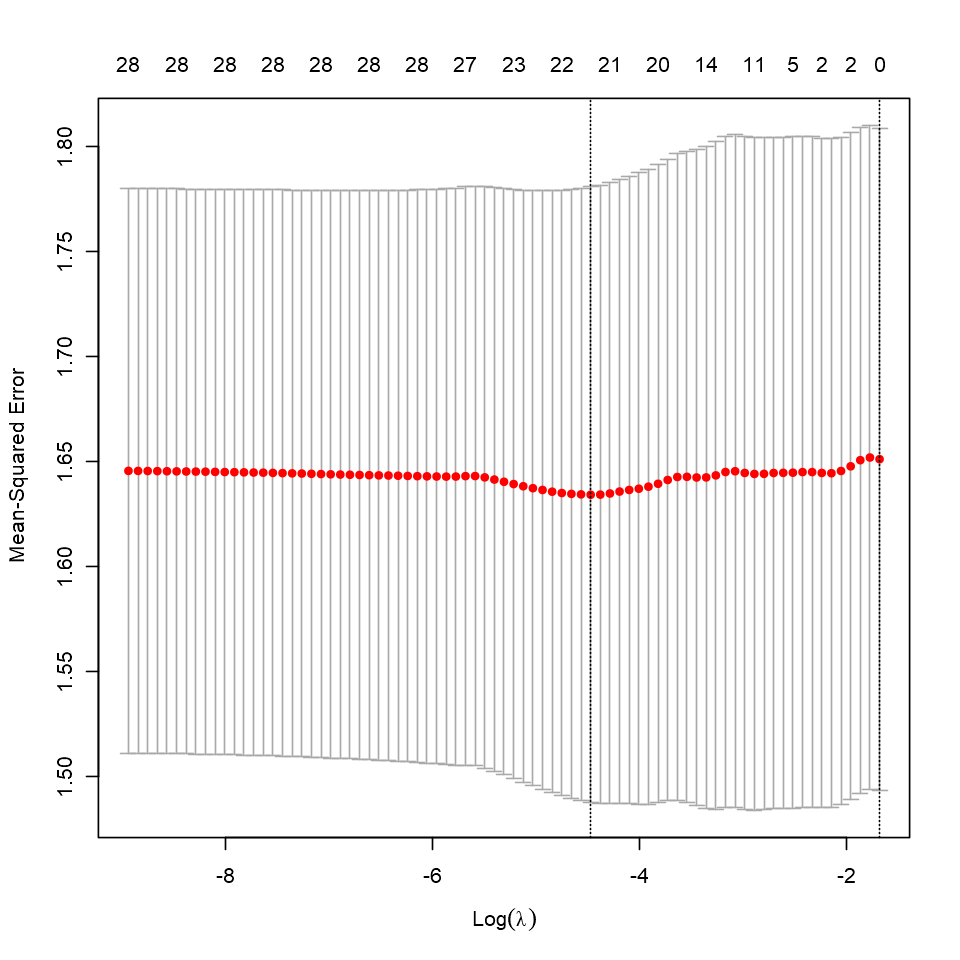

In [64]:
xmat <- model.matrix(area.norm ~ ., data = full.data)[, -1]
cv.lasso <- cv.glmnet(xmat, full.data$area.norm, alpha = 1)
plot(cv.lasso)
bestlam <- cv.lasso$lambda.min
bestlam

In [65]:
fit.lasso <- glmnet(xmat, full.data$area.norm, alpha = 1)
data.frame(coefficient=predict(fit.lasso, s = bestlam, type = "coefficients")[1:29,]) %>%
    rownames_to_column(var = "variable") %>%
    filter(coefficient!=0)

variable    coefficient
1  (Intercept)  0.22111077
2  X3          -0.65009279
3  X4           0.02610220
4  X5          -0.38769588
5  X7          -0.17864668
6  X9           1.10459530
7  Y3           0.38712930
8  Y4           0.50459976
9  Y5           0.37341321
10 Y6           0.42186493
11 Y8           4.15934906
12 Y9          -1.10581417
13 wind         0.06960457
14 month.sin    0.10104554
15 month.cos    0.40746501
16 day.cos      0.05194902
17 FFMC.norm    0.01740976
18 DMC.norm     0.12251649
19 DC.norm     -0.04985521
20 rain.norm    0.80654002
21 rainNoyes   -1.44506350
22 DCsplithigh  0.35048825

Lasso Regression only filter out 7 out of 29 possible features. and, it is hard to see which ones is the most important features 

## 6. Conclusion <a class="anchor" id="sec_6"></a>

#### Data Overview
The dataset contains 517 recorded bustfires data with 13 attributes. After I'm done with the explanatory data analysis, here is what I found:
* X and Y are a spatial coordinate data, but they are stored in numberic list. Thus, it is better to change them as factor. So does month and day which they levels need to be reset so that the level follow month order.
* month and day have circular order which mean its last and first values have a same distance order with the other pairs of values. Thus, I can do sine and cosine circular transformation to month and day.
* There are 12 influential outliers that can affect the result of machine learning algorithm. So, it is better to remove them
* There are couple skewed variables which are FFMC, DMC, DC, ISI, rain and area. So, I need to transform them to fix their distribution to be a normal distribution. I can use orderNorm function from bestNormalize package to transform FFMC, DMC, DC, and ISI, however I need to use different transformation method for rain and area. It is better to use squared root transformation for rain and log(a+1) for area to fix their skeweness.
* Rain and area have too many zero so that it is better to create a new variable that separate the zero and non-zero record of rain and area. I can also group the non zero area to be 4 groups which are small, medium, large, and very large. The new column derived from area can't be used for developing models since it will highly related to area as target variable. However, the grouped variable can be use for next explanatory analysis.
* Top positive correlations (more than .5) are shown between:
    - month and DC
    - DMC and DC
    - ISI and FFMC
    - X and Y
* Whereas top negative correlation (less than -.5) is shown between:
    - DC and month.sin
    - DC and month.cos
    - DMC and month cos
    - temp and month.cos
    - temp and RH
* All variables has a low correlation value toward target value (area). Only one variable, which is wind that looks related with target variable. The higher wind value looks related with larger bustfire area.
* correlation between FFMC and ISI looks like exponential curve
* correlation between DMC and DC looks linear when the graph are split at DC = 200, so I can create a new features that groups low DC value (<=200) and high DC value(>200)
* Normalizing continuou variables makes correlation on couples pairs looked more linear.
* DC has its highest value occurs when the park is in end of summer, and its lowest value occurs in the end of winter. So, DC is highly correlated with seasonal circle.
* As for DMC, its higher values start occuring in June and vanishing in September. So, summer in Montesinho park helps DMC values become higher.
* The month and temp correlation graph proves that warmer temperatures are around months of summer and colder temperatures are shown around winter.
* most of forests burnt are located in center part of the park.
* the eastern parts are where many large or very large bustfire.
* The most severe forest burn occured in north eastern part of the park at coordinate 8,8

#### Model Development
* The best linear model to explain the target variable is as follow:
$$lm(formula = area.norm ~ X + Y + wind + month.cos + DMC.norm + DC.norm + rain.norm + rainNo + month.cos:DC.norm + month.cos:temp, data = train.data)$$
* The best random forest model to explain the target variable is as follow:
$$randomForest(area.norm~temp + DC.norm + DMC.norm + Y + X + month.cos + ISI.norm + wind,data=train.data, mtry = 2)$$
* The SVM to explain the target variable is as follow:
$$svm(area.norm~.,data=train.data, gamma = 1, cost = 2)$$

* Random Forest performs better on single implementation of all models to predict testing data. However, the linear model shows more lower bias when I tried it many times using a different training data set

#### Variable Identification
* X3, Y8 and wind are the most importan features from three subsetting method. In addition, month.cos and DCsplitHigh are also considered as important features.

## 7. References <a class="anchor" id="sec_7"></a>

- http://www3.dsi.uminho.pt/pcortez/fires.pdf
- https://bioconductor.org/packages/devel/bioc/vignettes/sigFeature/inst/doc/vignettes.pdf
- https://datascience.stackexchange.com/questions/17759/encoding-features-like-month-and-hour-as-categorial-or-numeric
- http://www.travelstart.co.za/blog/best-time-to-visit-portugal/
- http://www.columbia.edu/~yh2693/ForestFire.html
- https://www.kaggle.com/elikplim/predict-the-burned-area-of-forest-fires
- http://topepo.github.io/caret/
- https://dplyr.tidyverse.org/reference/index.html
- https://rstudio.com/wp-content/uploads/2015/03/ggplot2-cheatsheet.pdf